# Исследование объявлений о продаже квартир

В вашем распоряжении архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import numpy as np
import pandas as pd

In [2]:
try:
    data = pd.read_csv('path_to/real_estate_data.csv',sep='\t')
    print('Прочитали данные с диска')
except:
    url = 'https://raw.githubusercontent.com/kogriv/train/main/data/real_estate_data.csv'
    data = pd.read_csv(url, sep='\t')
    print('Прочитали данные в сети')

Прочитали данные в сети


Датасет содержит 23.7К строк. Часть полей содержит пустые значения (больше всех в is_apartment, parks_nearest, ponds_nearest).

В названиях полей необходимы следующие изменения:

floor - является зарезервированным именем встроенной функции / переменной (выяснилось в ходе работы с ошибками), необходимо добавить суфикс col

cityCenters_nearest - привести к принятому стилю

Изменим названия полей и посмотрим первые 5 строк.

In [3]:
data.rename(columns={'floor':'floor_col','cityCenters_nearest':'city_centers_nearest'}, inplace = True)

In [4]:
pd.set_option('display.max_columns', None)
display(data.head())
pd.reset_option('display.max_columns')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor_col,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Построим общую гистограмму для всех числовых столбцов таблицы

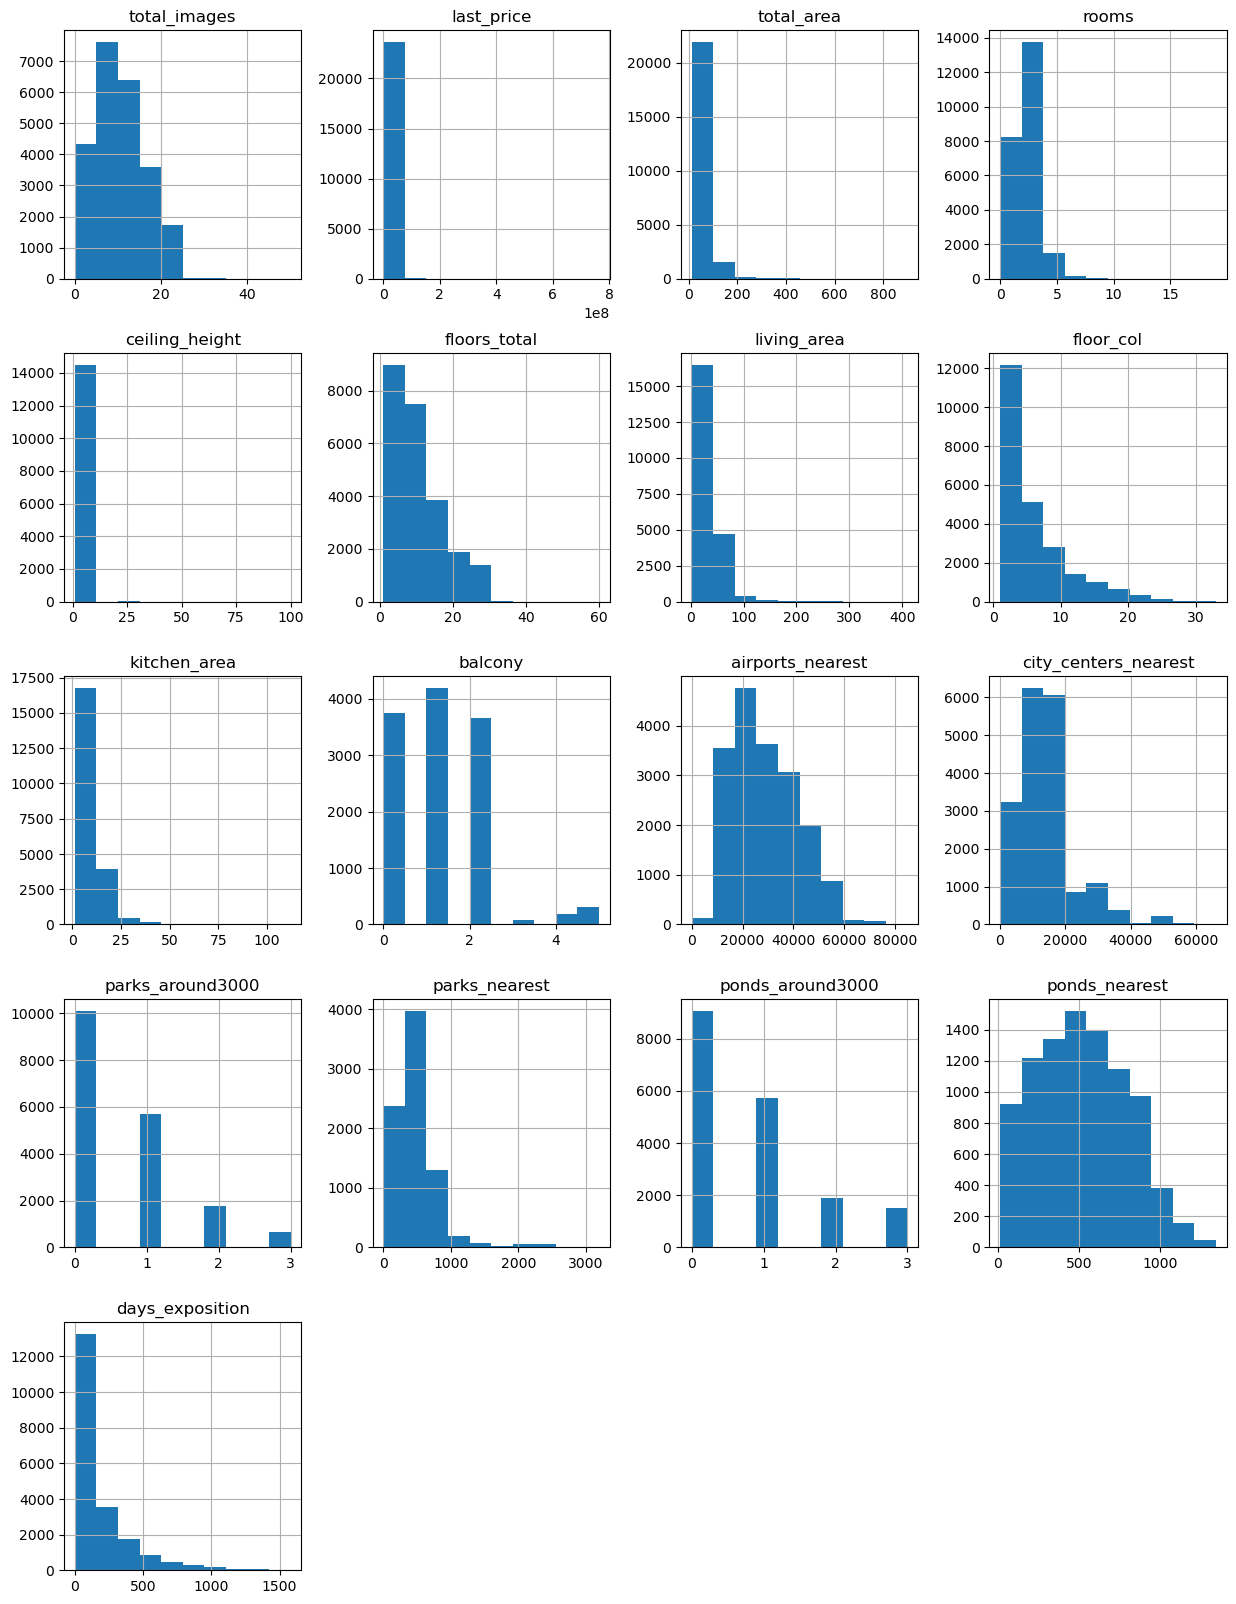

In [5]:
data.hist(figsize=(15, 20));

На первый взгляд поля не имеют очевидных выбросов в данных в виде неожиданных пиков на гистограммах. Возможно, в поле balcony есть какая то аномалия в данных в строках с количеством балконов более 3. Значения полей last_price, total_area, ceiling_height сконцентрированы в начальной области, для анализа требуется более детальная разбивка этих полей

# Предобработка данных

Создадим датафрейм с общей информацией по полям (название поля, поличество пропусков, тип, стат метрики для числовых полей).

In [6]:
def summary_table():
    df = pd.DataFrame({'col_null_count':data.isna().sum()},index=data.isna().sum().index)
    df['col_type']=data.dtypes
    df = df.join(data.describe().transpose())
    df['mean_median']=(df['mean']-df['50%'])/df['50%'] # превышение медианы над средним
    df_style = {'count':'{:.0f}','mean':'{:.2f}','mean_median':'{:.2%}', # словарь для форматирования вывода
                'std':'{:.2f}','min':'{:.1f}','25%':'{:.1f}','50%':'{:.1f}','75%':'{:.1f}','max':'{:.1f}'}
    return df, df_style
df, df_style = summary_table()
df.style.format(df_style)

,col_null_count,col_type,count,mean,std,min,25%,50%,75%,max,mean_median
total_images,0,int64,23699,9.86,5.68,0.0,6.0,9.0,14.0,50.0,9.54%
last_price,0,float64,23699,6541548.77,10887013.27,12190.0,3400000.0,4650000.0,6800000.0,763000000.0,40.68%
total_area,0,float64,23699,60.35,35.65,12.0,40.0,52.0,69.9,900.0,16.06%
first_day_exposition,0,object,nan,nan,nan,nan,nan,nan,nan,nan,nan%
rooms,0,int64,23699,2.07,1.08,0.0,1.0,2.0,3.0,19.0,3.53%
ceiling_height,9195,float64,14504,2.77,1.26,1.0,2.5,2.6,2.8,100.0,4.58%
floors_total,86,float64,23613,10.67,6.60,1.0,5.0,9.0,16.0,60.0,18.60%
living_area,1903,float64,21796,34.46,22.03,2.0,18.6,30.0,42.3,409.7,14.86%
floor_col,0,int64,23699,5.89,4.89,1.0,2.0,4.0,8.0,33.0,47.31%
is_apartment,20924,object,nan,nan,nan,nan,nan,nan,nan,nan,nan%


Из стат метрик на первый взгляд можно сделать вывод о наличии выбросов в данных, поскольку видно (поле 'mean_median') значительное отличие среднего и медианы.

Оценим случайность появления пропусков в каждом поле (а также случайнисть соответствия значений поля какому то условию). А также оценим распределение значений в каждом поле. Для этого создадим 3 функции, которые строят 3 датафрейма:

    1) матрица показателей совместного появления пропусков: берем каждое поле (базовое) с пропусками и смоотрим поочередно другие поля (расчетные) - считаем количество соместных пропусков, и долю этого количества в количестве пропусков в базовом поле. При получении значения коэффициента близкого к единице (либо больше заданного уровня отсечки) как в прямом расчете (базовое поле и расчетное) так и в обратном, можно говорить о зависимом (совместном) появлении пропусков в обоих полях и, соответветственно, о необходимости совместной обработки пропусков в таких полях.

    Также для проверки случайности / зависимости соответствия выборки значений в базовом поле по какому то условию отбора (например наличие пропусков) от распределения значений в других (расчетных) полях, посмотрим насколько равномерно распределены (сгруппированы) значения других (расчетных) полей при отборе данных в датафрейме по условию в базовом поле. Для этого создадим 2 функции, которые получат в качестве аргументов датафрейм с общей информацией по полям таблицы (df), количество разбиений (корзин) на которые будем делить значения расчетных полей, количество корзин с наибольшим весом (топ-1, 2, 3..). Функции будут возвращать 2 датафрейма:

    2.1) таблицу с интервалами разбиения расчетных полей и весом интервалов для каждого анализируемого базового поля (с условием отбора) и каждого расчетного поля: фактически декартово произведение самого на себя множества полей датафрейма (аналог гистограммы распределения в табличном виде и совокупно по всем полям).

    2.2) матрицу суммарных весов топ корзин распределения в расчетных полях.

Анализ второго датафрейма поможет определить наличие / отсутствие зависимости появления соответствия какому то условию (например, наличие пропусков) в одних (базовых) полях от распределения значений в других (расчетных) полях. Т.е., например, если все (почти) пропуски в каком то базовом поле приходятся на какую то из корзин расчетного поля, это может говорить о наличии зависимости и служить дополнительным инструментом для правильной обработки пропусков.

Возможно, в рамках данной задачи это излишние действия. Делаю это для того, чтобы пользоваться данным инструментом в дальнейшем в других проектах, а также для практики в пандас

In [7]:
cutoff = 0.9 # отсечка - уровень "зависимости" пропусков в полях
# I. создадим функцию для построения матрицы совместного появления пропусков
def null_matrix(cutoff):
    df, df_style = summary_table()
    null_list = df[df['col_null_count'] != 0].index # список полей с пропусками
    mis_matrix = pd.DataFrame(index=null_list)      # датафрейм - матрица
    cutoff_list = []

    for base in null_list:                          # пройдем по списку полей с пропусками
        calc_base = df.loc[base]['col_null_count']
        for calc in null_list: # для каждого такого поля еще пройдем по списку полей с пропусками
            calc_mis = len(data.loc[(data[base].isna()) & 
                                    (data[calc].isna())][calc])/calc_base # доля совпадающих пропусков
            mis_matrix.at[base,calc] = calc_mis
    for base in null_list: # еще раз пройдем по матрице, чтобы убрать значения меньше занной отсечки cutoff
        for calc in null_list:
            if mis_matrix.loc[base,calc] < cutoff or mis_matrix.loc[calc,base] < cutoff or calc == base:
                # значения меньше уровня отсечки в матрице будем обнулять
                # значение 1 в диагонали матрицы будем обнулять.
                mis_matrix.loc[base,calc] = 0
                mis_matrix.loc[calc,base] = 0
            elif base not in cutoff_list:
                cutoff_list.append(base)

    cutoff_matrix = pd.DataFrame(index=cutoff_list) # сокращенная после отсечки матрица совместных пропусков
    for base in cutoff_list:
        for calc in cutoff_list:
            cutoff_matrix.at[base,calc] = mis_matrix.loc[base,calc]
            if base == calc:
                cutoff_matrix.at[base,calc] = 1
    return cutoff_matrix

In [8]:
# II. Функция построения датафрейма распределния значений расчетных полей по интервалам
#             при фильтрации по заданному условию в базовом поле
#             в качестве базовых полей можно использовать:
#             1. в случае анализа пропусков (.isna()) - любые поля таблицы
#             2. при использовании условий фильтрации - только числовые поля

# блок значений переменных функции / описание ниже,  в теле функции
#-------------------------------------------------------------
panni = 20              # количество корзин
qmx =  1                # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
condition = ''          # условие отбора в базовых полях
simple = True          # False - используем условие отбора в базовых полях
top = 1                 # количество Топ корзин разбиения
b_list = ['']           # список базовых полей
b_list_use = False      # использовать / нет список базовых полей
                        # список расчетных полей
c_list =  ['']
c_list_use = False       # использовать / нет список расчетных полей
cond_count_use = False   # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк

    # зависимость переменных:
# top <= panni
# somple = False -> condition != ''
# b_list_use = True -> b_list != ['']
# c_list_use = True -> c_list !=['']

#--------------------------------------------------------------

def condition_depend(panni,qmx,qmn,condition,simple,
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,
                     cond_count_use):
    
    # panni -     количество корзин для числовых полей
    # qmx -       верхний квантиль для ограничения интервалов (для отсечения верхних выбросов)
    # qmn -       нижний квантиль для ограничения интервалов (для отсечения нижних выбросов)
    # condition - условиe, по которому фильтруется базовое поле
               #  например condition = '@cond_clmn.isna()' или '@cond_clmn > @cond_clmn.quantile(0.9)'
               #  где @cond_clmn - базовое поле (например из списка b_list)
    # simple -    если = True - просто смотрим распределения по всем полям по их корзинам
               #  без использования условия в базовом поле
    # data -      общий анализируемый датафрейм
    # df -        сводный для data датафрейм (названия, типы полей, статметрики)
    # b_list -    список базовых полей для проверки на условия
              #   для проверки пропусков возможны любые поля, для других условий- пока только числовые
    # b_list_use- True - использовать заданный список, False- используется все поля таблицы
    # c_list -    список расчетных полей
    # c_list_use- True - использовать заданный список, False- используется все поля таблицы
    # cond_count_use - True - считать долю корзины как отношение корзины к количеству строк,
              #   которые были отобраны в фильтре по базовому полю
              #   False - отношение к общему количеству строк расчетного поля

    df, df_style = summary_table()
    
    #print('df 1:')
    #print(df)
    
    digit_list = df[(df['col_type'] == 'int64') |
                    (df['col_type'] == 'float64') ].index     # список числовых полей для расчетных полей

    date_list  = df[(df['col_type'] == 'datetime64[ns]')].index  # список числовых полей с датами
    
    other_list = df[(df['col_type'] != 'int64') &
                    (df['col_type'] != 'float64') &
                    (df['col_type'] != 'datetime64[ns]') &
                    (df.index != 'first_day_exposition')
                # & (df.index != 'first_day_exposition_date')
                                                        ].index # список нечисловых полей для расчетных полей
                                                                # функция получилась не совсем универсальной
                                                                # из-за поля first_day_exposition
    if simple: # если простой анализ (без фильтрации в базовом поле)
        null_list = ['simple'] # имя переменной null_list было взято изначально, когда предполагалось
                               # использовать функцию только для анализа пустых значений
                               # это список базовых полей, по которым фильтруется таблица
    elif condition == '@cond_clmn.isna()':
        null_list = df[(df['col_null_count'] != 0)].index    # список полей с пропусками для базовых полей
    else:
        null_list = digit_list # список числовых полей: если не смотрим .isna() и не simple
                               # значит условие содержит операции сравнения, т.е. работу с числами
                               # условия для строковых данных пока не используются в функции
    #print('null_list before')
    #print(null_list)
    #print('other_list before')
    #print(other_list)
    if b_list_use and b_list != [''] and simple: # фильтрация списка расчетных полей
        digit_list= digit_list[digit_list.isin(b_list)]
        other_list= other_list[other_list.isin(b_list)]
        date_list = date_list[date_list.isin(b_list)]
    if b_list_use and b_list != ['']: # фильтрация списка базовых полей
        null_list = b_list

    #print('null_list before1')
    #print(null_list)
    #print('digit_list before1')
    #print(digit_list)
    #print('other_list before1')
    #print(other_list)
    #print('date_list before1')
    #print(date_list)
    if c_list_use and not simple: # фильтрация списка расчетных полей
        digit_list = digit_list[digit_list.isin(c_list)]
        other_list = other_list[other_list.isin(c_list)]
        date_list  = date_list[date_list.isin(c_list)]
    
    #print('digit_list after')
    #print(digit_list)
    #print('other_list after')
    #print(other_list)
    #print('date_list after')
    #print(date_list)
    #print('null_list after')
    #print(null_list)

        
    nd = pd.DataFrame(index=range(panni)) # создадим сводный датафрейм с корзинами разбиений,
                                          # в который будем добавлять столбцы
    
   # 1. проходим по списку базовых полей (с пропусками)
    for base in null_list:                # 
        if simple:
            idx_true=df.index[0]+' == '+df.index[0] # условие для полного отбора
            cond = idx_true               # если выбрано условие simple=True - не проходим по базовым полям,
                                          # не фильтруем по условию .isna() в базовом поле
                                          # просто смотрим всю таблицу на разбиения
        else:
            cond_clmn = data[base]
            cond = condition              # строка-условие для фильтрации датафрейма по базовому полю
        
        # 1.1. вложенный цикл по расчетным числовым полям
        for calc in digit_list:           # 
            #print('calc',calc)
            panniers = panni              # на каждой итерации цикла обновляем количество корзин
            col_uniq = data.query(cond)[calc].nunique()  # количество уникальных значений в расчетном поле 
            panniers = min(panniers,col_uniq) # количество корзин должно быть не больше кол-ва уник значений
            panniers = max(panniers,1)    # количество корзин должно быть больше 0
            if col_uniq <= panni:         # для малого количества уникальных значений "режем"
                bins = np.linspace((data.query(cond)[calc].min()-1), # отнимаем 1 для включения нижней границы
                                   data.query(cond)[calc].max(), col_uniq+1)  # интервалы по уникальным значенияч
                #bins = col_uniq
                cut_label = range(col_uniq) # метки (индексы) корзин для всех полей сделаем однотиными- т.е. пронумеруем
            else:                         # для больших рядов "режем" на ровные части с отсечением
                bins=np.linspace((data.query(cond)[calc].quantile(qmn)-1), # нижнего квантиля
                                  data.query(cond)[calc].quantile(qmx),    # и верхнего квантиля
                                  panniers+1)
                cut_label = range(min(panniers,bins.shape[0]))
            #print('data.query(cond)[calc].min()', data.query(cond)[calc].min())
            #print('data.query(cond)[calc].quantile(qmn)',data.query(cond)[calc].quantile(qmn))
            #print('base, calc,col_uniq',base, calc,col_uniq)
            if col_uniq>0: #and base != calc
                #print('base, calc',base, calc)
                nulldata  = pd.cut(data.query(cond)[calc], # разбивка по интервалам, индекс- нумерация (0-panniers)
                                   bins,
                                   labels=cut_label).value_counts(sort=False)
                nulldata1 = pd.cut(data.query(cond)[calc], # разбивка по интервалам - индекс- границы интервалов
                                   bins).value_counts(sort=False)
                #print('nulldata',nulldata)
                #print('nulldata1',nulldata1)
                col_int = calc+'_int'  # наименование поля интервала- расчетное поле + суфикс
                col_cnt = calc+'_cnt'  # наименование поля количество значений в интервале- расчетное поле + суфикс
                cond_count = data[~data[calc].isna()][calc].count() # кол-во непустых значений в расчетном поле
                #print('calc:',calc,', cond_count: ',cond_count,', data[calc].count(): ',data[calc].count())
                if cond_count_use:     # кол-во непустых значений в расч поле, в строках отфильтрованных по условию
                    cond_count = data.query(cond)[calc].count()
                if cond_count > 0:     # исключим деление на ноль
                    nd_col = pd.DataFrame({(base,col_int):nulldata1.index,
                                           (base,col_cnt):nulldata
                                           /cond_count},
                                            index=range(panniers))
                else:
                    nd_col = pd.DataFrame({(base,col_int):nulldata1.index,
                                           (base,col_cnt):0},
                                            index=range(panniers))
                nd = pd.concat((nd,nd_col),axis=1) # добавление полученных значений разбивки в сводный датафрейм
        
        
        # 1.2. вложенный цикл для нечисловых полей
        for calc in other_list:
            col_uniq = data.query(cond)[calc].nunique()  # количество уникальных значений в расчетном поле 
            panniers = max(col_uniq,1)
            panniers = min(panni,col_uniq)
            nulldata  = data.query(cond)[calc].value_counts(sort=False).nlargest(panniers) # берем только то, что "влазит"
                                                                                           # в нашу разбивку
            col_int = calc+'_int'
            col_cnt = calc+'_cnt'
            nd_col  = pd.DataFrame({(base,col_int):nulldata.index},index=range(panniers))
            nulldata.reset_index(drop=True,inplace=True)
            cond_count = data[~data[calc].isna()][calc].count() # кол-во непустых значений в расчетном поле
            if cond_count_use:     # кол-во непустых значений в расч поле, в строках отфильтрованных по условию
                cond_count = data.query(cond)[calc].count()
            if cond_count > 0:
                nd_col2 = pd.DataFrame({(base,col_cnt):nulldata
                                       /cond_count},
                                        index=range(panniers))
            else:
                nd_col2 = pd.DataFrame({(base,col_cnt):0},
                                        index=range(panniers))
            #nd_col = pd.concat((nd_col,nd_col2),axis=1)
            nd = pd.concat((nd,nd_col,nd_col2),axis=1)
        
        for calc in date_list:
            calc_clmn = data[calc]
            col_int = calc+'_int'
            col_cnt = calc+'_cnt'
            if cond != '' and cond != '@cond_clmn.isna()': # фильтрация расчетного поля для построения интервалов
                cond = cond+' and @calc_clmn > @calc_clmn.quantile(@qmn) and @calc_clmn < @calc_clmn.quantile(@qmx)'
            else:
                cond = '@calc_clmn > @calc_clmn.quantile(@qmn) and @calc_clmn < @calc_clmn.quantile(@qmx)'
            col_uniq = data.query(cond)[calc].nunique()  # количество уникальных значений в расчетном поле 
            panniers = max(col_uniq,1)
            panniers = min(panni,col_uniq)
            nulldata  = pd.cut(data.query(cond)[calc], # разбивка по интервалам, индекс- нумерация (0-panniers)
                                   bins=panniers).value_counts(sort=False)
            #print('*** nulldata before: ')
            #print(nulldata)
            nd_col  = pd.DataFrame({(base,col_int):nulldata.index},index=range(panniers))
            nulldata.reset_index(drop=True,inplace=True)
            #print('*** nulldata after: ')
            #print(nulldata)
            cond_count = data[~data[calc].isna()][calc].count() # кол-во непустых значений в расчетном поле
            #print('date count before:',cond_count)
            if cond_count_use:     # кол-во непустых значений в расч поле, в строках отфильтрованных по условию
                cond_count = data.query(cond)[calc].count()
            if cond_count > 0:
                nd_col2 = pd.DataFrame({(base,col_cnt):nulldata
                                       /cond_count},
                                        index=range(panniers))
            else:
                nd_col2 = pd.DataFrame({(base,col_cnt):0},
                                        index=range(panniers))
            #print('date count before:',cond_count)
            #print('*** nd_col2: ')
            #print(nd_col2)
            #print('*** nd before')
            #print(nd)
            #nd_col = pd.concat((nd_col,nd_col2),axis=1)
            nd = pd.concat((nd,nd_col,nd_col2),axis=1)
            #print('*** nd after')
            #print(nd)
            
    return nd
#fract_table = condition_depend(panni,qmx,qmn,condition,simple,
#                     data,
#                     b_list,b_list_use,
#                     c_list,c_list_use,cond_count_use)
#fract_table

In [9]:
# III. Функция построения датафрейма с матрицей суммарных весов Топ корзин,
#              полученных функцией condition_depend()

# посчитаем метрику: сумму значений из Топ N корзин (top_n_sum)

#-----------------------------------------------------------------------------------
def condition_concentrate(cutoff,simple,top,fract_table,df,b_list,b_list_use):

# cutoff -      уровень отсечения (от 0 до 1) суммы Топ N корзин при формировании
#               таблицы распределения по условию в базовом поле
#               при построении простой таблицы распределения значений cutoff не используется
# simple -      при данном условии = True - просто смотрим распределения по всем полям по их корзинам
#               то же, что в condition_depend()
# top -         количество "верхних" корзин для расчета приходящегося на них веса
# fract_table - датафрейм, построенный функцией condition_depend()
# df -          сводный для data датафрейм (названия, типы полей, статметрики)
# b_list -      список базовых полей для проверки на условия
#               для проверки пропусков возможны любые поля, для других условий- только числовые
# b_list_use-   True - использовать заданный список, False- используется все поля таблицы

    df, df_style = summary_table()
    #print('df2:')
    #print(df)
    
    fr_list = [column for column in fract_table] # список полей таблицы интервалов
    #print('fr_list: ',fr_list)
    fin_list =[]     # список полей без суфиксов. В итоговом датафрейме - это будет названиями строк
    if b_list_use:   # если задан список
        fin_list = b_list
    else:
        for b,c in fr_list:
            #print('b, c:',b,'*/*',c)
            if '_cnt' in c:
                c=c.replace('_cnt','')
            if '_int' in c:
                c=c.replace('_int','')
            if c not in fin_list:
                fin_list.append(c)
    # 1. если используем условия фильтрации в базовом поле
    if not simple:
        xd = pd.DataFrame(index=fin_list) # итоговый датафрейм
        for base in fin_list:             # проходим по всем базовым полям
            for b, calc in fr_list:       # вложенный цикл - по второму ярусу названия полей в fract_table
                if base == b and '_cnt' in calc: # используем поля со значениями распределений
                    top_n_sum = fract_table.nlargest(top, [(b,calc)])[(b,calc)].sum() # сумма топ корзин
                    top_fract = top_n_sum # здесь "лишняя" переменная- осталась от другой формулы. не стал менять
                    calc = calc.replace('_cnt','')
                    if top_fract >= cutoff: # добавляем в итоговую таблицу только суммы, превышающие отсечку
                        xd.at[base,calc] = top_fract
    
    # 2. если НЕ используем условия фильтрации в базовом поле
    else:
        xd_list = df.index                  # список всех полей таблицы
        if b_list_use:                      # фильтруем список при b_list_use=True
            xd_list=xd_list[xd_list.isin(b_list)]
        xd = pd.DataFrame(index=xd_list)    # итоговый датафрейм
        for calc in xd_list:                # проход по всем полям
            col_uniq = data[calc].nunique() # расчет количества уникальных значений
            xd.at[calc,'nunique']=col_uniq  # создание отдельного поля с кол-вом уникальных значений
            xd.at[calc,'not_nan_count']=data[~data[calc].isna()][calc].count() # количество не пустых значений
            xd.at[calc,'nan_count']=df.loc[calc,'col_null_count']
            xd.at[calc,'nan_ratio']=xd.loc[calc,'nan_count']/(xd.loc[calc,'nan_count']+xd.loc[calc,'not_nan_count'])
            xd.at[calc,'data_type']=data.dtypes[calc]
        for t in range(top):                # цикл по топ корзинам. считаем суммы 1, 1+2, 1+...+N топ корзин
            for b, calc in fr_list:
                if '_cnt' in calc:
                    top_n_sum = fract_table.nlargest((t+1), [(b,calc)])[(b,calc)].sum()
                    conc='conc_'+str(panni)+'_'+str(t+1) # создание поля для суммы Топ(1+..)корзин
                    calc=calc.replace('_cnt','')
                    top_fract = top_n_sum
                    xd.at[calc,conc]=top_fract
    return xd
#fract_table = condition_depend(panni,qmx,qmn,condition,simple,
#                     data,
#                     b_list,b_list_use,
#                     c_list,c_list_use,cond_count_use)

#condition_concentrate(0.0,simple,top,
#                      fract_table,
#                      df,b_list,b_list_use)

Используем данные функции для первичного анализа данных. Посмотрим как распределены значения полей при разбивке на 20 корзин (интервалов). Не применяем никакую фильтрацию. 

In [10]:
panni = 20              # количество корзин
qmx =  1                # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
condition = ''          # условие отбора в базовых полях
simple = True           # False - используем условие отбора в базовых полях
top = 5                 # количество Топ корзин разбиения
b_list = ['']           # список базовых полей
b_list_use = False      # использовать / нет список базовых полей
c_list = ['']           # список расчетных полей
c_list_use = False      # использовать / нет список расчетных полей
cond_count_use = False  # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк
#-------------------------------------------------------------------
fract_table = condition_depend(panni,qmx,qmn,condition,simple,
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,cond_count_use)
cutoff = 0.0
cond_conc = condition_concentrate(cutoff,simple,top,fract_table,df,b_list,b_list_use).sort_values(by='nunique')
cond_conc

,nunique,not_nan_count,nan_count,nan_ratio,data_type,conc_20_1,conc_20_2,conc_20_3,conc_20_4,conc_20_5
studio,2.0,23699.0,0.0,0.000000,bool,0.993713,1.000000,1.000000,1.000000,1.000000
open_plan,2.0,23699.0,0.0,0.000000,bool,0.997173,1.000000,1.000000,1.000000,1.000000
is_apartment,2.0,2775.0,20924.0,0.882906,object,0.981982,1.000000,1.000000,1.000000,1.000000
ponds_around3000,4.0,18181.0,5518.0,0.232837,float64,0.498927,0.813377,0.917441,1.000000,1.000000
parks_around3000,4.0,18181.0,5518.0,0.232837,float64,0.555855,0.868324,0.964413,1.000000,1.000000
balcony,6.0,12180.0,11519.0,0.486054,float64,0.344417,0.652956,0.953366,0.978325,0.993350
rooms,17.0,23699.0,0.0,0.000000,int64,0.339550,0.674585,0.919912,0.969703,0.987890
floor_col,33.0,23699.0,0.0,0.000000,int64,0.271784,0.437445,0.560530,0.678847,0.775940
floors_total,36.0,23613.0,86.0,0.003629,float64,0.334646,0.535510,0.651506,0.766442,0.824165
total_images,38.0,23699.0,0.0,0.000000,int64,0.203848,0.339972,0.473311,0.590742,0.691801


Получив сводную информацию по датафрейму, опишу логику последовательности действий при проведении предобработки данных:

Предобработку данных буду проводить по группам полей. Я выделил:

    Поля с булевым типом: studio, open_plan. Сюда же отнесем is_apartment с типом object но с двумя уникальными значениями (смотреть nunique в таблице cond_conc выше). Тип изменю. Поля studio, open_plan не требуют предобработки, т.к. не содежат пропусков (см поля nan_count и nan_ratio в таблице выше). Значения поля is_apartment сконцентрированы почти полностью (на 98%) в одной корзине (смотреть выше поле conc_20_N - содержит данные по суммам Топ N корзин для соответствущего поля). Также в is_apartment 88% пропусков. Попробуем найти зависимость для 2% непустых is_apartment от других полей таблицы и заполнить пропуски в соответствии с зависимостями. Если такую зависимость найти не получится, заполним пропуски данными из большей (98%) корзины. Выбросов в данных и некорректных значений в данной группе, очевидно нет, данная обработка не требуется.

    Территориальные поля: ponds_around3000, parks_around3000 (категориальные данные с 4-мя категориями), locality_name (364 категории), parks_nearest, parks_nearest, city_centers_nearest, airports_nearest. Сразу обработаем дубликаты в поле locality_name, поскольку пропуски в территориальных полях возможно заполнять средними по локации значениями.

    Доля пустых значений исходной таблицы data в 4-х полях: ponds_around3000, parks_around3000, city_centers_nearest, airports_nearest составляет примерно одинаковое значение - около 23%- возможно, что появление пропусков в этих четырех полях - совместное. Проверим это. Также, очевидно, что пропуски в полях ponds_around3000, parks_around3000 возможно заполнять (исправлять некорректные значения), используя данные полей parks_nearest, parks_nearest, т.к., если имеется ближайший парк на расстоянии 1км и значение в поле parks_around3000 - пустое, либо равно 0, то это значение можно заменить на минимальную единицу.

    Считаю, что в полях ponds_around3000, parks_around3000 (с 4-мя категориями) выбросов и некорректных нет. Значения поля locality_name не имеет смысл оценикать на выбросы. Для полей с расстояниями посмотрим расхождение медианы и среднего

In [13]:
# df таблица построенная функцией summary_table()
# cond_conc таблица, построенная функцией condition_concentrate()
use_list=['parks_nearest', 'parks_nearest', 'city_centers_nearest', 'airports_nearest']
df_terr = df.loc[use_list,['mean_median','min','max']]
cond_conc_terr=cond_conc.loc[use_list]
pd.concat((df_terr,cond_conc_terr),axis=1)

,mean_median,min,max,nunique,not_nan_count,nan_count,nan_ratio,data_type,conc_20_1,conc_20_2,conc_20_3,conc_20_4,conc_20_5
parks_nearest,0.078691,1.0,3190.0,995.0,8079.0,15620.0,0.659100,float64,0.250155,0.492140,0.685852,0.808021,0.908776
parks_nearest,0.078691,1.0,3190.0,995.0,8079.0,15620.0,0.659100,float64,0.250155,0.492140,0.685852,0.808021,0.908776
city_centers_nearest,0.083428,181.0,65968.0,7642.0,18180.0,5519.0,0.232879,float64,0.244994,0.485039,0.615402,0.718867,0.807096
airports_nearest,0.077366,0.0,84869.0,8275.0,18157.0,5542.0,0.233850,float64,0.138294,0.262268,0.386132,0.491491,0.591342


Учитывая приемлемые максимальные значения расстояний, считаю расхождения среднего и медианы допустимыми. Обработку аномальности / некорректности значений в данных полях проводить не буду

Слудующая группа полей.

    "Квартирные" данные: balcony, rooms, floor_col, floors_total, ceiling_height, kitchen_area, living_area, total_area

In [14]:
# df таблица построенная функцией summary_table()
# cond_conc таблица, построенная функцией condition_concentrate()
use_list=['balcony', 'rooms', 'floor_col', 'floors_total', 'ceiling_height',
                  'kitchen_area', 'living_area','total_area']
df_flat = df.loc[use_list,['mean_median','min','max','50%']]
cond_conc_flat=cond_conc.loc[use_list]
pd.concat((df_flat,cond_conc_flat),axis=1)

,mean_median,min,max,50%,nunique,not_nan_count,nan_count,nan_ratio,data_type,conc_20_1,conc_20_2,conc_20_3,conc_20_4,conc_20_5
balcony,0.150082,0.0,5.0,1.00,6.0,12180.0,11519.0,0.486054,float64,0.344417,0.652956,0.953366,0.978325,0.993350
rooms,0.035318,0.0,19.0,2.00,17.0,23699.0,0.0,0.000000,int64,0.339550,0.674585,0.919912,0.969703,0.987890
floor_col,0.473090,1.0,33.0,4.00,33.0,23699.0,0.0,0.000000,int64,0.271784,0.437445,0.560530,0.678847,0.775940
floors_total,0.185980,1.0,60.0,9.00,36.0,23613.0,86.0,0.003629,float64,0.334646,0.535510,0.651506,0.766442,0.824165
ceiling_height,0.045849,1.0,100.0,2.65,183.0,14504.0,9195.0,0.387991,float64,0.997518,0.998276,0.998966,0.999586,0.999724
kitchen_area,0.161517,1.3,112.0,9.10,971.0,21421.0,2278.0,0.096122,float64,0.646468,0.845525,0.922739,0.963821,0.980160
living_area,0.148595,2.0,409.7,30.00,1782.0,21796.0,1903.0,0.080299,float64,0.406818,0.734951,0.931639,0.971187,0.985181
total_area,0.160551,12.0,900.0,52.00,2182.0,23699.0,0.0,0.000000,float64,0.556226,0.919490,0.972404,0.988692,0.993797


 3.1. поле balcony имеет возможные некорректные максимальные значения. Оценим и исправим эти значения в соответствии с площадью и этажностью квартир. Для пропусков в поле посмотрим распределение значений в других полях. Для больших площадей и этажности имеет смысл заменить пропуски минимальной единицей, оставшиеся пропуски заменим нулем

3.2. поле rooms имеет возможные некорректные максимальные значения. Оценим и исправим эти значения в соответствии с площадью квартир.

3.3. поле floor_col не требует предобработки.

3.4. поле floor_total имеет возможные некорректные максимальные значения. Оценим и исправим эти значения в соответствии с и этажностью квартир. Пустые значения заменим на соответствующие ближайшие к данным в поле floor_col: 5, 9, 12, 21.

3.5 поле ceiling_height имеет возможные некорректные максимальные и минимальные значения. Оценим и исправим эти значения в соответствии с площадью и этажностью квартир. Пропуски заменим медианой.

3.6. поле kitchen_area имеет возможные некорректные максимальные и минимальные значения. Оценим и исправим эти значения в соответствии с площадью квартир. Пропуски заменим медианой по группе по количеству комнат.

3.7. поле living_area имеет возможные некорректные максимальные и минимальные значения. Оценим и исправим эти значения в соответствии с ценой и общей площадью квартир. Пропуски заменим на медианные по группе по количеству комнат.

3.8. поле total_area имеет возможные некорректные максимальные и минимальные значения. Оценим и исправим эти значения в соответствии с ценой и жилой площадью квартир.

Следующая группа полей:

    Характеристики объаявлений: days_exposition, first_day_exposition, total_images.

In [15]:
# df таблица построенная функцией summary_table()
# cond_conc таблица, построенная функцией condition_concentrate()
use_list=['days_exposition', 'first_day_exposition', 'total_images']
df_flat = df.loc[use_list,['mean_median','min','max','50%']]
cond_conc_flat=cond_conc.loc[use_list]

pd.concat((df_flat,cond_conc_flat),axis=1)

,mean_median,min,max,50%,nunique,not_nan_count,nan_count,nan_ratio,data_type,conc_20_1,conc_20_2,conc_20_3,conc_20_4,conc_20_5
days_exposition,0.904091,1.0,1580.0,95.0,1141.0,20518.0,3181.0,0.134225,float64,0.441856,0.646603,0.755970,0.820353,0.869286
first_day_exposition,NaN,NaN,NaN,NaN,1491.0,23699.0,0.0,0.000000,object,NaN,NaN,NaN,NaN,NaN
total_images,0.095386,0.0,50.0,9.0,38.0,23699.0,0.0,0.000000,int64,0.203848,0.339972,0.473311,0.590742,0.691801


4.1. Поле first_day_exposition дата в неотформатированном виде. Отформатируем ее и оценим на некорректность данных. Пропусков нет.

4.2. Значения поля days_exposition считаем корректными если значения first_day_exposition+days_exposition менее текущей (контрольной) даты. Пропуски заполняем медианным значением на основе того же фильтра.

4.3. total_images не требует предобработки

In [16]:
# df таблица построенная функцией summary_table()
# cond_conc таблица, построенная функцией condition_concentrate()
use_list=['last_price']
df_flat = df.loc[use_list,['mean_median','min','max','50%']]
cond_conc_flat=cond_conc.loc[use_list]

pd.concat((df_flat,cond_conc_flat),axis=1)

,mean_median,min,max,50%,nunique,not_nan_count,nan_count,nan_ratio,data_type,conc_20_1,conc_20_2,conc_20_3,conc_20_4,conc_20_5
last_price,0.406785,12190.0,763000000.0,4650000.0,2978.0,23699.0,0.0,0.0,float64,0.991097,0.997173,0.998439,0.999367,0.999578


Поле last_price имеет возможные некорректные максимальные и минимальные значения. Оценим и исправим эти значения в соответствии общей площадью квартир, расстоянием до центра. Пропусков нет.

## Обработка пропусков

### Данные с булевым типом (2 уникальных значения)

    В полях is_apartment, studio, open_plan данные сконцентрированы почти полностью в одной корзине (поле conc_20_N таблицы cond_conc содержит данные по суммам Топ N корзин для соответствущего поля).

Посмотрим корзины (как распределены значения) для is_apartment, studio, open_plan

In [17]:
(fract_table[~fract_table[('simple','studio_int')].isna()]
                         [[('simple','is_apartment_int'),('simple','is_apartment_cnt'),
                           ('simple','studio_int'),('simple','studio_cnt'),
                       ('simple','open_plan_int'),('simple','open_plan_cnt')]])

,"(simple, is_apartment_int)","(simple, is_apartment_cnt)","(simple, studio_int)","(simple, studio_cnt)","(simple, open_plan_int)","(simple, open_plan_cnt)"
0,False,0.981982,False,0.993713,False,0.997173
1,True,0.018018,True,0.006287,True,0.002827


Видим, что почти вся недвижимость: не аппартаменты, не студии и не объекты свободной планировки (принимаем во внимание, что для подсчета отобраны строки непустые в соответствующих полях- для поля is_apartment - это только 12% (смотреть nan_ratio в таблице cond_conc выше) от всего датафрейма)

При этом поле is_apartment имеет тип object, хотя по факту являет булевым значением. Изменим тип данных в поле.

In [18]:
data['is_apartment']=data['is_apartment'].astype(bool)
display(data['is_apartment'].value_counts())

True     20974
False     2725
Name: is_apartment, dtype: int64

Обработаем пропуски в поле is_apartment. Посмотрим, можем ли мы что то поменять на True. Посмотрим распределения значений группы квартирных полей ['balcony', 'rooms', 'floor_col', 'floors_total', 'ceiling_height', 'kitchen_area', 'living_area','total_area'] для условия is_apartment=True

In [19]:
panni = 10              # количество корзин
qmx =  1                # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
condition = '@cond_clmn == True'          # условие отбора в базовых полях
simple = False          # False - используем условие отбора в базовых полях
top = 2                 # количество Топ корзин разбиения
b_list = ['is_apartment']           # список базовых полей
b_list_use = True      # использовать / нет список базовых полей
                        # список расчетных полей
c_list =  ['balcony', 'rooms', 'floor_col', 'floors_total',
           'ceiling_height', 'kitchen_area', 'living_area','total_area']
c_list_use = True       # использовать / нет список расчетных полей
cond_count_use = True   # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк
#-------------------------------------------------------------------
fract_table_is_ap = condition_depend(panni,qmx,qmn,condition,simple,
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,cond_count_use)
cutoff = 0.0
cond_conc_is_ap = condition_concentrate(cutoff,simple,top,fract_table_is_ap,df,b_list,b_list_use)
display(fract_table_is_ap)
display(cond_conc_is_ap)

,"(is_apartment, total_area_int)","(is_apartment, total_area_cnt)","(is_apartment, rooms_int)","(is_apartment, rooms_cnt)","(is_apartment, ceiling_height_int)","(is_apartment, ceiling_height_cnt)","(is_apartment, floors_total_int)","(is_apartment, floors_total_cnt)","(is_apartment, living_area_int)","(is_apartment, living_area_cnt)","(is_apartment, floor_col_int)","(is_apartment, floor_col_cnt)","(is_apartment, kitchen_area_int)","(is_apartment, kitchen_area_cnt)","(is_apartment, balcony_int)","(is_apartment, balcony_cnt)"
0,"(11.0, 99.9]",0.919949,"(-1.0, 1.0]",0.349528,"(0.0, 10.0]",0.998739,"(0.0, 6.0]",0.382133,"(1.0, 41.87]",0.736902,"(0.0, 3.3]",0.396682,"(0.3, 11.47]",0.726883,"(-1.0, 0.0]",0.312822
1,"(99.9, 188.8]",0.068418,"(1.0, 3.0]",0.579241,"(10.0, 20.0]",0.000236,"(6.0, 12.0]",0.314822,"(41.87, 82.74]",0.234218,"(3.3, 6.6]",0.283017,"(11.47, 22.64]",0.237083,"(0.0, 1.0]",0.350247
2,"(188.8, 277.7]",0.007819,"(3.0, 5.0]",0.062411,"(20.0, 30.0]",0.000867,"(12.0, 18.0]",0.163587,"(82.74, 123.61]",0.019288,"(6.6, 9.9]",0.140269,"(22.64, 33.81]",0.023793,"(1.0, 2.0]",0.290528
3,"(277.7, 366.6]",0.002336,"(5.0, 7.0]",0.007390,"(30.0, 40.0]",0.000079,"(18.0, 24.0]",0.078993,"(123.61, 164.48]",0.005526,"(9.9, 13.2]",0.090016,"(33.81, 44.98]",0.008002,"(2.0, 3.0]",0.005548
4,"(366.6, 455.5]",0.000715,"(7.0, 9.0]",0.000906,"(40.0, 50.0]",0.000000,"(24.0, 30.0]",0.059125,"(164.48, 205.35]",0.002502,"(13.2, 16.5]",0.042100,"(44.98, 56.15]",0.002862,"(3.0, 4.0]",0.015233
5,"(455.5, 544.4]",0.000524,"(9.0, 11.0]",0.000238,"(50.0, 60.0]",0.000000,"(30.0, 36.0]",0.001197,"(205.35, 246.22]",0.000469,"(16.5, 19.8]",0.022742,"(56.15, 67.32]",0.000795,"(4.0, 5.0]",0.025623
6,"(544.4, 633.3]",0.000191,"(11.0, 13.0]",0.000048,"(60.0, 70.0]",0.000000,"(36.0, 42.0]",0.000048,"(246.22, 287.09]",0.000678,"(19.8, 23.1]",0.018976,"(67.32, 78.49]",0.000265,NaN,NaN
7,"(633.3, 722.2]",0.000000,"(13.0, 15.0]",0.000143,"(70.0, 80.0]",0.000000,"(42.0, 48.0]",0.000000,"(287.09, 327.96]",0.000209,"(23.1, 26.4]",0.005578,"(78.49, 89.66]",0.000053,NaN,NaN
8,"(722.2, 811.1]",0.000000,"(15.0, 17.0]",0.000048,"(80.0, 90.0]",0.000000,"(48.0, 54.0]",0.000048,"(327.96, 368.83]",0.000104,"(26.4, 29.7]",0.000477,"(89.66, 100.83]",0.000159,NaN,NaN
9,"(811.1, 900.0]",0.000048,"(17.0, 19.0]",0.000048,"(90.0, 100.0]",0.000079,"(54.0, 60.0]",0.000048,"(368.83, 409.7]",0.000104,"(29.7, 33.0]",0.000143,"(100.83, 112.0]",0.000106,NaN,NaN


,total_area,rooms,ceiling_height,floors_total,living_area,floor_col,kitchen_area,balcony
is_apartment,0.988367,0.928769,0.999606,0.696955,0.97112,0.679699,0.963966,0.663069


Видим, что в сегменте is_apartment=True объекты распределены следующим образом:

    88% имеют площадь от 19 до 116.7 м.кв.,
    68% rooms = 1 и 2,
    98% потолки до 11.4м
    88% living_area от 12.9 до 70.6
    83% балконов - от 1 до 2 шт.
    68% этажность от 2 до 6
    66% этаж с 1 по 4

Понятно, что данные критерии применимы для широкого спектра объектов. Т.е. аппартаментами может быть практически любая недвижимость. Т.о. не выделив для is_apartment=True характерного набора признаков в других полях, заменим пропуски в is_apartment на False как на наиболее часто встречающееся (98%) значение для непустых значений поля

In [20]:
data.loc[data.query('is_apartment.isna()').index,
         'is_apartment']=False
data.query('is_apartment.isna()')['is_apartment'].count()

0

### Группа "территориальных" полей

Посмотрим, как распределены значения по Топ5 корзин всех "территориальных" полей. 'ponds_around3000', 'parks_around3000','parks_nearest','ponds_nearest', 'city_centers_nearest','airports_nearest','locality_name'

In [21]:
terr_list = ['ponds_around3000', 'parks_around3000','parks_nearest',
             'ponds_nearest', 'city_centers_nearest','airports_nearest','locality_name']

In [22]:
top_panni = pd.DataFrame(index=range(5)) # датафрейм, в который поместим отобранную информацию по Топ корзинам
for clm in ['ponds_around3000', 'parks_around3000','parks_nearest','ponds_nearest']:
    sf = pd.DataFrame((fract_table.nlargest(5,[('simple',clm+'_cnt')])
            [[('simple',clm+'_int'),('simple',clm+'_cnt')]].reset_index(drop= True)))
    top_panni=pd.concat((top_panni,sf),
                     axis = 1)
display(top_panni)

top_panni = pd.DataFrame(index=range(5))
for clm in ['city_centers_nearest','airports_nearest','locality_name']:
    sf = pd.DataFrame((fract_table.nlargest(5,[('simple',clm+'_cnt')])
            [[('simple',clm+'_int'),('simple',clm+'_cnt')]].reset_index(drop= True)))
    top_panni=pd.concat((top_panni,sf),
                     axis = 1)
display(top_panni)
print('Максимальное / минимальное количество прудов до 3 км',data['ponds_around3000'].max(),
      '/',data['ponds_around3000'].min())
print('Максимальное / минимальное количество парков до 3 км',
      data['parks_around3000'].max(),'/',data['parks_around3000'].min())
print('Максимальное / минимальное расстояние до ближайшего парка',
      data['parks_nearest'].max(),'/',data['parks_nearest'].min())
print('Максимальное / минимальное расстояние до ближайшего пруда',
      data['ponds_nearest'].max(),'/',data['ponds_nearest'].min())
print('Максимальное / минимальное расстояние до центра',
      data['city_centers_nearest'].max(),'/',data['city_centers_nearest'].min())
print('Максимальное / минимальное расстояние до аэропорта',
      data['airports_nearest'].max(),'/',data['airports_nearest'].min())

,"(simple, ponds_around3000_int)","(simple, ponds_around3000_cnt)","(simple, parks_around3000_int)","(simple, parks_around3000_cnt)","(simple, parks_nearest_int)","(simple, parks_nearest_cnt)","(simple, ponds_nearest_int)","(simple, ponds_nearest_cnt)"
0,"(-1.0, 0.0]",0.498927,"(-1.0, 0.0]",0.555855,"(319.0, 478.5]",0.250155,"(411.6, 478.2]",0.093963
1,"(0.0, 1.0]",0.314449,"(0.0, 1.0]",0.312469,"(478.5, 638.0]",0.241985,"(544.8, 611.4]",0.080132
2,"(1.0, 2.0]",0.104065,"(1.0, 2.0]",0.096089,"(159.5, 319.0]",0.193712,"(345.0, 411.6]",0.079912
3,"(2.0, 3.0]",0.082559,"(2.0, 3.0]",0.035587,"(638.0, 797.5]",0.122169,"(611.4, 678.0]",0.075412
4,NaN,NaN,NaN,NaN,"(0.0, 159.5]",0.100755,"(478.2, 544.8]",0.073216


,"(simple, city_centers_nearest_int)","(simple, city_centers_nearest_cnt)","(simple, airports_nearest_int)","(simple, airports_nearest_cnt)","(simple, locality_name_int)","(simple, locality_name_cnt)"
0,"(13337.6, 16627.0]",0.244994,"(21216.5, 25460.0]",0.138294,Санкт-Петербург,0.664736
1,"(10048.2, 13337.6]",0.240044,"(12729.5, 16973.0]",0.123974,посёлок Мурино,0.022072
2,"(3469.4, 6758.8]",0.130363,"(16973.0, 21216.5]",0.123864,посёлок Шушары,0.018605
3,"(6758.8, 10048.2]",0.103465,"(33947.0, 38190.5]",0.105359,Всеволожск,0.016829
4,"(16627.0, 19916.4]",0.088229,"(29703.5, 33947.0]",0.099851,Пушкин,0.015603


Максимальное / минимальное количество прудов до 3 км 3.0 / 0.0
Максимальное / минимальное количество парков до 3 км 3.0 / 0.0
Максимальное / минимальное расстояние до ближайшего парка 3190.0 / 1.0
Максимальное / минимальное расстояние до ближайшего пруда 1344.0 / 13.0
Максимальное / минимальное расстояние до центра 65968.0 / 181.0
Максимальное / минимальное расстояние до аэропорта 84869.0 / 0.0


Видим, что около 50% (смотреть ponds_around3000_cnt, parks_around3000_cnt) объектов не имеют (смотреть ponds_around3000_int, parks_around3000_int) парков и прудов на расстоянии до 3км и по 31% объектов имеют по одному парку и пруду. Возможно, парки и пруды идут "в комплекте".

90% или сумма 5-ти порзин (parks_nearest_cnt) объектов имеют ближайший парк на расстоянии до 800м. (parks_nearest_int)

40% или сумма 5-ти порзин (ponds_nearest_cnt) объектов имеют ближайший водоем на расстоянии от 345 до 678 м. (ponds_nearest_int)

Распределение значений полей city_centers_nearest и airports_nearest равномерное.

Почти 50% сумма 2-х корзин (city_centers_nearest) объектов находятся на расстоянии от 10 до 16.6км от центра (city_centers_nearest_int)

2/3 (одна корзина locality_name_cnt) объектов приходтся на Санкт-Петербург.

!!! Обращаю внимание, что интервалы значений полей в таблице fract_table, построенной функцией condition_depend с указанием значения переменной simple=True (из которой сделана вырезка в ячейке выше) - не связаны между собой. Т.е. интервал (-1.0, 0.0] поля (simple, ponds_around3000_int) и интервал (-1.0, 0.0] поля (simple, parks_around3000_int) построены отдельно друг от друга и говорить о какой-либо зависимости между полями на основании данного построения нельзя. В таблице fract_table просто собраны распределения всех полей по 20 интервалам. Зависимость полей оценим дальше.

#### Заменим неявные дубликаты в поле locality_name

Пойдем прямым путем. Посмотрим все уникальные значения

In [23]:
data.query('locality_name.notna()')['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

Определим первичные очевидные замены: то, что удалось зафиксировать глазом

    посёлок -> поселок
    коттеджный поселок -> поселок
    городской поселок -> поселок городского типа,
    поселок станции -> поселок при железнодорожной станции

Проведем эти замены.

In [24]:
#
data['locality_name']=data['locality_name'].str.replace('посёлок','поселок')
data['locality_name']=data['locality_name'].str.replace('коттеджный поселок','поселок')
data['locality_name']=data['locality_name'].str.replace('городской поселок','поселок городского типа')
data['locality_name']=data['locality_name'].str.replace('поселок станции','поселок при железнодорожной станции')

Отметим, что все имена локаций заканчиваются именами собственными. Выделим их и посмотрим на их неоднократное вхождение в набор уникальных имен (например "Кедрово" и "деревня Кедрово"). Сначала выделим двукратные вхождения.

In [25]:
# Поскольку ниже будет несколько длительный цикл работы со строковыми данными
# Импортирую библиотеку для отображения статус-бара
import tqdm

def repeat_names(r_from,r_to):
    # r_from, r_to не включительно (т.е. > и <) границы диапазона количества вхождений
    #              собственного имени в список ункальных значений полных имен
    # Получим последние слова названия населенных пунктов
    name_list = data.query('locality_name.notna()')['locality_name'].str.split().str[-1].unique().tolist()

    # Пройдем по списку названий и посмотрим встречающиеся repeats раз
    names=pd.DataFrame()
    counter = 0
    for name in tqdm.tqdm(name_list):
        # количество вхождений собственного имени в набор уникальных имен
        v = data.query('@name in locality_name.str.split().str[-1]')['locality_name'].nunique()
        if v > r_from and v < r_to:
            # максимальное (для строк) имя
            mx_name = data.query('@name in locality_name.str.split().str[-1]')['locality_name'].max()
            # минимальное (для строк) имя
            mn_name = data.query('@name in locality_name.str.split().str[-1]')['locality_name'].min()
            # минимальное расстояние до центра для данного собственного имени
            mn_rast = data.query('@name in locality_name.str.split().str[-1]')['city_centers_nearest'].min()
            # максимальное расстояние до центра для данного собственного имени
            mx_rast = data.query('@name in locality_name.str.split().str[-1]')['city_centers_nearest'].max()
            names.at[counter,'incl_numb']=v
            names.at[counter,'cur_name']=name
            names.at[counter,'max_name']=mx_name
            names.at[counter,'min_name']=mn_name
            names.at[counter,'min_rast']=mn_rast
            names.at[counter,'max_rast']=mx_rast
            counter +=1
    return names

names = repeat_names(1,3) # >1 and <3 =>2
names

100%|██████████| 294/294 [00:30<00:00,  9.77it/s]


,incl_numb,cur_name,max_name,min_name,min_rast,max_rast
0,2.0,Мурино,поселок Мурино,Мурино,21888.0,21888.0
1,2.0,Кудрово,деревня Кудрово,Кудрово,NaN,NaN
2,2.0,Фёдоровское,поселок городского типа Фёдоровское,деревня Фёдоровское,NaN,NaN
3,2.0,Ропша,садовое товарищество Новая Ропша,поселок Ропша,NaN,NaN
4,2.0,Никольское,село Никольское,Никольское,NaN,NaN
5,2.0,Романовка,поселок Романовка,деревня Малая Романовка,NaN,NaN
6,2.0,Павлово,село Павлово,поселок городского типа Павлово,NaN,NaN
7,2.0,Рахья,садовое товарищество Рахья,поселок городского типа Рахья,NaN,NaN
8,2.0,Колпаны,деревня Малые Колпаны,деревня Большие Колпаны,NaN,NaN
9,2.0,Ладога,село Старая Ладога,Новая Ладога,NaN,NaN


Из таблицы выше я выбрал названия, которые не буду изменять

    садовое товарищество Новая Ропша поселок Ропша
    поселок Романовка деревня Малая Романовка
    садовое товарищество Рахья поселок городского типа Рахья
    деревня Малые Колпаны деревня Большие Колпаны
    село Старая Ладога Новая Ладога
    деревня Старые Бегуницы деревня Бегуницы
    село Старая Ладога Новая Ладога
    садовое товарищество Приладожский поселок городского типа Приладожский
    поселок городского типа Дружная Горка поселок Форт Красная Горка

Из них составлю отдельный список имен собственных, названия, по которым не буду приводить к единому.

In [26]:
name_list_stand = ['Ропша','Рахья','Романовка','Рахья','Колпаны','Ладога','Приладожский','Горка']

Сольем (объединим) двукратные вхождения имен собственных с учетом исключений. Заменим на максимальное имя

In [27]:
for name in tqdm.tqdm(names['cur_name']):
    if name not in name_list_stand:
        mx_name=data.query('@name in locality_name.str.split().str[-1]')['locality_name'].max()
        idx = data.query('@name in locality_name.str.split().str[-1]').index
        data.loc[idx,'locality_name']=mx_name
        #print(mx_name)
repeat_names(1,3)

100%|██████████| 294/294 [00:24<00:00, 12.15it/s]


,incl_numb,cur_name,max_name,min_name,min_rast,max_rast
0,2.0,Ропша,садовое товарищество Новая Ропша,поселок Ропша,NaN,NaN
1,2.0,Романовка,поселок Романовка,деревня Малая Романовка,NaN,NaN
2,2.0,Рахья,садовое товарищество Рахья,поселок городского типа Рахья,NaN,NaN
3,2.0,Колпаны,деревня Малые Колпаны,деревня Большие Колпаны,NaN,NaN
4,2.0,Ладога,село Старая Ладога,Новая Ладога,NaN,NaN
5,2.0,Приладожский,садовое товарищество Приладожский,поселок городского типа Приладожский,NaN,NaN
6,2.0,Горка,поселок городского типа Дружная Горка,поселок Форт Красная Горка,NaN,NaN


Осталось, то, что должно остаться.

Теперь посмотрим собственные имена с числом повторний в уникальных названиях больше 2. В качестве верхней границы функции возьмем количество уникальных значений locality_name в исходном датасете

In [28]:
repeat_names(2,data['locality_name'].nunique())

100%|██████████| 294/294 [00:22<00:00, 12.82it/s]


,incl_numb,cur_name,max_name,min_name,min_rast,max_rast
0,6.0,Бор,поселок городского типа Красный Бор,Сосновый Бор,NaN,NaN


Получили один вариант с шестью повторениями. Посмотрим эти локации

In [29]:
g= 'Бор'
data.query('@g in locality_name.str.split().str[-1]')['locality_name'].unique()

array(['поселок городского типа Красный Бор', 'Сосновый Бор',
       'деревня Чудской Бор', 'деревня Бор', 'деревня Трубников Бор',
       'поселок Пансионат Зелёный Бор'], dtype=object)

Очевидно, что это разные названия, которые не надо объединять.

На этом с обработкой дубликатов в locality_name закончили.

Посмотрим пустые значения поля локаций. Сравним расстояния до центра по ним с максимальным и медианным расстоянием до центра.

In [30]:
g='Санкт-Петербург'
print('Количество пустых значений в поле локаций:',data['locality_name'].isna().sum())
centres_max = data.query('locality_name == @g')['city_centers_nearest'].max()
centres_med = data.query('locality_name == @g')['city_centers_nearest'].median()
print('Максимальное расстояние в СПБ:',centres_max)
print('Медианное расстояние в СПБ:',centres_med)
print('Количество пустых значений в поле локаций, по расстояниям иеньше максимального в СПБ:',
data[(data['locality_name'].isna()) & (data['city_centers_nearest']<centres_max)]['city_centers_nearest'].count())
print('Количество пустых значений в поле локаций, по расстояниям иеньше медианного в СПБ:',
data[(data['locality_name'].isna()) & (data['city_centers_nearest']<centres_med)]['city_centers_nearest'].count())

Количество пустых значений в поле локаций: 49
Максимальное расстояние в СПБ: 29493.0
Медианное расстояние в СПБ: 12244.5
Количество пустых значений в поле локаций, по расстояниям иеньше максимального в СПБ: 38
Количество пустых значений в поле локаций, по расстояниям иеньше медианного в СПБ: 26


Посмотрим какие локации попадают в максимальное и медианное расстояние для СПБ

In [31]:
print('Локации до максимума')
display(data[(data['city_centers_nearest']<=centres_max)]['locality_name'].unique())
print('Локации до медианы')
data[(data['city_centers_nearest']<=centres_med)]['locality_name'].unique()

Локации до максимума


array(['Санкт-Петербург', 'поселок Шушары', 'поселок Парголово',
       'поселок Металлострой', 'Пушкин', 'Красное Село',
       'поселок Стрельна', 'поселок Александровская', nan,
       'поселок Песочный', 'Колпино', 'поселок Петро-Славянка',
       'поселок Лисий Нос', 'поселок Левашово', 'поселок Мурино',
       'поселок Усть-Ижора'], dtype=object)

Локации до медианы


array(['Санкт-Петербург', nan], dtype=object)

Видим, что в "домедианное" расстояние до центра попадает только Санкт-Петербург, а в "домаксимальное" еще и другие локации. Поскольку других ориентиров для локаций нет, заменим пустые значения локаций на Санкт-Петербург с условием попадания их расстояния в "домедианное"

In [32]:
data.loc[data[(data['locality_name'].isna()) &
              (data['city_centers_nearest']<centres_med)].index,'locality_name']='Санкт-Петербург'
print('Количество пустых значений в поле локаций:',data['locality_name'].isna().sum())

Количество пустых значений в поле локаций: 23


Оставшиеся пустые значения не трогаем.

### Теперь обработаем пропуски в территориальных полях.

Используем написанную выше функцию для отображения матрицы взаимного появления пропусков.

In [33]:
cutoff = 0.0
null_matrix(cutoff)

,ceiling_height,floors_total,living_area,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
ceiling_height,1.000000,0.008374,0.120283,0.145514,0.464600,0.001958,0.280370,0.280044,0.280044,0.697118,0.280044,0.632626,0.079173
floors_total,0.895349,1.000000,0.383721,0.546512,0.453488,0.011628,0.116279,0.116279,0.116279,0.604651,0.116279,0.430233,0.104651
living_area,0.581188,0.017341,1.000000,0.769312,0.738308,0.001576,0.328429,0.327378,0.327378,0.696795,0.327378,0.634787,0.104046
kitchen_area,0.587357,0.020632,0.642669,1.000000,0.679982,0.002195,0.314750,0.313872,0.313872,0.697103,0.313872,0.629500,0.089113
balcony,0.370866,0.003386,0.121972,0.134473,1.000000,0.000521,0.235871,0.235263,0.235263,0.642591,0.235263,0.606737,0.183176
locality_name,0.782609,0.043478,0.130435,0.217391,0.260870,1.000000,0.347826,0.347826,0.347826,1.000000,0.347826,0.565217,0.043478
airports_nearest,0.465175,0.001804,0.112775,0.129376,0.490256,0.001444,1.000000,0.995669,0.995669,0.996391,0.995669,0.998556,0.156442
city_centers_nearest,0.466570,0.001812,0.112883,0.129552,0.491031,0.001450,0.999819,1.000000,0.999819,0.999819,0.999819,1.000000,0.156912
parks_around3000,0.466655,0.001812,0.112903,0.129576,0.491120,0.001450,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.156760
parks_nearest,0.410371,0.003329,0.084891,0.101665,0.473880,0.001472,0.353521,0.353265,0.353265,1.000000,0.353265,0.725608,0.130346


Данная матрица читается следующим образом: возьмем 1-ю строку ceiling_height. Произведена фильтрация датасета по наличию пропусков в ceiling_height, посчитано их количество. Данный отфильтрованованный сегмент опять фильтруется по наличию пропусков теперь уже в других полях и полученное количество пропусков делится на количество пропусков в ceiling_height. Соотвтественно для ячейки матрицы (ceiling_height,ceiling_height) значение равно 1, для (ceiling_height,floors_total) = 0.008374, и т.д.

Если показатель для ячеек (Поле1,Поле2) и (Поле2,Поле1) одновременно равен или близок к 1 это говорит о совместном одновременном появлении пропусков в двух полях.

Уровень отсечки cutoff позволяет фильтровать матрицу по уровню одновременных значений (Поле1,Поле2) и (Поле2,Поле1) матрицы больше cutoff.

Выведем наш список терр.полей

In [34]:
# список "терр" полей
terr_list

['ponds_around3000',
 'parks_around3000',
 'parks_nearest',
 'ponds_nearest',
 'city_centers_nearest',
 'airports_nearest',
 'locality_name']

Используем небольшую функцию для создания пересечения списков

In [35]:
def intersection_list(list1, list2): 
    list3 = [value for value in list1 if value in list2] 
    return list3

Посмотрим матрицу пропусков для терр. списка

In [36]:
cutoff = 0.0
display(null_matrix(cutoff).loc[intersection_list(terr_list, null_matrix(cutoff))])

,ceiling_height,floors_total,living_area,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
ponds_around3000,0.466655,0.001812,0.112903,0.129576,0.491120,0.001450,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.156760
parks_around3000,0.466655,0.001812,0.112903,0.129576,0.491120,0.001450,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.156760
parks_nearest,0.410371,0.003329,0.084891,0.101665,0.473880,0.001472,0.353521,0.353265,0.353265,1.000000,0.353265,0.725608,0.130346
ponds_nearest,0.398725,0.002536,0.082802,0.098293,0.479060,0.000891,0.379327,0.378299,0.378230,0.776887,0.378230,1.000000,0.134691
city_centers_nearest,0.466570,0.001812,0.112883,0.129552,0.491031,0.001450,0.999819,1.000000,0.999819,0.999819,0.999819,1.000000,0.156912
airports_nearest,0.465175,0.001804,0.112775,0.129376,0.490256,0.001444,1.000000,0.995669,0.995669,0.996391,0.995669,0.998556,0.156442
locality_name,0.782609,0.043478,0.130435,0.217391,0.260870,1.000000,0.347826,0.347826,0.347826,1.000000,0.347826,0.565217,0.043478


Установим отсечу на уровень 0.5

In [37]:
cutoff = 0.5
display(null_matrix(cutoff).loc[intersection_list(terr_list, null_matrix(cutoff))])

,living_area,kitchen_area,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest
ponds_around3000,0.0,0.0,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
parks_around3000,0.0,0.0,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
parks_nearest,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.725608
ponds_nearest,0.0,0.0,0.000000,0.000000,0.000000,0.776887,0.000000,1.000000
city_centers_nearest,0.0,0.0,0.999819,1.000000,0.999819,0.000000,0.999819,0.000000
airports_nearest,0.0,0.0,1.000000,0.995669,0.995669,0.000000,0.995669,0.000000


Видим, совместное 100 процентное появление пропусков у полей: ponds_around3000, parks_around3000, city_centers_nearest, city_centers_nearest. Появление пропусков в данных полях, очевидно имеет одинаковую техническую причину (ошибки при копировании / выгрузке данных и т.п.)

Также на 72% пропуски в поле parks_nearest совпадают с пропусками в ponds_nearest и в обратную сторону это 77% совпадений. Сделаю предположение, что здесь имеет место незаполнение данных в объялениях.

Информацию для заполнения пропусков в поле ponds_around3000 (что, как мы выяснили выше, равно уловию пропусков в parks_around3000, city_centers_nearest, city_centers_nearest) очевидно, можно получить из других территориальных полей

Посмотрим данные матрицы нулей без отсечки для ponds_around3000

In [38]:
cutoff = 0.0
display(null_matrix(cutoff).loc['ponds_around3000'])

ceiling_height          0.466655
floors_total            0.001812
living_area             0.112903
kitchen_area            0.129576
balcony                 0.491120
locality_name           0.001450
airports_nearest        1.000000
city_centers_nearest    1.000000
parks_around3000        1.000000
parks_nearest           1.000000
ponds_around3000        1.000000
ponds_nearest           1.000000
days_exposition         0.156760
Name: ponds_around3000, dtype: float64

Брать данные из parks_nearest и ponds_nearest невозможно, т.к. для нулей в ponds_around3000 там также нули. Но зато поле locality_name почти непусто Посмотрим распределение значений поля locality_name для отфильтрованного датасета по условию пустых значений в поле ponds_around3000.

Используем написанные выше функции

In [39]:
panni = 20              # количество корзин
qmx =  1                # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
condition = '@cond_clmn.isna()'          # условие отбора в базовых полях
simple = False          # False - используем условие отбора в базовых полях
top = 10                 # количество Топ корзин разбиения
b_list = ['ponds_around3000']           # список базовых полей
b_list_use = True      # использовать / нет список базовых полей
                        # список расчетных полей
c_list =  ['locality_name']
c_list_use = True       # использовать / нет список расчетных полей
cond_count_use = True   # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк
#-------------------------------------------------------------------
fract_table_null_ponds = condition_depend(panni,qmx,qmn,condition,simple,
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,cond_count_use)
cutoff = 0.0
cond_conc_null_ponds = condition_concentrate(cutoff,simple,top,
                                        fract_table_null_ponds,
                                        df,b_list,b_list_use)
display(fract_table_null_ponds)
display(cond_conc_null_ponds)

,"(ponds_around3000, locality_name_int)","(ponds_around3000, locality_name_cnt)"
0,поселок Мурино,0.106715
1,деревня Кудрово,0.085662
2,Всеволожск,0.072232
3,Гатчина,0.055717
4,Выборг,0.043013
5,деревня Новое Девяткино,0.026134
6,Сертолово,0.025771
7,Кириши,0.022686
8,поселок Бугры,0.020690
9,Сланцы,0.020327


,locality_name
ponds_around3000,0.478947


Видим, что почти все (из топ 20 локаций) пропуски приходятся не на Санкт-Петербург. И при наличии для этих локаций непустых значений в полях ponds_around3000 и других терр полей, медиана по этим данным будет приемлемым значением для заполнения пропусков. Посчитаем медианы терр полей для этих локаций

In [40]:
null_terr_table = pd.DataFrame()
for ter in terr_list:
    if ter != 'locality_name':
        clmn = data[ter]
        null_terr = data.query('@clmn.isna()')['locality_name'].tolist()
        nt = data.query('locality_name in @null_terr and @clmn.notna()').groupby('locality_name')[ter].median()
        null_terr_table = pd.concat((null_terr_table,nt),axis=1)

null_terr_table

,ponds_around3000,parks_around3000,parks_nearest,ponds_nearest,city_centers_nearest,airports_nearest
Колпино,1.0,0.0,393.0,509.0,32018.0,26232.0
Красное Село,0.0,0.0,428.5,225.5,29140.5,25715.5
Кронштадт,2.0,2.0,293.0,312.0,49575.0,67850.0
Ломоносов,1.0,0.0,407.0,553.0,51677.0,48415.5
Санкт-Петербург,1.0,0.0,460.0,503.0,12241.0,26736.5
поселок Мурино,2.0,0.0,NaN,133.0,21888.0,51553.0
поселок Шушары,0.0,0.0,NaN,584.5,24212.0,17427.0
поселок Щеглово,0.0,0.0,NaN,NaN,34085.0,61908.0
Зеленогорск,NaN,NaN,147.5,507.0,NaN,NaN
Павловск,NaN,NaN,312.0,458.0,NaN,NaN


Видим, что значения для полей parks_nearest и ponds_nearest есть для почти всех локаций, но не для всех в полях ponds_around3000, parks_around3000. Заменим 0 и NaN в ponds_around3000, parks_around3000 в таблице выше на соответственные единицы.

In [41]:
idx = null_terr_table.query('(ponds_around3000 == 0 or ponds_around3000.isna()) and ponds_nearest.notna()').index
null_terr_table.loc[idx,'ponds_around3000'] = 1
idx = null_terr_table.query('(parks_around3000 == 0 or parks_around3000.isna()) and parks_nearest.notna()').index
null_terr_table.loc[idx,'parks_around3000'] = 1
null_terr_table

,ponds_around3000,parks_around3000,parks_nearest,ponds_nearest,city_centers_nearest,airports_nearest
Колпино,1.0,1.0,393.0,509.0,32018.0,26232.0
Красное Село,1.0,1.0,428.5,225.5,29140.5,25715.5
Кронштадт,2.0,2.0,293.0,312.0,49575.0,67850.0
Ломоносов,1.0,1.0,407.0,553.0,51677.0,48415.5
Санкт-Петербург,1.0,1.0,460.0,503.0,12241.0,26736.5
поселок Мурино,2.0,0.0,NaN,133.0,21888.0,51553.0
поселок Шушары,1.0,0.0,NaN,584.5,24212.0,17427.0
поселок Щеглово,0.0,0.0,NaN,NaN,34085.0,61908.0
Зеленогорск,1.0,1.0,147.5,507.0,NaN,NaN
Павловск,1.0,1.0,312.0,458.0,NaN,NaN


Используем эти данные для замены пропусков в терр полях

In [42]:
null_terr_list = null_terr_table.index
null_terr_list
for ter in null_terr_list:
    idx = data.query('locality_name == @ter and ponds_around3000.isna()').index
    #cnt = data.query('locality_name == @ter and ponds_around3000.isna()')['locality_name'].count()
    data.loc[idx,'ponds_around3000'] = null_terr_table.loc[ter,'ponds_around3000']
    idx = data.query('locality_name == @ter and parks_around3000.isna()').index
    data.loc[idx,'parks_around3000'] = null_terr_table.loc[ter,'parks_around3000']
    idx = data.query('locality_name == @ter and parks_nearest.isna()').index
    data.loc[idx,'parks_nearest'] = null_terr_table.loc[ter,'parks_nearest']
    idx = data.query('locality_name == @ter and city_centers_nearest.isna()').index
    data.loc[idx,'city_centers_nearest'] = null_terr_table.loc[ter,'city_centers_nearest']
    idx = data.query('locality_name == @ter and airports_nearest.isna()').index
    data.loc[idx,'airports_nearest'] = null_terr_table.loc[ter,'airports_nearest']

Посмотрим сводные данные для терр полей

In [43]:
panni = 20              # количество корзин
qmx =  1                # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
condition = ''          # условие отбора в базовых полях
simple = True           # False - используем условие отбора в базовых полях
top = 5                 # количество Топ корзин разбиения
b_list = terr_list           # список базовых полей
b_list_use = True      # использовать / нет список базовых полей
c_list = ['']           # список расчетных полей
c_list_use = False      # использовать / нет список расчетных полей
cond_count_use = False  # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк
#-------------------------------------------------------------------
fract_table_terr = condition_depend(panni,qmx,qmn,condition,simple,
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,cond_count_use)


cutoff = 0.0
cond_conc_terr = condition_concentrate(cutoff,simple,top,
                                       fract_table_terr,
                                       df,b_list,b_list_use).sort_values(by='nunique')
cond_conc_terr

,nunique,not_nan_count,nan_count,nan_ratio,data_type,conc_20_1,conc_20_2,conc_20_3,conc_20_4,conc_20_5
parks_around3000,4.0,18862.0,4837.0,0.204101,float64,0.568391,0.873025,0.965698,1.000000,1.000000
ponds_around3000,4.0,18862.0,4837.0,0.204101,float64,0.482133,0.788888,0.920422,1.000000,1.000000
locality_name,306.0,23676.0,23.0,0.000971,object,0.665104,0.690024,0.709959,0.728544,0.745354
parks_nearest,998.0,17678.0,6021.0,0.254061,float64,0.633047,0.743636,0.836633,0.911811,0.958310
ponds_nearest,1096.0,9110.0,14589.0,0.615596,float64,0.093963,0.174094,0.254007,0.329418,0.402634
city_centers_nearest,7645.0,18862.0,4837.0,0.204101,float64,0.236136,0.470735,0.596384,0.696109,0.781147
airports_nearest,8279.0,18862.0,4837.0,0.204101,float64,0.133125,0.252571,0.371912,0.473333,0.574011


Видим, что данными манипуляциями понизили уровень пропусков. Посмотрим нули в ponds_around3000 на всех полях датасета

In [44]:
panni = 10              # количество корзин
qmx =  1                # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
condition = '@cond_clmn.isna()'          # условие отбора в базовых полях
simple = False           # False - используем условие отбора в базовых полях
top = 1                 # количество Топ корзин разбиения
b_list = ['ponds_around3000']           # список базовых полей
b_list_use = True      # использовать / нет список базовых полей
c_list = ['']           # список расчетных полей
c_list_use = False      # использовать / нет список расчетных полей
cond_count_use = True  # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк
#-------------------------------------------------------------------
fract_table_ponds = condition_depend(panni,qmx,qmn,condition,simple,
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,cond_count_use)
pd.set_option('display.max_columns', None)
display(fract_table_ponds)
pd.reset_option('display.max_columns')
cutoff = 0.0
cond_conc_ponds = condition_concentrate(cutoff,simple,top,
                                       fract_table_ponds,
                                       df,b_list,b_list_use)
cond_conc_ponds

,"(ponds_around3000, total_images_int)","(ponds_around3000, total_images_cnt)","(ponds_around3000, last_price_int)","(ponds_around3000, last_price_cnt)","(ponds_around3000, total_area_int)","(ponds_around3000, total_area_cnt)","(ponds_around3000, rooms_int)","(ponds_around3000, rooms_cnt)","(ponds_around3000, ceiling_height_int)","(ponds_around3000, ceiling_height_cnt)","(ponds_around3000, floors_total_int)","(ponds_around3000, floors_total_cnt)","(ponds_around3000, living_area_int)","(ponds_around3000, living_area_cnt)","(ponds_around3000, floor_col_int)","(ponds_around3000, floor_col_cnt)","(ponds_around3000, kitchen_area_int)","(ponds_around3000, kitchen_area_cnt)","(ponds_around3000, balcony_int)","(ponds_around3000, balcony_cnt)","(ponds_around3000, days_exposition_int)","(ponds_around3000, days_exposition_cnt)","(ponds_around3000, is_apartment_int)","(ponds_around3000, is_apartment_cnt)","(ponds_around3000, studio_int)","(ponds_around3000, studio_cnt)","(ponds_around3000, open_plan_int)","(ponds_around3000, open_plan_cnt)","(ponds_around3000, locality_name_int)","(ponds_around3000, locality_name_cnt)"
0,"(-1.0, 3.0]",0.141203,"(429999.0, 2828289.1]",0.547033,"(14.0, 36.2]",0.222865,"(-1.0, 0.0]",0.010337,"(0.2, 3.38]",0.990273,"(0.0, 2.7]",0.065825,"(9.0, 22.82]",0.371336,"(0.0, 2.5]",0.371098,"(2.0, 6.12]",0.236124,"(-1.0, 0.0]",0.260727,"(2.0, 159.8]",0.640247,True,0.889188,False,0.992971,False,0.995245,деревня Кудрово,0.097743
1,"(3.0, 7.0]",0.253670,"(2828289.1, 5226579.2]",0.384743,"(36.2, 58.4]",0.498449,"(0.0, 1.0]",0.363242,"(3.38, 6.56]",0.006734,"(2.7, 5.4]",0.537570,"(22.82, 36.64]",0.376687,"(2.5, 5.0]",0.412239,"(6.12, 10.24]",0.527987,"(0.0, 1.0]",0.387413,"(159.8, 317.6]",0.181481,False,0.110812,True,0.007029,True,0.004755,Всеволожск,0.082419
2,"(7.0, 11.0]",0.293777,"(5226579.2, 7624869.3]",0.056647,"(58.4, 80.6]",0.230928,"(1.0, 2.0]",0.382675,"(6.56, 9.74]",0.000374,"(5.4, 8.1]",0.044918,"(36.64, 50.46]",0.209167,"(5.0, 7.5]",0.071118,"(10.24, 14.36]",0.178739,"(1.0, 2.0]",0.309767,"(317.6, 475.4]",0.089383,NaN,NaN,NaN,NaN,NaN,NaN,Гатчина,0.063574
3,"(11.0, 15.0]",0.160637,"(7624869.3, 10023159.4]",0.008476,"(80.6, 102.8]",0.036593,"(2.0, 3.0]",0.214803,"(9.74, 12.92]",0.000000,"(8.1, 10.8]",0.158559,"(50.46, 64.28]",0.032341,"(7.5, 10.0]",0.071739,"(14.36, 18.48]",0.032690,"(2.0, 3.0]",0.007765,"(475.4, 633.2]",0.041235,NaN,NaN,NaN,NaN,NaN,NaN,Выборг,0.049078
4,"(15.0, 19.0]",0.089932,"(10023159.4, 12421449.5]",0.001240,"(102.8, 125.0]",0.007649,"(3.0, 4.0]",0.024395,"(12.92, 16.1]",0.000000,"(10.8, 13.5]",0.042020,"(64.28, 78.1]",0.007445,"(10.0, 12.5]",0.023568,"(18.48, 22.6]",0.012935,"(3.0, 4.0]",0.013895,"(633.2, 791.0]",0.022716,NaN,NaN,NaN,NaN,NaN,NaN,деревня Новое Девяткино,0.029820
5,"(19.0, 23.0]",0.059541,"(12421449.5, 14819739.6]",0.001240,"(125.0, 147.2]",0.001861,"(4.0, 5.0]",0.004135,"(16.1, 19.28]",0.000000,"(13.5, 16.2]",0.051749,"(78.1, 91.92]",0.001861,"(12.5, 15.0]",0.024395,"(22.6, 26.72]",0.006115,"(4.0, 5.0]",0.020433,"(791.0, 948.8]",0.012840,NaN,NaN,NaN,NaN,NaN,NaN,Сертолово,0.029406
6,"(23.0, 27.0]",0.000413,"(14819739.6, 17218029.7]",0.000000,"(147.2, 169.4]",0.000413,"(5.0, 6.0]",0.000413,"(19.28, 22.46]",0.000000,"(16.2, 18.9]",0.038915,"(91.92, 105.74]",0.000233,"(15.0, 17.5]",0.011164,"(26.72, 30.84]",0.003293,NaN,NaN,"(948.8, 1106.6]",0.007901,NaN,NaN,NaN,NaN,NaN,NaN,Кириши,0.025885
7,"(27.0, 31.0]",0.000413,"(17218029.7, 19616319.8]",0.000000,"(169.4, 191.6]",0.000620,NaN,NaN,"(22.46, 25.64]",0.001122,"(18.9, 21.6]",0.018837,"(105.74, 119.56]",0.000465,"(17.5, 20.0]",0.008476,"(30.84, 34.96]",0.001176,NaN,NaN,"(1106.6, 1264.4]",0.002469,NaN,NaN,NaN,NaN,NaN,NaN,поселок Бугры,0.023607
8,"(31.0, 35.0]",0.000207,"(19616319.8, 22014609.9]",0.000413,"(191.6, 213.8]",0.000207,NaN,NaN,"(25.64, 28.82]",0.001122,"(21.6, 24.3]",0.016353,"(119.56, 133.38]",0.000233,"(20.0, 22.5]",0.003721,"(34.96, 39.08]",0.000706,NaN,NaN,"(1264.4, 1422.2]",0.001481,NaN,NaN,NaN,NaN,NaN,NaN,Сланцы,0

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor_col,kitchen_area,balcony,days_exposition,is_apartment,studio,open_plan,locality_name
ponds_around3000,0.293777,0.547033,0.498449,0.382675,0.990273,0.53757,0.376687,0.412239,0.527987,0.387413,0.640247,0.889188,0.992971,0.995245,0.097743


Видим, что характерные признаки в других полях определяющие пропуски в ponds_around3000 (как и в parks_around3000, city_centers_nearest, city_centers_nearest) не выделяются. Таким образом можно заменить оставшиеся пропуски в ponds_around3000, arks_around3000 на условную -1 (минус единицу). Но пока в рамках исследования этого не требуется. В полях city_centers_nearest, city_centers_nearest оставшиеся пропуски можно поменять на медиану по датасету. Но, считаю, что пока этого также не требуется.

Посмотрим распределение значений всех полей при пропусках в parks_nearest

In [45]:
panni = 5              # количество корзин
qmx =  1                # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
condition = '@cond_clmn.isna()'          # условие отбора в базовых полях
simple = False           # False - используем условие отбора в базовых полях
top = 1                 # количество Топ корзин разбиения
b_list = ['parks_nearest']           # список базовых полей
b_list_use = True      # использовать / нет список базовых полей
c_list = ['']           # список расчетных полей
c_list_use = False      # использовать / нет список расчетных полей
cond_count_use = True  # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк
#-------------------------------------------------------------------
fract_table_parks = condition_depend(panni,qmx,qmn,condition,simple,
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,cond_count_use)
pd.set_option('display.max_columns', None)
display(fract_table_parks)
pd.reset_option('display.max_columns')
cutoff = 0.0
cond_conc_parks = condition_concentrate(cutoff,simple,top,
                                       fract_table_parks,
                                       df,b_list,b_list_use)
cond_conc_parks

,"(parks_nearest, total_images_int)","(parks_nearest, total_images_cnt)","(parks_nearest, last_price_int)","(parks_nearest, last_price_cnt)","(parks_nearest, total_area_int)","(parks_nearest, total_area_cnt)","(parks_nearest, rooms_int)","(parks_nearest, rooms_cnt)","(parks_nearest, ceiling_height_int)","(parks_nearest, ceiling_height_cnt)","(parks_nearest, floors_total_int)","(parks_nearest, floors_total_cnt)","(parks_nearest, living_area_int)","(parks_nearest, living_area_cnt)","(parks_nearest, floor_col_int)","(parks_nearest, floor_col_cnt)","(parks_nearest, kitchen_area_int)","(parks_nearest, kitchen_area_cnt)","(parks_nearest, balcony_int)","(parks_nearest, balcony_cnt)","(parks_nearest, airports_nearest_int)","(parks_nearest, airports_nearest_cnt)","(parks_nearest, city_centers_nearest_int)","(parks_nearest, city_centers_nearest_cnt)","(parks_nearest, parks_around3000_int)","(parks_nearest, parks_around3000_cnt)","(parks_nearest, ponds_around3000_int)","(parks_nearest, ponds_around3000_cnt)","(parks_nearest, ponds_nearest_int)","(parks_nearest, ponds_nearest_cnt)","(parks_nearest, days_exposition_int)","(parks_nearest, days_exposition_cnt)","(parks_nearest, is_apartment_int)","(parks_nearest, is_apartment_cnt)","(parks_nearest, studio_int)","(parks_nearest, studio_cnt)","(parks_nearest, open_plan_int)","(parks_nearest, open_plan_cnt)","(parks_nearest, locality_name_int)","(parks_nearest, locality_name_cnt)"
0,"(-1.0, 7.0]",0.405414,"(429999.0, 5943999.2]",0.958977,"(14.0, 58.4]",0.721143,"(-1.0, 0.4]",0.013785,"(0.2, 6.56]",0.996883,"(0.0, 5.6]",0.518975,"(1.0, 30.24]",0.618541,"(0.0, 5.4]",0.712340,"(1.3, 11.04]",0.802317,"(-1.0, 0.2]",0.262012,"(9293.0, 24408.2]",0.382601,"(12331.0, 23058.4]",0.670608,"(-1.0, 0.0]",1.0,"(-1.0, 0.0]",0.347128,"(94.0, 285.2]",0.044199,"(2.0, 317.6]",0.832200,True,0.885899,False,0.989869,False,0.995017,поселок Мурино,0.098366
1,"(7.0, 15.0]",0.445939,"(5943999.2, 11457999.4]",0.039030,"(58.4, 102.8]",0.267564,"(0.4, 1.8]",0.391795,"(6.56, 12.92]",0.000312,"(5.6, 11.2]",0.207889,"(30.24, 59.48]",0.365976,"(5.4, 10.8]",0.163594,"(11.04, 20.78]",0.182302,"(0.2, 1.4]",0.378283,"(24408.2, 39523.4]",0.082770,"(23058.4, 33785.8]",0.293074,NaN,NaN,"(0.0, 1.0]",0.152872,"(285.2, 476.4]",0.337017,"(317.6, 633.2]",0.122548,False,0.114101,True,0.010131,True,0.004983,деревня Кудрово,0.078693
2,"(15.0, 23.0]",0.147650,"(11457999.4, 16971999.6]",0.001163,"(102.8, 147.2]",0.009301,"(1.8, 3.2]",0.568012,"(12.92, 19.28]",0.000000,"(11.2, 16.8]",0.092210,"(59.48, 88.72]",0.014176,"(10.8, 16.2]",0.080884,"(20.78, 30.52]",0.012913,"(1.4, 2.6]",0.317104,"(39523.4, 54638.6]",0.501689,"(33785.8, 44513.2]",0.031250,NaN,NaN,"(1.0, 2.0]",0.500000,"(476.4, 667.6]",0.419890,"(633.2, 948.8]",0.032822,NaN,NaN,NaN,NaN,NaN,NaN,поселок Шушары,0.073358
3,"(23.0, 31.0]",0.000664,"(16971999.6, 22485999.8]",0.000498,"(147.2, 191.6]",0.001495,"(3.2, 4.6]",0.021923,"(19.28, 25.64]",0.000935,"(16.8, 22.4]",0.104361,"(88.72, 117.96]",0.000746,"(16.2, 21.6]",0.030560,"(30.52, 40.26]",0.001709,"(2.6, 3.8]",0.007047,"(54638.6, 69753.8]",0.028716,"(44513.2, 55240.6]",0.000845,NaN,NaN,NaN,NaN,"(667.6, 858.8]",0.127072,"(948.8, 1264.4]",0.010876,NaN,NaN,NaN,NaN,NaN,NaN,Всеволожск,0.066355
4,"(31.0, 39.0]",0.000332,"(22485999.8, 28000000.0]",0.000332,"(191.6, 236.0]",0.000498,"(4.6, 6.0]",0.004484,"(25.64, 32.0]",0.001870,"(22.4, 28.0]",0.076565,"(117.96, 147.2]",0.000560,"(21.6, 27.0]",0.012622,"(40.26, 50.0]",0.000760,"(3.8, 5.0]",0.035554,"(69753.8, 84869.0]",0.004223,"(55240.6, 65968.0]",0.004223,NaN,NaN,NaN,NaN,"(858.8, 1050.0]",0.071823,"(1264.4, 1580.0]",0.001554,NaN,NaN,NaN,NaN,NaN,NaN,Гатчина,0.051184


,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor_col,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around3000,ponds_around3000,ponds_nearest,days_exposition,is_apartment,studio,open_plan,locality_name
parks_nearest,0.445939,0.958977,0.721143,0.568012,0.996883,0.518975,0.618541,0.71234,0.802317,0.378283,0.501689,0.670608,1.0,0.5,0.41989,0.8322,0.885899,0.989869,0.995017,0.098366


Видим, что пропускам в parks_nearest соответствует два максимальных интервала в поле city_centers_nearest при разбивке на 5 корзин. Напомним, что только для 35% строк пропусков в parks_nearest соответствуют пропуски в city_centers_nearest (null_matrix). Соответственно, получив обратные значения parks_nearest для интервалов (12331.0, 23058.4] и (23058.4, 33785.8], можно использовать эти значения для заполнения пропусков в parks_nearest.

Посмотрим для каждого из интервалов city_centers_nearest распределение значений в parks_nearest.

    (12331.0, 23058.4] 67

In [46]:
panni = 10              # количество корзин
qmx =  1                # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
condition = '@cond_clmn>12330 and @cond_clmn<23100'          # условие отбора в базовых полях
simple = False           # False - используем условие отбора в базовых полях
top = 1                 # количество Топ корзин разбиения
b_list = ['city_centers_nearest']           # список базовых полей
b_list_use = True      # использовать / нет список базовых полей
c_list = ['parks_nearest']           # список расчетных полей
c_list_use = True      # использовать / нет список расчетных полей
cond_count_use = True  # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк
#-------------------------------------------------------------------
fract_table_parks = condition_depend(panni,qmx,qmn,condition,simple,
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,cond_count_use)
pd.set_option('display.max_columns', None)
display(fract_table_parks)
pd.reset_option('display.max_columns')
cutoff = 0.0
cond_conc_parks = condition_concentrate(cutoff,simple,top,
                                       fract_table_parks,
                                       df,b_list,b_list_use)
cond_conc_parks

,"(city_centers_nearest, parks_nearest_int)","(city_centers_nearest, parks_nearest_cnt)"
0,"(0.0, 202.6]",0.042743
1,"(202.6, 405.2]",0.071747
2,"(405.2, 607.8]",0.751813
3,"(607.8, 810.4]",0.095917
4,"(810.4, 1013.0]",0.021880
5,"(1013.0, 1215.6]",0.006997
6,"(1215.6, 1418.2]",0.002799
7,"(1418.2, 1620.8]",0.003944
8,"(1620.8, 1823.4]",0.001654
9,"(1823.4, 2026.0]",0.000509


,parks_nearest
city_centers_nearest,0.751813


Для интервала (12331.0, 23058.4] 67% в city_centers_nearest выделяется пиковый интервал (405.2, 607.8] 75% в parks_nearest

    (23058.4, 33785.8] - 29%

In [47]:
panni = 10              # количество корзин
qmx =  1                # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
condition = '@cond_clmn>23050 and @cond_clmn<33800'          # условие отбора в базовых полях
simple = False           # False - используем условие отбора в базовых полях
top = 1                 # количество Топ корзин разбиения
b_list = ['city_centers_nearest']           # список базовых полей
b_list_use = True      # использовать / нет список базовых полей
c_list = ['parks_nearest']           # список расчетных полей
c_list_use = True      # использовать / нет список расчетных полей
cond_count_use = True  # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк
#-------------------------------------------------------------------
fract_table_parks = condition_depend(panni,qmx,qmn,condition,simple,
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,cond_count_use)
pd.set_option('display.max_columns', None)
display(fract_table_parks)
pd.reset_option('display.max_columns')
cutoff = 0.0
cond_conc_parks = condition_concentrate(cutoff,simple,top,
                                       fract_table_parks,
                                       df,b_list,b_list_use)
cond_conc_parks

,"(city_centers_nearest, parks_nearest_int)","(city_centers_nearest, parks_nearest_cnt)"
0,"(10.0, 222.1]",0.113271
1,"(222.1, 434.2]",0.594252
2,"(434.2, 646.3]",0.173288
3,"(646.3, 858.4]",0.094675
4,"(858.4, 1070.5]",0.008453
5,"(1070.5, 1282.6]",0.003381
6,"(1282.6, 1494.7]",0.005072
7,"(1494.7, 1706.8]",0.002536
8,"(1706.8, 1918.9]",0.003381
9,"(1918.9, 2131.0]",0.001691


,parks_nearest
city_centers_nearest,0.594252


Для интервала (23058.4, 33785.8] - 29% в city_centers_nearest выделяется интервал (10.0, 650.4] 87% в parks_nearest

Используем полученные данные для замены пропусков в parks_nearest

Для интервала (12331.0, 23058.4] 67% в city_centers_nearest пропуски знаменим на 607.8=max(405.2, 607.8]

Для интервала (23058.4, 33785.8] - 29% в city_centers_nearest выделяется интервал 650.4=max(10.0, 650.4]

Поскольку общий размер интервала в city_centers_nearest составляет 96% (67+29%) и значения для замены в parks_nearest отличаются незначительно (не кратно), заменим пропуски в parks_nearest с условием непустых значений в city_centers_nearest на 650.4=max(max(10.0, 650.4],max(405.2, 607.8]). Максимум беру как худшее значение при условии того, что в поле должны находиться ближайшие (минимальные) расстояния. Т.е. таким образом заведомо искусственно не улучшаю значения.


In [48]:
idx=data.query('parks_nearest.isna() and city_centers_nearest.notna()').index
data.loc[idx,'parks_nearest']=650.4

Посмотрим теперь матрицу пропусков для терр полей

In [49]:
cutoff = 0.0
display(null_matrix(cutoff).loc[intersection_list(terr_list, null_matrix(cutoff))
                                ,intersection_list(terr_list, null_matrix(cutoff))
                               ])

,ponds_around3000,parks_around3000,parks_nearest,ponds_nearest,city_centers_nearest,airports_nearest,locality_name
ponds_around3000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.001654
parks_around3000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.001654
parks_nearest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.001654
ponds_nearest,0.331551,0.331551,0.331551,1.000000,0.331551,0.331551,0.000891
city_centers_nearest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.001654
airports_nearest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.001654
locality_name,0.347826,0.347826,0.347826,0.565217,0.347826,0.347826,1.000000


Видим, что теперь пропуски в ponds_nearest на 33,1% совпадают с пропусками в ponds_around3000. Т.е. мы можем 66.9% пропусков в ponds_nearest заменить на 3000 (максимум ponds_around3000).

In [50]:
idx = data.query('ponds_nearest.isna() and ponds_around3000.notna()').index
data.loc[idx,'ponds_nearest']=3000

cutoff = 0.0
display(null_matrix(cutoff).loc[intersection_list(terr_list, null_matrix(cutoff))
                                ,intersection_list(terr_list, null_matrix(cutoff))
                               ])

,ponds_around3000,parks_around3000,parks_nearest,ponds_nearest,city_centers_nearest,airports_nearest,locality_name
ponds_around3000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.001654
parks_around3000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.001654
parks_nearest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.001654
ponds_nearest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.001654
city_centers_nearest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.001654
airports_nearest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.001654
locality_name,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,1.000000


Посмотрим сводную таблицу по терр полям

In [51]:
panni = 20              # количество корзин
qmx =  1                # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
condition = ''          # условие отбора в базовых полях
simple = True          # False - используем условие отбора в базовых полях
top = 1                 # количество Топ корзин разбиения
b_list = terr_list           # список базовых полей
b_list_use = True      # использовать / нет список базовых полей
                        # список расчетных полей
c_list =  terr_list
c_list_use = True       # использовать / нет список расчетных полей
cond_count_use = False   # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк
#-------------------------------------------------------------------
fract_table_terr = condition_depend(panni,qmx,qmn,condition,simple,
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,cond_count_use)
cutoff = 0.0
cond_conc_terr = condition_concentrate(cutoff,simple,top,
                                        fract_table_terr,
                                        df,b_list,b_list_use)
#display(fract_table_terr)
display(cond_conc_terr)

,nunique,not_nan_count,nan_count,nan_ratio,data_type,conc_20_1
locality_name,306.0,23676.0,23.0,0.000971,object,0.665104
airports_nearest,8279.0,18862.0,4837.0,0.204101,float64,0.133125
city_centers_nearest,7645.0,18862.0,4837.0,0.204101,float64,0.236136
parks_around3000,4.0,18862.0,4837.0,0.204101,float64,0.568391
parks_nearest,999.0,18862.0,4837.0,0.204101,float64,0.593309
ponds_around3000,4.0,18862.0,4837.0,0.204101,float64,0.482133
ponds_nearest,1097.0,18862.0,4837.0,0.204101,float64,0.517018


Мы значительно сократили долю пропусков в parks_nearest и ponds_nearest. Оставшиеся пропуски терр полей по приходятся на локации не в СПБ и в этих локациях совсем отсутствуют данные, поэтому "не к чему привязаться". Аналогично по данным с расстояниями. Для заполнения пропусков необходимы координатные данные, которые возможно получить от имени локации. Но это не входит в рамки исследования. Заполнять медианными значениями на данном этапе не требуется. Пока оставим пропуски

Т.о. обработка пропущенных значений в терр. полях завершена.

### Квартирные данные

In [52]:
flat_list = ['balcony', 'rooms', 'floor_col', 'floors_total',
             'ceiling_height', 'kitchen_area', 'living_area', 'total_area']

Посмотрим сводные данные и матрицу совместных пропусков для данного списка

In [53]:
panni = 20              # количество корзин
qmx =  1                # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
condition = ''          # условие отбора в базовых полях
simple = True          # False - используем условие отбора в базовых полях
top = 1                 # количество Топ корзин разбиения
b_list = flat_list           # список базовых полей
b_list_use = True      # использовать / нет список базовых полей
                        # список расчетных полей
c_list =  flat_list
c_list_use = True       # использовать / нет список расчетных полей
cond_count_use = False   # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк
#-------------------------------------------------------------------
fract_table_flat = condition_depend(panni,qmx,qmn,condition,simple,
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,cond_count_use)
cutoff = 0.0
cond_conc_flat = condition_concentrate(cutoff,simple,top,
                                        fract_table_flat,
                                        df,b_list,b_list_use)
#display(fract_table_flat)
display(cond_conc_flat)

,nunique,not_nan_count,nan_count,nan_ratio,data_type,conc_20_1
total_area,2182.0,23699.0,0.0,0.000000,float64,0.556226
rooms,17.0,23699.0,0.0,0.000000,int64,0.339550
ceiling_height,183.0,14504.0,9195.0,0.387991,float64,0.997518
floors_total,36.0,23613.0,86.0,0.003629,float64,0.334646
living_area,1782.0,21796.0,1903.0,0.080299,float64,0.406818
floor_col,33.0,23699.0,0.0,0.000000,int64,0.271784
kitchen_area,971.0,21421.0,2278.0,0.096122,float64,0.646468
balcony,6.0,12180.0,11519.0,0.486054,float64,0.344417


Поля total_area, rooms, floor_col не имеют пропусков. ceiling_height - 38.7%, balcony - 48.6% пропусков

In [54]:
cutoff = 0.0
display(null_matrix(cutoff).loc[intersection_list(flat_list, null_matrix(cutoff))
                               ,intersection_list(flat_list, null_matrix(cutoff))])

,balcony,floors_total,ceiling_height,kitchen_area,living_area
balcony,1.000000,0.003386,0.370866,0.134473,0.121972
floors_total,0.453488,1.000000,0.895349,0.546512,0.383721
ceiling_height,0.464600,0.008374,1.000000,0.145514,0.120283
kitchen_area,0.679982,0.020632,0.587357,1.000000,0.642669
living_area,0.738308,0.017341,0.581188,0.769312,1.000000


Первая очевидная замена пропусков - в поле floors_total на значения floor_col. Ввиду незначительности этого сегмента (0.3%) я не буду ранжировать floor_col по локациям и наличию балконов, чтобы выделить в floor_col первые этажи в многоэтажках. Проведу замену напрямую.

In [55]:
idx = data.query('floors_total.isna()').index
data.loc[idx,'floors_total']=data.loc[idx,'floor_col']

Посмотрим, как распределены значения полей во flat_list на пропусках в living_area

In [56]:
panni = 10              # количество корзин
qmx =  1                # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
condition = '@cond_clmn.isna()'          # условие отбора в базовых полях
simple = False          # False - используем условие отбора в базовых полях
top = 1                 # количество Топ корзин разбиения
b_list = ['living_area']           # список базовых полей
b_list_use = True      # использовать / нет список базовых полей
                        # список расчетных полей
c_list =  flat_list
c_list_use = True       # использовать / нет список расчетных полей
cond_count_use = True   # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк
#-------------------------------------------------------------------
fract_table_liv = condition_depend(panni,qmx,qmn,condition,simple,
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,cond_count_use)
cutoff = 0.0
cond_conc_liv = condition_concentrate(cutoff,simple,top,
                                        fract_table_liv,
                                        df,b_list,b_list_use)
display(fract_table_liv)
display(cond_conc_liv)

,"(living_area, total_area_int)","(living_area, total_area_cnt)","(living_area, rooms_int)","(living_area, rooms_cnt)","(living_area, ceiling_height_int)","(living_area, ceiling_height_cnt)","(living_area, floors_total_int)","(living_area, floors_total_cnt)","(living_area, floor_col_int)","(living_area, floor_col_cnt)","(living_area, kitchen_area_int)","(living_area, kitchen_area_cnt)","(living_area, balcony_int)","(living_area, balcony_cnt)"
0,"(12.0, 73.9]",0.777194,"(-1.0, 0.111]",0.007357,"(1.0, 1.46]",0.000000,"(0.0, 3.5]",0.049396,"(0.0, 2.7]",0.287441,"(3.0, 8.7]",0.252847,"(-1.0, 0.0]",0.357430
1,"(73.9, 135.8]",0.177614,"(0.111, 1.222]",0.346295,"(1.46, 1.92]",0.000000,"(3.5, 7.0]",0.368366,"(2.7, 5.4]",0.342091,"(8.7, 14.4]",0.501139,"(0.0, 1.0]",0.277108
2,"(135.8, 197.7]",0.028902,"(1.222, 2.333]",0.338413,"(1.92, 2.38]",0.003764,"(7.0, 10.5]",0.187073,"(5.4, 8.1]",0.140305,"(14.4, 20.1]",0.136674,"(1.0, 2.0]",0.297189
3,"(197.7, 259.6]",0.007882,"(2.333, 3.444]",0.235418,"(2.38, 2.84]",0.761606,"(10.5, 14.0]",0.094587,"(8.1, 10.8]",0.071466,"(20.1, 25.8]",0.038724,"(2.0, 3.0]",0.012048
4,"(259.6, 321.5]",0.002102,"(3.444, 4.556]",0.047819,"(2.84, 3.3]",0.188206,"(14.0, 17.5]",0.107199,"(10.8, 13.5]",0.062533,"(25.8, 31.5]",0.027335,"(3.0, 4.0]",0.014056
5,"(321.5, 383.4]",0.002102,"(4.556, 5.667]",0.017867,"(3.3, 3.76]",0.035132,"(17.5, 21.0]",0.070941,"(13.5, 16.2]",0.042039,"(31.5, 37.2]",0.011390,"(4.0, 5.0]",0.042169
6,"(383.4, 445.3]",0.002102,"(5.667, 6.778]",0.003153,"(3.76, 4.22]",0.006274,"(21.0, 24.5]",0.054651,"(16.2, 18.9]",0.017867,"(37.2, 42.9]",0.013667,NaN,NaN
7,"(445.3, 507.2]",0.001576,"(6.778, 7.889]",0.003153,"(4.22, 4.68]",0.001255,"(24.5, 28.0]",0.067262,"(18.9, 21.6]",0.017341,"(42.9, 48.6]",0.013667,NaN,NaN
8,"(507.2, 569.1]",0.000000,"(7.889, 9.0]",0.000525,"(4.68, 5.14]",0.001255,"(28.0, 31.5]",0.000000,"(21.6, 24.3]",0.013137,"(48.6, 54.3]",0.002278,NaN,NaN
9,"(569.1, 631.0]",0.000525,NaN,NaN,"(5.14, 5.6]",0.002509,"(31.5, 35.0]",0.000525,"(24.3, 27.0]",0.005780,"(54.3, 60.0]",0.002278,NaN,NaN


,total_area,rooms,ceiling_height,floors_total,floor_col,kitchen_area,balcony
living_area,0.777194,0.346295,0.761606,0.368366,0.342091,0.501139,0.35743


Выделим интервал (12.0, 73.9] 0.777194 в поле total_area как характерный для пропусков в поле living_area. посмотрим в обратную сторону как распределены для этого интервала значения в living_area

In [57]:
panni = 10              # количество корзин
qmx =  1                # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
condition = '@cond_clmn>12 and @cond_clmn<=73.9'          # условие отбора в базовых полях
simple = False          # False - используем условие отбора в базовых полях
top = 3                 # количество Топ корзин разбиения
b_list = ['total_area']           # список базовых полей
b_list_use = True      # использовать / нет список базовых полей
                        # список расчетных полей
c_list =  ['living_area']
c_list_use = True       # использовать / нет список расчетных полей
cond_count_use = True   # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк
#-------------------------------------------------------------------
fract_table_liv = condition_depend(panni,qmx,qmn,condition,simple,
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,cond_count_use)
cutoff = 0.0
cond_conc_liv = condition_concentrate(cutoff,simple,top,
                                        fract_table_liv,
                                        df,b_list,b_list_use)
display(fract_table_liv)
display(cond_conc_liv)

,"(total_area, living_area_int)","(total_area, living_area_cnt)"
0,"(1.0, 7.9]",0.000348
1,"(7.9, 14.8]",0.038975
2,"(14.8, 21.7]",0.377450
3,"(21.7, 28.6]",0.137455
4,"(28.6, 35.5]",0.238835
5,"(35.5, 42.4]",0.125217
6,"(42.4, 49.3]",0.072729
7,"(49.3, 56.2]",0.008178
8,"(56.2, 63.1]",0.000580
9,"(63.1, 70.0]",0.000232


,living_area
total_area,0.753741


75% значений living_area для указанного фильтра в total_area находится в интервале от 14.8 до 42.4 м.кв. Заменим пропуски в living_area на медиану в данном интервале

In [58]:
living_area_null_med = data.query('living_area>14.8 and living_area<=42.8')['living_area'].median()
display(living_area_null_med)
idx = data.query('living_area.isna()').index
data.loc[idx,'living_area']=living_area_null_med

27.3550005

Посмотрим, как распределены значения полей в total_area на пропусках в kitchen_area

In [59]:
panni = 20              # количество корзин
qmx =  1                # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
condition = '@cond_clmn.isna()'          # условие отбора в базовых полях
simple = False          # False - используем условие отбора в базовых полях
top = 3                 # количество Топ корзин разбиения
b_list = ['kitchen_area']           # список базовых полей
b_list_use = True      # использовать / нет список базовых полей
                        # список расчетных полей
c_list =  ['total_area']
c_list_use = True       # использовать / нет список расчетных полей
cond_count_use = True   # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк
#-------------------------------------------------------------------
fract_table_kit = condition_depend(panni,qmx,qmn,condition,simple,
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,cond_count_use)
cutoff = 0.0
cond_conc_kit = condition_concentrate(cutoff,simple,top,
                                        fract_table_kit,
                                        df,b_list,b_list_use)
display(fract_table_kit.head())
display(cond_conc_kit)

,"(kitchen_area, total_area_int)","(kitchen_area, total_area_cnt)"
0,"(11.0, 35.45]",0.278753
1,"(35.45, 59.9]",0.406497
2,"(59.9, 84.35]",0.190079
3,"(84.35, 108.8]",0.066725
4,"(108.8, 133.25]",0.020632


,total_area
kitchen_area,0.875329


Общий интервал total_area от 11 до 84.35 м.кв соотносится 87.5% пропусков в kitchen_area. посмотрим в обратную сторону как распределены для этого интервала значения в kitchen_area

In [60]:
panni = 10              # количество корзин
qmx =  1                # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
condition = '@cond_clmn>11 and @cond_clmn<=84.35'          # условие отбора в базовых полях
simple = False          # False - используем условие отбора в базовых полях
top = 3                 # количество Топ корзин разбиения
b_list = ['total_area']           # список базовых полей
b_list_use = True      # использовать / нет список базовых полей
                        # список расчетных полей
c_list =  ['kitchen_area']
c_list_use = True       # использовать / нет список расчетных полей
cond_count_use = True   # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк
#-------------------------------------------------------------------
fract_table_liv = condition_depend(panni,qmx,qmn,condition,simple,
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,cond_count_use)
cutoff = 0.0
cond_conc_liv = condition_concentrate(cutoff,simple,top,
                                        fract_table_liv,
                                        df,b_list,b_list_use)
display(fract_table_liv.head())
display(cond_conc_liv)

,"(total_area, kitchen_area_int)","(total_area, kitchen_area_cnt)"
0,"(0.3, 5.27]",0.035022
1,"(5.27, 10.24]",0.661200
2,"(10.24, 15.21]",0.252734
3,"(15.21, 20.18]",0.034589
4,"(20.18, 25.15]",0.010231


,kitchen_area
total_area,0.948955


94.8% значений kitchen_area для указанного фильтра в total_area находится в интервале от 5.27 до 15.21 м.кв. Заменим пропуски в kitchen_area на медиану в данном интервале

In [61]:
kitchen_area_null_med = data.query('kitchen_area>5.27 and kitchen_area<=15.21')['kitchen_area'].median()
display(kitchen_area_null_med)
idx = data.query('kitchen_area.isna()').index
data.loc[idx,'kitchen_area']=living_area_null_med

9.0

Посмотрим, как распределены значения полей во flat_list на пропусках ceiling_height

In [62]:
panni = 10              # количество корзин
qmx =  1                # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
condition = '@cond_clmn.isna()'          # условие отбора в базовых полях
simple = False          # False - используем условие отбора в базовых полях
top = 3                 # количество Топ корзин разбиения
b_list = ['ceiling_height']           # список базовых полей
b_list_use = True      # использовать / нет список базовых полей
                        # список расчетных полей
c_list =  flat_list
c_list_use = True       # использовать / нет список расчетных полей
cond_count_use = True   # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк
#-------------------------------------------------------------------
fract_table_ceil = condition_depend(panni,qmx,qmn,condition,simple,
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,cond_count_use)
cutoff = 0.0
cond_conc_ceil = condition_concentrate(cutoff,simple,top,
                                        fract_table_ceil,
                                        df,b_list,b_list_use)
display(fract_table_ceil)
display(cond_conc_ceil)

,"(ceiling_height, total_area_int)","(ceiling_height, total_area_cnt)","(ceiling_height, rooms_int)","(ceiling_height, rooms_cnt)","(ceiling_height, floors_total_int)","(ceiling_height, floors_total_cnt)","(ceiling_height, living_area_int)","(ceiling_height, living_area_cnt)","(ceiling_height, floor_col_int)","(ceiling_height, floor_col_cnt)","(ceiling_height, kitchen_area_int)","(ceiling_height, kitchen_area_cnt)","(ceiling_height, balcony_int)","(ceiling_height, balcony_cnt)"
0,"(12.0, 73.9]",0.814138,"(-1.0, 1.0]",0.385971,"(0.0, 3.6]",0.049810,"(1.0, 34.1]",0.699619,"(0.0, 3.3]",0.378684,"(1.0, 11.6]",0.624470,"(-1.0, 0.0]",0.473898
1,"(73.9, 135.8]",0.160522,"(1.0, 3.0]",0.556281,"(3.6, 7.2]",0.331485,"(34.1, 67.2]",0.264383,"(3.3, 6.6]",0.269168,"(11.6, 22.2]",0.201523,"(0.0, 1.0]",0.273207
2,"(135.8, 197.7]",0.015987,"(3.0, 5.0]",0.051659,"(7.2, 10.8]",0.197172,"(67.2, 100.3]",0.025449,"(6.6, 9.9]",0.140185,"(22.2, 32.8]",0.164763,"(1.0, 2.0]",0.228113
3,"(197.7, 259.6]",0.005655,"(5.0, 7.0]",0.005111,"(10.8, 14.4]",0.102121,"(100.3, 133.4]",0.004568,"(9.9, 13.2]",0.099184,"(32.8, 43.4]",0.006852,"(2.0, 3.0]",0.001422
4,"(259.6, 321.5]",0.001958,"(7.0, 9.0]",0.000761,"(14.4, 18.0]",0.132463,"(133.4, 166.5]",0.002936,"(13.2, 16.5]",0.050245,"(43.4, 54.0]",0.001196,"(3.0, 4.0]",0.008531
5,"(321.5, 383.4]",0.000870,"(9.0, 11.0]",0.000000,"(18.0, 21.6]",0.045568,"(166.5, 199.6]",0.001958,"(16.5, 19.8]",0.029473,"(54.0, 64.6]",0.000544,"(4.0, 5.0]",0.014828
6,"(383.4, 445.3]",0.000435,"(11.0, 13.0]",0.000000,"(21.6, 25.2]",0.120500,"(199.6, 232.7]",0.000435,"(19.8, 23.1]",0.024144,"(64.6, 75.2]",0.000218,NaN,NaN
7,"(445.3, 507.2]",0.000218,"(13.0, 15.0]",0.000109,"(25.2, 28.8]",0.018923,"(232.7, 265.8]",0.000544,"(23.1, 26.4]",0.007830,"(75.2, 85.8]",0.000000,NaN,NaN
8,"(507.2, 569.1]",0.000109,"(15.0, 17.0]",0.000000,"(28.8, 32.4]",0.000000,"(265.8, 298.9]",0.000000,"(26.4, 29.7]",0.000761,"(85.8, 96.4]",0.000218,NaN,NaN
9,"(569.1, 631.0]",0.000109,"(17.0, 19.0]",0.000109,"(32.4, 36.0]",0.001958,"(298.9, 332.0]",0.000109,"(29.7, 33.0]",0.000326,"(96.4, 107.0]",0.000218,NaN,NaN


,total_area,rooms,floors_total,living_area,floor_col,kitchen_area,balcony
ceiling_height,0.990647,0.99391,0.66112,0.989451,0.788037,0.990756,0.975218


Очевидно, что "площадные" поля являются определяющими для пропусков по потолкам. Посмотрим как распределены значения ceiling_height для интервала 12-135.8 в поле total_area

In [63]:
panni = 30              # количество корзин
qmx =  1                # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
condition = '@cond_clmn>12 and @cond_clmn<=135.8'          # условие отбора в базовых полях
simple = False          # False - используем условие отбора в базовых полях
top = 3                 # количество Топ корзин разбиения
b_list = ['total_area']           # список базовых полей
b_list_use = True      # использовать / нет список базовых полей
                        # список расчетных полей
c_list =  ['ceiling_height']
c_list_use = True       # использовать / нет список расчетных полей
cond_count_use = True   # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк
#-------------------------------------------------------------------
fract_table_ceil = condition_depend(panni,qmx,qmn,condition,simple,
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,cond_count_use)
cutoff = 0.0
cond_conc_ceil = condition_concentrate(cutoff,simple,top,
                                        fract_table_ceil,
                                        df,b_list,b_list_use)
display(fract_table_ceil.nlargest(5,[('total_area', 'ceiling_height_cnt')]))
display(cond_conc_ceil)

,"(total_area, ceiling_height_int)","(total_area, ceiling_height_cnt)"
0,"(0.0, 3.333]",0.969539
1,"(3.333, 6.667]",0.028388
7,"(23.333, 26.667]",0.000644
8,"(26.667, 30.0]",0.000644
2,"(6.667, 10.0]",0.000286


,ceiling_height
total_area,0.99857


97% потолков для указанного интервала общей площади находятся в интервале от 0 до 3.333 м. Заменим пропуски в ceiling_height на медиану в данном интервале

In [64]:
ceiling_height_null_med = data.query('ceiling_height>0 and ceiling_height <3.333')['ceiling_height'].median()
display(ceiling_height_null_med)
idx = data.query('ceiling_height.isna()').index
data.loc[idx,'ceiling_height']=living_area_null_med

2.65

Посмотрим, как распределены значения полей во flat_list на пропусках balcony. Сделаем разбивку на 30 корзин и посмотрим первые 7

In [65]:
panni = 30              # количество корзин
qmx =  1                # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
condition = '@cond_clmn.isna()'          # условие отбора в базовых полях
simple = False          # False - используем условие отбора в базовых полях
top = 3                 # количество Топ корзин разбиения
b_list = ['balcony']           # список базовых полей
b_list_use = True      # использовать / нет список базовых полей
                        # список расчетных полей
c_list =  flat_list
c_list_use = True       # использовать / нет список расчетных полей
cond_count_use = True   # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк
#-------------------------------------------------------------------
fract_table_balc = condition_depend(panni,qmx,qmn,condition,simple,
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,cond_count_use)
cutoff = 0.0
cond_conc_balc = condition_concentrate(cutoff,simple,top,
                                        fract_table_balc,
                                        df,b_list,b_list_use)
display(fract_table_balc.head(7))
display(cond_conc_balc)

,"(balcony, total_area_int)","(balcony, total_area_cnt)","(balcony, rooms_int)","(balcony, rooms_cnt)","(balcony, ceiling_height_int)","(balcony, ceiling_height_cnt)","(balcony, floors_total_int)","(balcony, floors_total_cnt)","(balcony, living_area_int)","(balcony, living_area_cnt)","(balcony, floor_col_int)","(balcony, floor_col_cnt)","(balcony, kitchen_area_int)","(balcony, kitchen_area_cnt)"
0,"(11.0, 40.633]",0.260787,"(-1.0, 0.333]",0.006164,"(0.0, 1.067]",0.000087,"(0.0, 2.0]",0.023874,"(1.0, 14.623]",0.026912,"(0.0, 1.069]",0.167202,"(0.3, 4.023]",0.002257
1,"(40.633, 70.267]",0.484330,"(0.333, 1.667]",0.331539,"(1.067, 2.133]",0.000781,"(2.0, 4.0]",0.097404,"(14.623, 28.247]",0.468096,"(1.069, 2.138]",0.154440,"(4.023, 7.747]",0.272506
2,"(70.267, 99.9]",0.165292,"(1.667, 3.0]",0.579043,"(2.133, 3.2]",0.582342,"(4.0, 6.0]",0.313569,"(28.247, 41.87]",0.258703,"(2.138, 3.207]",0.131609,"(7.747, 11.47]",0.347339
3,"(99.9, 129.533]",0.047834,"(3.0, 4.333]",0.056602,"(3.2, 4.267]",0.044101,"(6.0, 8.0]",0.043407,"(41.87, 55.493]",0.146540,"(3.207, 4.276]",0.117719,"(11.47, 15.193]",0.141158
4,"(129.533, 159.167]",0.018925,"(4.333, 5.667]",0.016234,"(4.267, 5.333]",0.000955,"(8.0, 10.0]",0.197066,"(55.493, 69.117]",0.047053,"(4.276, 5.345]",0.107475,"(15.193, 18.917]",0.042104
5,"(159.167, 188.8]",0.010504,"(5.667, 7.0]",0.008681,"(5.333, 6.4]",0.000087,"(10.0, 12.0]",0.062332,"(69.117, 82.74]",0.022832,"(5.345, 6.414]",0.051480,"(18.917, 22.64]",0.024655
6,"(188.8, 218.433]",0.004688,"(7.0, 8.333]",0.000695,"(6.4, 7.467]",0.000000,"(12.0, 14.0]",0.027520,"(82.74, 96.363]",0.010938,"(6.414, 7.483]",0.044101,"(22.64, 26.363]",0.011373


,total_area,rooms,ceiling_height,floors_total,living_area,floor_col,kitchen_area
balcony,0.910409,0.967185,0.997396,0.608039,0.87334,0.453251,0.762566


Пропусков для первых этажей в поле балконов 16,7%. Эти пропуски можно заменнить на 0.

In [66]:
idx = data.query('balcony.isna() and floor_col == 1').index
data.loc[idx,'balcony']=0

Далее посмотрим отдельно интервалы общей площади (с шагом по 5м.кв.) совокупно с условием не первого этажа (т.к. на 1-х этажах балконы мы уже занулили)- как на этих частях датасета распределены значения по балконам

In [67]:
panni = 10              # количество корзин
qmx =  1                # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
condition = '@cond_clmn>40 and @cond_clmn<=70 and floor_col>1'          # условие отбора в базовых полях
simple = False          # False - используем условие отбора в базовых полях
top = 3                 # количество Топ корзин разбиения
b_list = ['total_area']           # список базовых полей
b_list_use = True      # использовать / нет список базовых полей
                        # список расчетных полей
c_list =  ['balcony']
c_list_use = True       # использовать / нет список расчетных полей
cond_count_use = True   # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк
#-------------------------------------------------------------------
fract_table_balc = condition_depend(panni,qmx,qmn,condition,simple,
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,cond_count_use)
cutoff = 0.0
cond_conc_balc = condition_concentrate(cutoff,simple,top,
                                        fract_table_balc,
                                        df,b_list,b_list_use)
display(fract_table_balc.head())
display(cond_conc_balc)

,"(total_area, balcony_int)","(total_area, balcony_cnt)"
0,"(-1.0, 0.0]",0.258478
1,"(0.0, 1.0]",0.385872
2,"(1.0, 2.0]",0.314005
3,"(2.0, 3.0]",0.005623
4,"(3.0, 4.0]",0.012652


,balcony
total_area,0.958355


Повторять один и тот же код не стал. Перебрал интервалы в условиях и получил для интервалов общей площади (м.кв.):

менее 20: 75% объектов без балконов

20 - 25: 77% объектов имеют 1-2 балкона

25 - 30: - 62% объектов имеют 1-2 балкона

30 - 70: - 70% объектов имеют 1-2 балкона

При этом 20-25% объектов в интервалах больше 20 м.кв. - без балконов. Попробуем определить дополнительные факторы, определяющие 0 в балконах. Посмотрим на корреляцию балконов с другими полями.

In [68]:
data.corr()['balcony']

total_images            0.108005
last_price              0.043966
total_area              0.053887
rooms                  -0.000489
ceiling_height         -0.177629
floors_total            0.259058
living_area             0.017630
floor_col               0.282662
is_apartment           -0.068833
studio                  0.033057
open_plan               0.024622
kitchen_area            0.033615
balcony                 1.000000
airports_nearest        0.078374
city_centers_nearest    0.040736
parks_around3000       -0.099368
parks_nearest           0.037326
ponds_around3000       -0.022007
ponds_nearest           0.040485
days_exposition        -0.044065
Name: balcony, dtype: float64

Видим, что сильных (больше 0.5) зависимостей нет. Посмотрим как распределены другие поля если нули в балконах и этаж больше 1

In [69]:
panni = 20              # количество корзин
qmx =  1                # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
condition = '@cond_clmn==0 and floor_col>1'          # условие отбора в базовых полях
simple = False          # False - используем условие отбора в базовых полях
top = 2                 # количество Топ корзин разбиения
b_list = ['balcony']           # список базовых полей
b_list_use = True      # использовать / нет список базовых полей
                        # список расчетных полей
c_list =  ['']
c_list_use = False       # использовать / нет список расчетных полей
cond_count_use = True   # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк
#-------------------------------------------------------------------
fract_table_balc = condition_depend(panni,qmx,qmn,condition,simple,
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,cond_count_use)
cutoff = 0.0
cond_conc_balc = condition_concentrate(cutoff,simple,top,
                                        fract_table_balc,
                                        df,b_list,b_list_use)
pd.set_option('display.max_columns', None)
display(fract_table_balc.head(10))
display(cond_conc_balc)
pd.reset_option('display.max_columns')

,"(balcony, total_images_int)","(balcony, total_images_cnt)","(balcony, last_price_int)","(balcony, last_price_cnt)","(balcony, total_area_int)","(balcony, total_area_cnt)","(balcony, rooms_int)","(balcony, rooms_cnt)","(balcony, ceiling_height_int)","(balcony, ceiling_height_cnt)","(balcony, floors_total_int)","(balcony, floors_total_cnt)","(balcony, living_area_int)","(balcony, living_area_cnt)","(balcony, floor_col_int)","(balcony, floor_col_cnt)","(balcony, kitchen_area_int)","(balcony, kitchen_area_cnt)","(balcony, balcony_int)","(balcony, balcony_cnt)","(balcony, airports_nearest_int)","(balcony, airports_nearest_cnt)","(balcony, city_centers_nearest_int)","(balcony, city_centers_nearest_cnt)","(balcony, parks_around3000_int)","(balcony, parks_around3000_cnt)","(balcony, parks_nearest_int)","(balcony, parks_nearest_cnt)","(balcony, ponds_around3000_int)","(balcony, ponds_around3000_cnt)","(balcony, ponds_nearest_int)","(balcony, ponds_nearest_cnt)","(balcony, days_exposition_int)","(balcony, days_exposition_cnt)","(balcony, is_apartment_int)","(balcony, is_apartment_cnt)","(balcony, studio_int)","(balcony, studio_cnt)","(balcony, open_plan_int)","(balcony, open_plan_cnt)","(balcony, locality_name_int)","(balcony, locality_name_cnt)"
0,"(-1.0, 0.55]",0.061192,"(649999.0, 12617499.05]",0.920101,"(17.9, 42.005]",0.299302,"(-1.0, 0.25]",0.001902,"(1.0, 2.318]",0.000317,"(1.0, 2.7]",0.009829,"(7.0, 24.025]",0.323399,"(1.0, 2.55]",0.189283,"(1.0, 5.985]",0.066899,"(-1.0, 0.0]",1.0,"(6988.0, 10262.05]",0.024445,"(207.0, 2875.05]",0.050771,"(-1.0, 0.0]",0.550207,"(8.0, 167.1]",0.047386,"(-1.0, 0.0]",0.473486,"(21.0, 169.95]",0.066566,"(2.0, 55.8]",0.301205,True,0.840837,False,0.997781,False,0.998415,Санкт-Петербург,0.716831
1,"(0.55, 2.1]",0.090361,"(12617499.05, 24584999.1]",0.054534,"(42.005, 66.11]",0.387445,"(0.25, 1.5]",0.333545,"(2.318, 3.636]",0.359860,"(2.7, 4.4]",0.085289,"(24.025, 41.05]",0.400127,"(2.55, 4.1]",0.299302,"(5.985, 10.97]",0.527901,NaN,NaN,"(10262.05, 13536.1]",0.079353,"(2875.05, 5543.1]",0.129372,"(0.0, 1.0]",0.300865,"(167.1, 326.2]",0.091388,"(0.0, 1.0]",0.312524,"(169.95, 318.9]",0.070327,"(55.8, 109.6]",0.177869,False,0.159163,True,0.002219,True,0.001585,поселок Шушары,0.020999
2,"(2.1, 3.65]",0.039632,"(24584999.1, 36552499.15]",0.010146,"(66.11, 90.215]",0.178186,"(1.5, 2.75]",0.323399,"(3.636, 4.953]",0.012048,"(4.4, 6.1]",0.306278,"(41.05, 58.075]",0.182308,"(4.1, 5.65]",0.130311,"(10.97, 15.955]",0.208624,NaN,NaN,"(13536.1, 16810.15]",0.079729,"(5543.1, 8211.15]",0.082362,"(1.0, 2.0]",0.107559,"(326.2, 485.3]",0.600226,"(1.0, 2.0]",0.130876,"(318.9, 467.85]",0.104551,"(109.6, 163.4]",0.137920,NaN,NaN,NaN,NaN,NaN,NaN,поселок Мурино,0.019090
3,"(3.65, 5.2]",0.105580,"(36552499.15, 48519999.2]",0.004439,"(90.215, 114.32]",0.067850,"(2.75, 4.0]",0.312936,"(4.953, 6.271]",0.000951,"(6.1, 7.8]",0.029803,"(58.075, 75.1]",0.047559,"(5.65, 7.2]",0.114141,"(15.955, 20.94]",0.058339,NaN,NaN,"(16810.15, 20084.2]",0.104551,"(8211.15, 10879.2]",0.106431,"(2.0, 3.0]",0.041369,"(485.3, 644.4]",0.105679,"(2.0, 3.0]",0.083114,"(467.85, 616.8]",0.085747,"(163.4, 217.2]",0.081167,NaN,NaN,NaN,NaN,NaN,NaN,Пушкин,0.018454
4,"(5.2, 6.75]",0.068167,"(48519999.2, 60487499.25]",0.002536,"(114.32, 138.425]",0.024413,"(4.0, 5.25]",0.017121,"(6.271, 7.589]",0.000000,"(7.8, 9.5]",0.178186,"(75.1, 92.125]",0.017121,"(7.2, 8.75]",0.041852,"(20.94, 25.925]",0.018389,NaN,NaN,"(20084.2, 23358.25]",0.115081,"(10879.2, 13547.25]",0.191801,NaN,NaN,"(644.4, 803.5]",0.121098,NaN,NaN,"(616.8, 765.75]",0.066566,"(217.2, 271.0]",0.053900,NaN,NaN,NaN,NaN,NaN,NaN,деревня Кудрово,0.015590
5,"(6.75, 8.3]",0.145212,"(60487499.25, 72454999.3]",0.002854,"(138.425, 162.53]",0.017755,"(5.25, 6.5]",0.005073,"(7.589, 8.907]",0.000000,"(9.5, 11.2]",0.048510,"(92.125, 109.15]",0.012365,"(8.75, 10.3]",0.078947,"(25.925, 30.91]",0.106531,NaN,NaN,"(23358.25, 26632.3]",0.126739,"(13547.25, 16215.3]",0.173373,NaN,NaN,"(803.5, 962.6]",0.016171,NaN,NaN,"(76

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor_col,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,is_apartment,studio,open_plan,locality_name
balcony,0.270767,0.974635,0.686747,0.656944,0.986684,0.484464,0.723526,0.488586,0.736525,1.0,0.24182,0.365175,0.851072,0.721324,0.78601,0.600602,0.479074,1.0,1.0,1.0,0.73783


Видим, что нули (не пропуски) в балконах с этажем выше первого относятся к апартаментам (84%), осредоточены в СПБ (71%). Других определяющих характеристик выделить не получется.

Т.о. произведем следующие замены пропусков в поле balcony:

    для объектов с общей площадью до 20 м.кв. установим 0
    для объектов - аппартаментов установим 0
    для остальных объектов установим значение 1.



In [70]:
idx = data.query('(total_area<=20 or is_apartment==True) and floor_col>1 and balcony.isna()').index
data.loc[idx,'balcony']=0
idx = data.query('balcony.isna()').index
data.loc[idx,'balcony']=1

Посмотрим сводные данные для квартирного списка

In [71]:
panni = 20              # количество корзин
qmx =  1                # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
condition = ''          # условие отбора в базовых полях
simple = True          # False - используем условие отбора в базовых полях
top = 1                 # количество Топ корзин разбиения
b_list = flat_list           # список базовых полей
b_list_use = True      # использовать / нет список базовых полей
                        # список расчетных полей
c_list =  flat_list
c_list_use = True       # использовать / нет список расчетных полей
cond_count_use = False   # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк
#-------------------------------------------------------------------
fract_table_flat = condition_depend(panni,qmx,qmn,condition,simple,
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,cond_count_use)
cutoff = 0.0
cond_conc_flat = condition_concentrate(cutoff,simple,top,
                                        fract_table_flat,
                                        df,b_list,b_list_use)
#display(fract_table_flat)
display(cond_conc_flat)

,nunique,not_nan_count,nan_count,nan_ratio,data_type,conc_20_1
total_area,2182.0,23699.0,0.0,0.0,float64,0.556226
rooms,17.0,23699.0,0.0,0.0,int64,0.339550
ceiling_height,184.0,23699.0,0.0,0.0,float64,0.610490
floors_total,36.0,23699.0,0.0,0.0,float64,0.334402
living_area,1783.0,23699.0,0.0,0.0,float64,0.454450
floor_col,33.0,23699.0,0.0,0.0,int64,0.271784
kitchen_area,972.0,23699.0,0.0,0.0,float64,0.584328
balcony,6.0,23699.0,0.0,0.0,float64,0.629520


Пропуски в квартирных полях обработаны

### Следующая группа полей: Характеристики объявлений

days_exposition, first_day_exposition, total_images. Вместо поля first_day_exposition, которое является строковым, будем работать с обработанным (переведенным из строки в дату) полем first_day_exposition_date

In [72]:
data['first_day_exposition_date']=pd.to_datetime(data['first_day_exposition'],format='%Y-%m-%d')

In [73]:
ads_list = ['days_exposition', 'first_day_exposition_date', 'total_images']

Посмотрим сводные данные и матрицу совместных пропусков для данного списка

In [74]:
panni = 20              # количество корзин
qmx =  1                # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
condition = ''          # условие отбора в базовых полях
simple = True          # False - используем условие отбора в базовых полях
top = 1                 # количество Топ корзин разбиения
b_list = ads_list           # список базовых полей
b_list_use = True      # использовать / нет список базовых полей
                        # список расчетных полей
c_list =  ads_list
c_list_use = True       # использовать / нет список расчетных полей
cond_count_use = False   # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк
#-------------------------------------------------------------------
fract_table_flat = condition_depend(panni,qmx,qmn,condition,simple,
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,cond_count_use)
cutoff = 0.0
cond_conc_flat = condition_concentrate(cutoff,simple,top,
                                        fract_table_flat,
                                        df,b_list,b_list_use)
#display(fract_table_flat)
display(cond_conc_flat)

,nunique,not_nan_count,nan_count,nan_ratio,data_type,conc_20_1
total_images,38.0,23699.0,0.0,0.000000,int64,0.203848
days_exposition,1141.0,20518.0,3181.0,0.134225,float64,0.441856
first_day_exposition_date,1491.0,23699.0,0.0,0.000000,datetime64[ns],0.113043


In [75]:
cutoff = 0.0
display(null_matrix(cutoff).loc[intersection_list(ads_list, null_matrix(cutoff))
                               ])

,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
days_exposition,0.000314,0.247406,0.247406,0.247406,0.247406,0.247406,0.247406,1.0


Видим, что пропуски есть только в поле first_day_exposition_date, которые в 24.7% случаев пересекаются с терр полями. Но искать здесь зависимость не будем. Посмотрим как распределены значения first_day_exposition_date для пропусков в days_exposition

In [76]:
panni = 5              # количество корзин
qmx =  1                # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
condition = '@cond_clmn.isna()'          # условие отбора в базовых полях
simple = False          # False - используем условие отбора в базовых полях
top = 2                 # количество Топ корзин разбиения
b_list = ['days_exposition']           # список базовых полей
b_list_use = True      # использовать / нет список базовых полей
                        # список расчетных полей
c_list =  ['first_day_exposition_date']
c_list_use = True       # использовать / нет список расчетных полей
cond_count_use = True   # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк
#-------------------------------------------------------------------
fract_table_date = condition_depend(panni,qmx,qmn,condition,simple,
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,cond_count_use)
cutoff = 0.0
cond_conc_date = condition_concentrate(cutoff,simple,top,
                                        fract_table_date,
                                        df,b_list,b_list_use)
#pd.set_option('display.max_columns', None)
display(fract_table_date)
display(cond_conc_date)
#pd.reset_option('display.max_columns')

,"(days_exposition, first_day_exposition_date_int)","(days_exposition, first_day_exposition_date_cnt)"
0,"(2014-11-27 09:14:24, 2015-10-18]",0.038462
1,"(2015-10-18, 2016-09-05]",0.114117
2,"(2016-09-05, 2017-07-25]",0.160313
3,"(2017-07-25, 2018-06-13]",0.353973
4,"(2018-06-13, 2019-05-02]",0.333136


,first_day_exposition_date
days_exposition,0.687109


Также посмотрим как вообще распределены значения first_day_exposition_date без каких то накладываемых условий

In [77]:
panni = 5              # количество корзин
qmx =  1                # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
condition = ''          # условие отбора в базовых полях
simple = True          # False - используем условие отбора в базовых полях
top = 2                 # количество Топ корзин разбиения
b_list = ['first_day_exposition_date']           # список базовых полей
b_list_use = True      # использовать / нет список базовых полей
                        # список расчетных полей
c_list =  ['first_day_exposition_date']
c_list_use = True       # использовать / нет список расчетных полей
cond_count_use = True   # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк
#-------------------------------------------------------------------
fract_table_date = condition_depend(panni,qmx,qmn,condition,simple,
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,cond_count_use)
cutoff = 0.0
cond_conc_date = condition_concentrate(cutoff,simple,top,
                                        fract_table_date,
                                        df,b_list,b_list_use)
#pd.set_option('display.max_columns', None)
display(fract_table_date)
display(cond_conc_date)
#pd.reset_option('display.max_columns')

,"(first_day_exposition_date, first_day_exposition_date_int)","(first_day_exposition_date, first_day_exposition_date_cnt)"
0,"(2014-11-27 09:14:24, 2015-10-18]",0.038462
1,"(2015-10-18, 2016-09-05]",0.114117
2,"(2016-09-05, 2017-07-25]",0.160313
3,"(2017-07-25, 2018-06-13]",0.353973
4,"(2018-06-13, 2019-05-02]",0.333136


,nunique,not_nan_count,nan_count,nan_ratio,data_type,conc_5_1,conc_5_2
first_day_exposition_date,1491.0,23699.0,0.0,0.0,datetime64[ns],0.353973,0.687109


Видим, что распределения first_day_exposition_date на пропусках в days_exposition и без каких то фильтров совпадают. Делаю вывод, что пропуски в days_exposition носят случайный характер. Поэтому заменю пропуски в данном поле на медианное значение

In [76]:
#data.loc[data.query('days_exposition.isna()').index,'days_exposition']=data['days_exposition'].median()

Если квартира не продана, данные в поле отсутствуют. Т.о. оставляем пропуски в данном поле

Осталось не рассмотренным только поле last_price

In [78]:
data.query('last_price.isna()')['last_price'].count()

0

На этом обработка пропусков закончена. Перейдем к рассмотрению и обработке выбросов данных / некорректных значений

## Выбросы

Посмотрим диаграммы размаха для числовых полей. Для того, чтобы можно было уместить все данные на одном графике, нормализуем числовые поля таблицы (создадим функцию нормализации)

In [79]:
# запишем количество строк в начальном датасете
old_data_count=data.shape[0]
old_data_count

23699

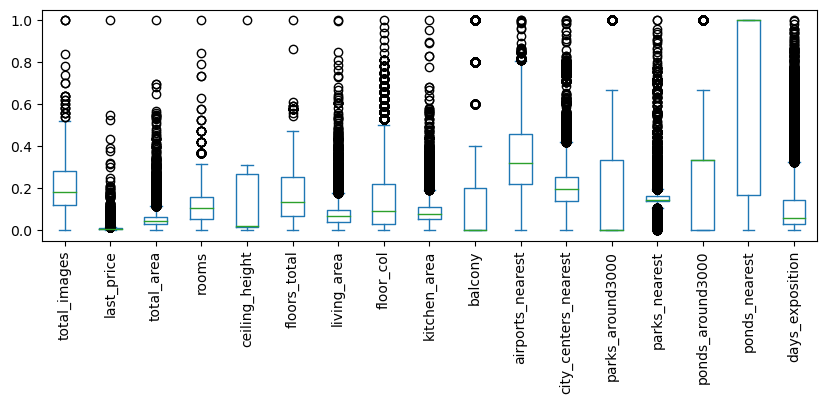

In [81]:
import matplotlib.pyplot as plt
def data_norm(data_to_norm):
    data_norm = pd.DataFrame()
    for clmn in [column for column in data_to_norm]:
        if (data_to_norm.dtypes[clmn] != 'object' and
            data_to_norm.dtypes[clmn] != 'bool' and
            data_to_norm.dtypes[clmn] != 'datetime64[ns]'):
            data_norm[clmn] = data_to_norm[clmn]

    data_norm = (data_norm-data_norm.min())/(data_norm.max()-data_norm.min())
    return data_norm
data_norm(data).plot(kind='box', figsize=(10,3),rot=90);

Видим, что практически все поля имеют данные за верхней частью межквартильного размаха. "Отрежем" для проверки верхние 3% (используем .quantile(0.97)) и посмотрим диаграму размаха:

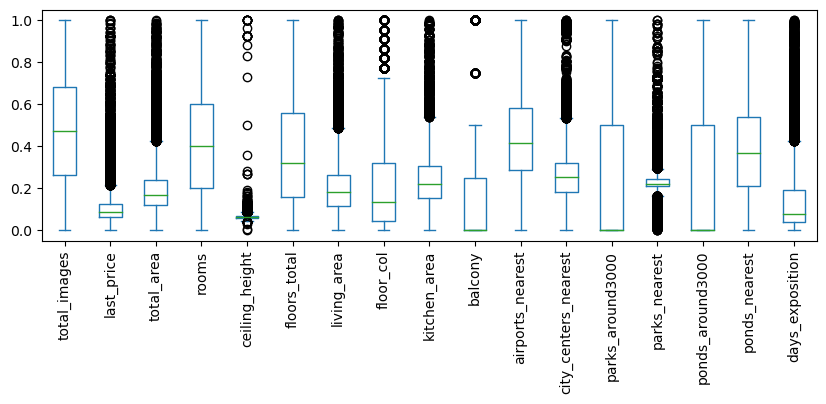

In [82]:
data_norm_filtred = data_norm(data)
quan = 0.995
data_norm_filtred = data_norm_filtred[
    ~data_norm_filtred[data_norm_filtred < data_norm_filtred.quantile(quan)].isna()]
data_norm_filtred = data_norm(data_norm_filtred)
data_norm_filtred.plot(kind='box', figsize=(10,3),rot=90);

Видим, что 3% убирают выбросы только в части полей. Найдем методом перебора уровень верхнего почти полного отсечения превышения межквартильного размаха

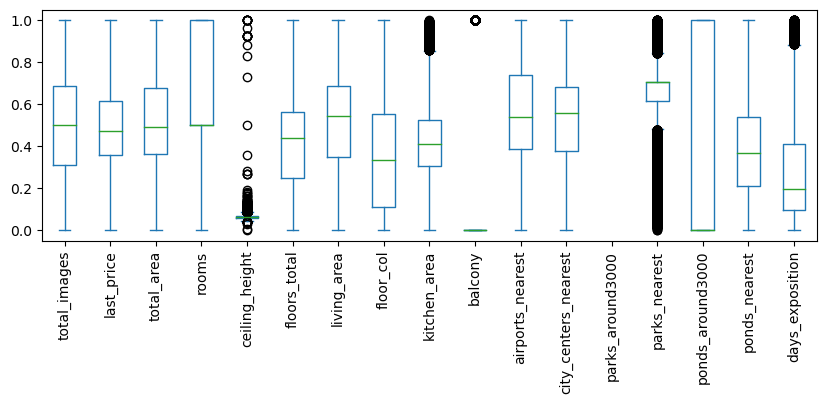

In [83]:
data_norm_filtred = data_norm(data)
quan = 0.86
data_norm_filtred = data_norm_filtred[
    ~data_norm_filtred[data_norm_filtred < data_norm_filtred.quantile(quan)].isna()]
data_norm_filtred = data_norm(data_norm_filtred)
data_norm_filtred.plot(kind='box', figsize=(10,3),rot=90);

Получаем уровень отсечений 0.9 который убирает верхние выбросы во всех полях, кроме last_price, city_centrs_nearest, days_exposition. В полях last_price, city_centrs_nearest верхние выбросы полностью отсекаются 0.86 квантилем. В поле days_exposition - уровнем 0,79. В поле ceiling_height имеются выбросы в нижней части значений.

Воспользуемся созданными выше функциями для оценки того, как распределены значения полей таблицы для верхней части полей last_price, city_centrs_nearest, days_exposition.

Для верних значений поля last_price проверим распределение значений в полях total_area, rooms, ceiling_height, city_centers_nearest. Возможно, большие цены соответствуют объектам с большой площадью, с большим количество комнат и высокими потолками в центре. Посмотрим last_price>0.99 квантиля. Для наглядности будем смотреть доли интервалов как отношение корзины не к общему числу строк в датафрейме, а к количеству строк в выбранном сегменте (last_price>0.99), для этого установим значение переменной cond_count_use=True

### last_price

In [84]:
panni = 10              # количество корзин
qmx =  1                # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
condition = '@cond_clmn > @cond_clmn.quantile(0.99)'          # условие отбора в базовых полях
simple = False          # False - используем условие отбора в базовых полях
top = 2                 # количество Топ корзин разбиения
                        # список базовых полей
b_list = ['last_price'] 
b_list_use = True       # использовать / нет список базовых полей
                        # список расчетных полей
c_list = ['last_price','total_area', 'rooms', 'ceiling_height', 'city_centers_nearest']
c_list_use = True       # использовать / нет список расчетных полей
cond_count_use = True   # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк
#-------------------------------------------------------------------
fract_table_outliers = condition_depend(panni,qmx,qmn,condition,simple, # таблица с интервалами (корзинами) распределений
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,cond_count_use)
cutoff = 0.0
cond_conc_outliers = condition_concentrate(cutoff,simple,top,
                                            fract_table_outliers,  # не заывать ставить правильное имя
                                            df,b_list,b_list_use)

print('fract_table_outliers: таблица с интервалами (корзинами) распределений')
display(fract_table_outliers)
print('Максимальная общая площадь: ',data['total_area'].max())
print('Максимальное количество комнат: ',data['rooms'].max())
print('Максимальная высота потолков: ',data['ceiling_height'].max())
print('Медианное растояние до центра в выбранном сегменте: ',
      data.query('last_price > last_price.quantile(0.99)')['city_centers_nearest'].median())

#print('cond_conc_outliers: таблица с суммами топ корзин')
#display(cond_conc_outliers) # таблица с суммами топ корзин

fract_table_outliers: таблица с интервалами (корзинами) распределений


,"(last_price, last_price_int)","(last_price, last_price_cnt)","(last_price, total_area_int)","(last_price, total_area_cnt)","(last_price, rooms_int)","(last_price, rooms_cnt)","(last_price, ceiling_height_int)","(last_price, ceiling_height_cnt)","(last_price, city_centers_nearest_int)","(last_price, city_centers_nearest_cnt)"
0,"(36001899.0, 108701709.1]",0.843220,"(54.3, 138.87]",0.177966,"(-1.0, 0.6]",0.004237,"(1.5, 4.086]",0.588983,"(317.0, 3698.5]",0.271186
1,"(108701709.1, 181401519.2]",0.114407,"(138.87, 223.44]",0.440678,"(0.6, 2.2]",0.080508,"(4.086, 6.671]",0.063559,"(3698.5, 7080.0]",0.576271
2,"(181401519.2, 254101329.3]",0.016949,"(223.44, 308.01]",0.211864,"(2.2, 3.8]",0.288136,"(6.671, 9.257]",0.000000,"(7080.0, 10461.5]",0.097458
3,"(254101329.3, 326801139.4]",0.008475,"(308.01, 392.58]",0.067797,"(3.8, 5.4]",0.427966,"(9.257, 11.842]",0.000000,"(10461.5, 13843.0]",0.038136
4,"(326801139.4, 399500949.5]",0.004237,"(392.58, 477.15]",0.042373,"(5.4, 7.0]",0.161017,"(11.842, 14.428]",0.000000,"(13843.0, 17224.5]",0.008475
5,"(399500949.5, 472200759.6]",0.008475,"(477.15, 561.72]",0.038136,"(7.0, 8.6]",0.016949,"(14.428, 17.013]",0.000000,"(17224.5, 20606.0]",0.000000
6,"(472200759.6, 544900569.7]",0.000000,"(561.72, 646.29]",0.016949,"(8.6, 10.2]",0.012712,"(17.013, 19.599]",0.000000,"(20606.0, 23987.5]",0.000000
7,"(544900569.7, 617600379.8]",0.000000,"(646.29, 730.86]",0.000000,"(10.2, 11.8]",0.000000,"(19.599, 22.184]",0.000000,"(23987.5, 27369.0]",0.000000
8,"(617600379.8, 690300189.9]",0.000000,"(730.86, 815.43]",0.000000,"(11.8, 13.4]",0.004237,"(22.184, 24.77]",0.000000,"(27369.0, 30750.5]",0.004237
9,"(690300189.9, 763000000.0]",0.004237,"(815.43, 900.0]",0.004237,"(13.4, 15.0]",0.004237,"(24.77, 27.355]",0.347458,"(30750.5, 34132.0]",0.004237


Максимальная общая площадь:  900.0
Максимальное количество комнат:  19
Максимальная высота потолков:  100.0
Медианное растояние до центра в выбранном сегменте:  5297.0


Основная часть из 1% самой дорогой недвижимости имеет вполне понятные соответствующие своей высокой цене характеристики: располложение в центре (медиана- 5.3 км), большую площадь - 2/3 дорогих квартир от 139 до 308 м.кв., от 3 до 5 комнат.

Самая дорогая часть сегмента занимает в нем всего 0,4%


In [85]:
data[data['last_price']>181500949][['last_price','total_area',
                                    'rooms', 'ceiling_height', 'city_centers_nearest','locality_name']]

,last_price,total_area,rooms,ceiling_height,city_centers_nearest,locality_name
1436,330000000.0,190.0,3,3.500,1197.0,Санкт-Петербург
5893,230000000.0,500.0,6,27.355,5297.0,Санкт-Петербург
8900,190870000.0,268.0,3,27.355,5297.0,Санкт-Петербург
12971,763000000.0,400.0,7,27.355,3956.0,Санкт-Петербург
13749,240000000.0,410.0,6,3.400,5297.0,Санкт-Петербург
14706,401300000.0,401.0,5,27.355,2389.0,Санкт-Петербург
15651,300000000.0,618.0,7,3.400,5297.0,Санкт-Петербург
16461,245000000.0,285.7,6,3.350,6235.0,Санкт-Петербург
19540,420000000.0,900.0,12,2.800,7877.0,Санкт-Петербург
22831,289238400.0,187.5,2,3.370,1073.0,Санкт-Петербург


Фактически, данные значения цен являются аномальными в данном датафрейме, но при этом они не являются некорректными. Это просто очень дорогая недвижимость. Удалять эти данные из датасета, считаю - неправильно. Правильнее использовать применнную выше фильтрацию.

Но тем не менее уберем верхний 1% данных по полую last_price из датасета. Предварительно сохраним исходное количество строк датасета, и посмотрим нижние выбросы в поле цен.

In [86]:
# data = data.query('last_price < last_price.quantile(0.99)')
print('Исходное количество строк в датасете:',old_data_count)
#print('Новое количество строк: ',data.shape[0])

Исходное количество строк в датасете: 23699


Посмотрим нижние выбросы данных по ценам

In [87]:
panni = 10              # количество корзин
qmx =  1                # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
condition = '@cond_clmn < @cond_clmn.quantile(0.01)'          # условие отбора в базовых полях
simple = False          # False - используем условие отбора в базовых полях
top = 2                 # количество Топ корзин разбиения
                        # список базовых полей
b_list = ['last_price'] 
b_list_use = True       # использовать / нет список базовых полей
                        # список расчетных полей
c_list = ['last_price','total_area', 'rooms','floor_col','floors_total',
          'ceiling_height','city_centers_nearest','locality_name']
c_list_use = True       # использовать / нет список расчетных полей
cond_count_use = True   # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк
#-------------------------------------------------------------------
fract_table_outliers = condition_depend(panni,qmx,qmn,condition,simple, # таблица с интервалами (корзинами) распределений
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,cond_count_use)
cutoff = 0.0
cond_conc_outliers = condition_concentrate(cutoff,simple,top,
                                            fract_table_outliers,  # не заывать ставить правильное имя
                                            df,b_list,b_list_use)

print('fract_table_outliers: таблица с интервалами (корзинами) распределений')
display(fract_table_outliers)
print('Минимальная общая площадь: ',data['total_area'].min())
print('Минимальное количество комнат: ',data['rooms'].min())
print('Минимальная высота потолков: ',data['ceiling_height'].min())
print('Медианное растояние до центра в выбранном сегменте: ',
      data.query('last_price < last_price.quantile(0.01)')['city_centers_nearest'].median())

fract_table_outliers: таблица с интервалами (корзинами) распределений


,"(last_price, last_price_int)","(last_price, last_price_cnt)","(last_price, total_area_int)","(last_price, total_area_cnt)","(last_price, rooms_int)","(last_price, rooms_cnt)","(last_price, ceiling_height_int)","(last_price, ceiling_height_cnt)","(last_price, floors_total_int)","(last_price, floors_total_cnt)","(last_price, floor_col_int)","(last_price, floor_col_cnt)","(last_price, city_centers_nearest_int)","(last_price, city_centers_nearest_cnt)","(last_price, locality_name_int)","(last_price, locality_name_cnt)"
0,"(12189.0, 110970.0]",0.004444,"(17.0, 26.2]",0.022222,"(-1.0, 0.0]",0.004444,"(1.5, 4.086]",0.386667,"(0.0, 3.571]",0.382222,"(0.0, 3.125]",0.693333,"(9175.0, 9176.0]",1.0,Сланцы,0.368889
1,"(110970.0, 209751.0]",0.000000,"(26.2, 35.4]",0.315556,"(0.0, 1.0]",0.444444,"(4.086, 6.671]",0.004444,"(3.571, 7.143]",0.582222,"(3.125, 6.25]",0.284444,NaN,NaN,Бокситогорск,0.062222
2,"(209751.0, 308532.0]",0.000000,"(35.4, 44.6]",0.324444,"(1.0, 2.0]",0.422222,"(6.671, 9.257]",0.000000,"(7.143, 10.714]",0.031111,"(6.25, 9.375]",0.017778,NaN,NaN,Пикалёво,0.048889
3,"(308532.0, 407313.0]",0.000000,"(44.6, 53.8]",0.186667,"(2.0, 3.0]",0.124444,"(9.257, 11.842]",0.000000,"(10.714, 14.286]",0.000000,"(9.375, 12.5]",0.000000,NaN,NaN,Ивангород,0.022222
4,"(407313.0, 506094.0]",0.075556,"(53.8, 63.0]",0.120000,"(3.0, 4.0]",0.004444,"(11.842, 14.428]",0.000000,"(14.286, 17.857]",0.000000,"(12.5, 15.625]",0.000000,NaN,NaN,поселок городского типа Вырица,0.017778
5,"(506094.0, 604875.0]",0.115556,"(63.0, 72.2]",0.017778,NaN,NaN,"(14.428, 17.013]",0.000000,"(17.857, 21.429]",0.000000,"(15.625, 18.75]",0.000000,NaN,NaN,Луга,0.017778
6,"(604875.0, 703656.0]",0.155556,"(72.2, 81.4]",0.004444,NaN,NaN,"(17.013, 19.599]",0.000000,"(21.429, 25.0]",0.004444,"(18.75, 21.875]",0.000000,NaN,NaN,Кириши,0.017778
7,"(703656.0, 802437.0]",0.200000,"(81.4, 90.6]",0.004444,NaN,NaN,"(19.599, 22.184]",0.000000,NaN,NaN,"(21.875, 25.0]",0.004444,NaN,NaN,Выборг,0.017778
8,"(802437.0, 901218.0]",0.235556,"(90.6, 99.8]",0.000000,NaN,NaN,"(22.184, 24.77]",0.000000,NaN,NaN,NaN,NaN,NaN,NaN,поселок городского типа Никольский,0.017778
9,"(901218.0, 999999.0]",0.213333,"(99.8, 109.0]",0.004444,NaN,NaN,"(24.77, 27.355]",0.608889,NaN,NaN,NaN,NaN,NaN,NaN,поселок городского типа Ефимовский,0.013333


Минимальная общая площадь:  12.0
Минимальное количество комнат:  0
Минимальная высота потолков:  1.0
Медианное растояние до центра в выбранном сегменте:  9176.0


Посмотрим цены ниже 507000 р.

In [88]:
data[data['last_price']<507000][['last_price','total_area','living_area','rooms','floor_col','floors_total',
                                 'ceiling_height', 'city_centers_nearest','locality_name']]

,last_price,total_area,living_area,rooms,floor_col,floors_total,ceiling_height,city_centers_nearest,locality_name
2097,500000.0,30.7,15.100,1,2,2.0,27.355,NaN,деревня Чудской Бор
4405,500000.0,52.0,31.000,2,1,2.0,2.700,NaN,Сланцы
5698,450000.0,42.0,23.000,2,1,1.0,27.355,NaN,поселок городского типа Будогощь
6859,490000.0,40.0,27.355,1,3,5.0,27.355,NaN,деревня Старополье
8793,12190.0,109.0,32.000,2,25,25.0,2.750,9176.0,Санкт-Петербург
9581,450000.0,43.4,30.300,2,3,5.0,27.355,NaN,деревня Старополье
10782,490000.0,29.1,17.000,1,5,5.0,2.500,NaN,Сланцы
14295,500000.0,34.0,17.000,1,4,5.0,27.355,NaN,поселок городского типа Никольский
14904,500000.0,38.0,27.355,1,3,3.0,27.355,NaN,деревня Бор
14911,430000.0,54.0,27.355,2,3,3.0,27.355,NaN,поселок при железнодорожной станции Свирь


Самый дешевый 1% недвижимости также соответствует своим характеристикам. Это пригороды (36% - Сланцы), 3-х и 5-ти этажки.

Одно значение цены 12190.0 явно некорректное. Вопрос- на 2 или на 3 порядка цена меньше фактической. Посмотрим аналогичные по характеристикам (жилая площадь, удаленность от центра, комнаты, этаж) (+-%%) объекты.

In [89]:
data[(32*0.7<data['living_area']) &
     (data['living_area']<32*1.3) &
     (9176.0*0.9<data['city_centers_nearest']) &
     (data['city_centers_nearest']<9176.0*1.1) &
     (data['rooms']==2) & (data['floor_col']>21)][['last_price','total_area','living_area',
                                                   'rooms','floor_col','floors_total',
                                 'ceiling_height', 'city_centers_nearest','locality_name']]

,last_price,total_area,living_area,rooms,floor_col,floors_total,ceiling_height,city_centers_nearest,locality_name
8761,12998000.0,91.0,24.000000,2,24,25.0,2.80,8479.0,Санкт-Петербург
8793,12190.0,109.0,32.000000,2,25,25.0,2.75,9176.0,Санкт-Петербург
12998,9500000.0,74.0,35.000000,2,24,25.0,2.85,9289.0,Санкт-Петербург
17524,6775000.0,62.0,26.599998,2,23,25.0,2.68,9681.0,Санкт-Петербург


Схожих объектов 4 штуки. Порядок цен понятен. Умножаем цену объекта с индексом 8793 на 1000

In [90]:
data.at[8793,'last_price']=data.loc[8793,'last_price']*1000
data.loc[8793,'last_price']

12190000.0

Посмотрим диаграмму размаха отдельно для поля цен.

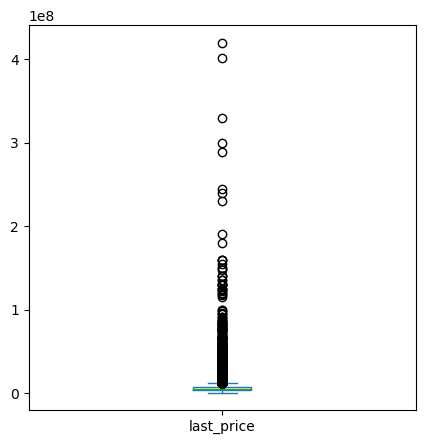

In [92]:
min_q = 0
max_q = 1
# 
(data.query('last_price > last_price.quantile(@min_q) and last_price < last_price.quantile(@max_q)')
 ['last_price'].plot(kind='box', figsize=(5,5)));

Видим большое количество верхних выбросов. Причем выделяются отдельные экземпляры данных. Найдем минимальный процент верхнего отсечения, при котором полоса данных выше межквартильного размаха будет однородной, без выделяющихся экземпляров.

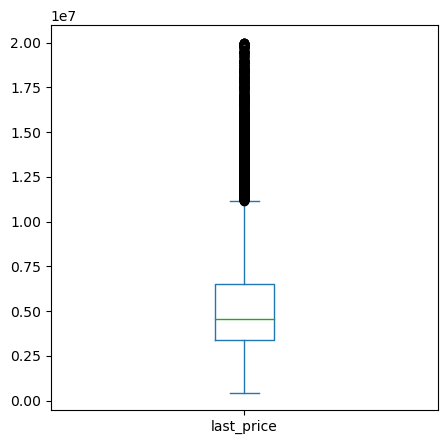

In [94]:
min_q = 0
max_q = 0.97
# 
(data.query('last_price > last_price.quantile(@min_q) and last_price < last_price.quantile(@max_q)')
 ['last_price'].plot(kind='box', figsize=(5,5)));

Видим, что отсечение верхних 3%. Приводит к нашей цели. При этом в нижней части диаграммы выбросов не наблюдается. Таким образом удалим из датафрейма 3% верхних по цене данных.

In [95]:
data = data.query('last_price < last_price.quantile(0.97)')
print('Исходный датафрейм уменьшен на: ',(data.shape[0]-old_data_count)/old_data_count)

Исходный датафрейм уменьшен на:  -0.03050761635512047


### Посмотрим на потолки. Отберем верхние 40%

In [96]:
panni = 20              # количество корзин
qmx =  1                # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
                        # условие отбора в базовых полях
condition = '@cond_clmn > @cond_clmn.quantile(0.6)'
simple = False          # False - используем условие отбора в базовых полях
top = 2                 # количество Топ корзин разбиения
                        # список базовых полей
b_list = ['ceiling_height'] 
b_list_use = True       # использовать / нет список базовых полей
                        # список расчетных полей
c_list = ['rooms','floor_col','floors_total',
          'ceiling_height']
c_list_use = True       # использовать / нет список расчетных полей
cond_count_use = True   # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк
#-------------------------------------------------------------------
fract_table_outliers = condition_depend(panni,qmx,qmn,condition,simple, # таблица с интервалами (корзинами) распределений
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,cond_count_use)
cutoff = 0.0
cond_conc_outliers = condition_concentrate(cutoff,simple,top,
                                            fract_table_outliers,  # не заывать ставить правильное имя
                                            df,b_list,b_list_use)

print('fract_table_outliers: таблица с интервалами (корзинами) распределений')
display(fract_table_outliers)

fract_table_outliers: таблица с интервалами (корзинами) распределений


,"(ceiling_height, rooms_int)","(ceiling_height, rooms_cnt)","(ceiling_height, ceiling_height_int)","(ceiling_height, ceiling_height_cnt)","(ceiling_height, floors_total_int)","(ceiling_height, floors_total_cnt)","(ceiling_height, floor_col_int)","(ceiling_height, floor_col_cnt)"
0,"(-1.0, 0.0]",0.012744,"(2.56, 7.432]",0.019824,"(0.0, 1.8]",0.001961,"(0.0, 1.65]",0.121011
1,"(0.0, 1.0]",0.377737,"(7.432, 12.304]",0.000545,"(1.8, 3.6]",0.050212,"(1.65, 3.3]",0.264895
2,"(1.0, 2.0]",0.340050,"(12.304, 17.176]",0.000109,"(3.6, 5.4]",0.284501,"(3.3, 4.95]",0.109356
3,"(2.0, 3.0]",0.218059,"(17.176, 22.048]",0.000109,"(5.4, 7.2]",0.054134,"(4.95, 6.6]",0.158044
4,"(3.0, 4.0]",0.038013,"(22.048, 26.92]",0.001089,"(7.2, 9.0]",0.145627,"(6.6, 8.25]",0.092365
5,"(4.0, 5.0]",0.009367,"(26.92, 31.792]",0.977998,"(9.0, 10.8]",0.045202,"(8.25, 9.9]",0.044222
6,"(5.0, 6.0]",0.002505,"(31.792, 36.664]",0.000218,"(10.8, 12.6]",0.065135,"(9.9, 11.55]",0.055223
7,"(6.0, 7.0]",0.001198,"(36.664, 41.536]",0.000000,"(12.6, 14.4]",0.035399,"(11.55, 13.2]",0.042915
8,"(7.0, 8.0]",0.000218,"(41.536, 46.408]",0.000000,"(14.4, 16.2]",0.070036,"(13.2, 14.85]",0.017645
9,"(8.0, 9.0]",0.000109,"(46.408, 51.28]",0.000000,"(16.2, 18.0]",0.060778,"(14.85, 16.5]",0.032023


Некорректные некорректные данные могут быть из-за неправильного порядка цифр. Видим в распределении интервалы от 17.1 до 36.6 м., которые явно неправильно записаны. Поделим эти значения на 10.

In [97]:
idx = data.query('ceiling_height >= 17 and ceiling_height < 40').index
data.loc[idx,'ceiling_height']=data.loc[idx,'ceiling_height']/10

Основная часть высоких потолков в интервале от 3.6 м. При этом объекты расположены на разных этажах. Допустимыми (корректными) считаю значения до 5 метров на первых этажах, либо для недвижимости большой площади (нетиповой планировки).

In [98]:
data[(data['ceiling_height']>=5)][['last_price','total_area','rooms','floor_col','floors_total',
                                              'ceiling_height','city_centers_nearest','locality_name']]

,last_price,total_area,rooms,floor_col,floors_total,ceiling_height,city_centers_nearest,locality_name
1053,550000.0,29.0,1,1,3.0,5.0,NaN,Бокситогорск
3474,1400000.0,30.0,1,2,5.0,8.0,NaN,деревня Нурма
5863,5650000.0,45.0,1,14,16.0,8.3,10763.0,Санкт-Петербург
12628,3900000.0,50.0,1,5,5.0,5.3,3918.0,Санкт-Петербург
15061,5600000.0,56.4,2,5,14.0,14.0,13610.0,Санкт-Петербург
15743,5600000.0,67.0,3,1,16.0,8.0,11035.0,Санкт-Петербург
17442,5350000.0,54.0,2,2,5.0,8.0,28062.0,Красное Село
21227,8200000.0,71.0,0,5,5.0,5.8,1261.0,Санкт-Петербург
22309,5300000.0,45.0,1,15,16.0,10.3,11936.0,Санкт-Петербург
22869,15000000.0,25.0,1,5,5.0,100.0,8283.0,Санкт-Петербург


Удалим некорректные значения. После посмотрим объекты выше 5 метров

In [99]:
data =data.drop(data.query('ceiling_height >= 5 and floor_col != 1 and total_area < 100').index)

# посмотрим объекты выше 5 метров
data[(data['ceiling_height']>=5)][['last_price','total_area','rooms','floor_col','floors_total',
                                              'ceiling_height','city_centers_nearest','locality_name']]

,last_price,total_area,rooms,floor_col,floors_total,ceiling_height,city_centers_nearest,locality_name
1053,550000.0,29.0,1,1,3.0,5.0,NaN,Бокситогорск
15743,5600000.0,67.0,3,1,16.0,8.0,11035.0,Санкт-Петербург


С оставшимися объектами ничего делать не будем.

Теперь посмотрим 10 первых строк для нижних 1% потолков

In [100]:
data.query('ceiling_height < ceiling_height.quantile(0.01)')[flat_list+terr_list].sort_values(by='ceiling_height').head(10)

,balcony,rooms,floor_col,floors_total,ceiling_height,kitchen_area,living_area,total_area,ponds_around3000,parks_around3000,parks_nearest,ponds_nearest,city_centers_nearest,airports_nearest,locality_name
22590,0.0,2,7,12.0,1.00,10.000,32.400,55.0,2.0,2.0,293.0,289.0,14217.0,33053.0,Санкт-Петербург
5712,0.0,2,1,2.0,1.20,5.200,27.500,42.8,NaN,NaN,NaN,NaN,NaN,NaN,поселок городского типа Мга
16934,0.0,1,5,37.0,1.75,8.340,17.400,40.0,3.0,0.0,460.0,80.0,20444.0,18732.0,Санкт-Петербург
5850,0.0,1,5,5.0,2.00,27.355,27.355,35.5,NaN,NaN,NaN,NaN,NaN,NaN,Луга
22960,0.0,2,1,2.0,2.00,10.000,19.000,53.6,NaN,NaN,NaN,NaN,NaN,NaN,Всеволожск
552,0.0,1,6,15.0,2.00,6.500,17.500,33.5,1.0,1.0,520.0,949.0,11746.0,33972.0,Санкт-Петербург
20520,1.0,1,9,12.0,2.00,11.800,15.000,38.0,NaN,NaN,NaN,NaN,NaN,NaN,деревня Кудрово
11352,0.0,1,12,17.0,2.00,10.100,15.200,36.0,0.0,0.0,650.4,3000.0,26980.0,25268.0,поселок Металлострой
19329,0.0,2,8,9.0,2.00,27.355,27.355,40.0,NaN,NaN,NaN,NaN,NaN,NaN,Сосновый Бор
19098,0.0,3,1,5.0,2.00,6.000,46.000,56.0,NaN,NaN,NaN,NaN,NaN,NaN,Выборг


Удалим объекты спотолками менее 2м как некорректные

In [101]:
data=data.query('ceiling_height >= 2')

Посмотрим выбросы в других полях

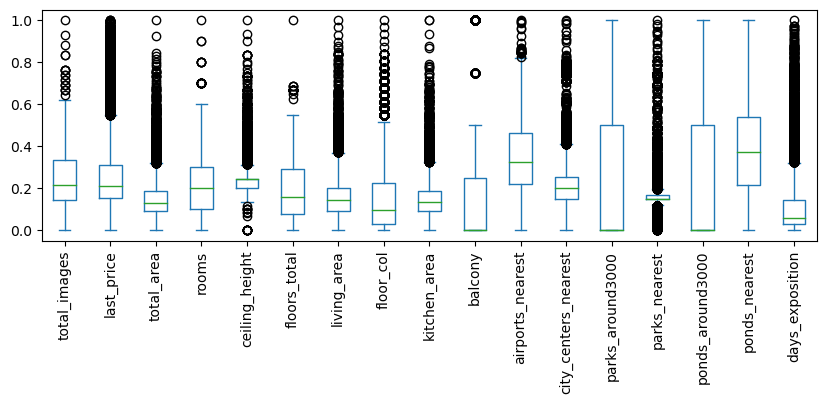

In [102]:
data_norm_filtred = data_norm(data)
quan = 1
data_norm_filtred = data_norm_filtred[
    ~data_norm_filtred[data_norm_filtred < data_norm_filtred.quantile(quan)].isna()]
data_norm_filtred = data_norm(data_norm_filtred)
data_norm_filtred.plot(kind='box', figsize=(10,3),rot=90);

### Рассмотрим верхний процент данных в поле rooms

In [103]:
data.query('rooms > rooms.quantile(0.99)').groupby('rooms')['rooms'].count()

rooms
6     58
7     21
8      5
9      2
10     1
11     1
Name: rooms, dtype: int64

In [104]:
# посмотрим объекты с количество комнат от 11 и быше
x_list = ['last_price','is_apartment']
data.query('rooms > 7')[flat_list+x_list]

,balcony,rooms,floor_col,floors_total,ceiling_height,kitchen_area,living_area,total_area,last_price,is_apartment
648,0.0,11,7,7.0,3.4000,13.300,138.800,183.7,17500000.0,True
813,0.0,8,5,6.0,2.7355,25.000,160.000,229.0,16500000.0,True
8758,0.0,8,1,5.0,2.9200,7.200,107.000,150.0,16100000.0,True
8860,0.0,9,3,6.0,3.0000,27.355,27.355,235.0,17000000.0,True
12447,0.0,8,2,5.0,3.3000,23.600,144.600,210.3,19900000.0,True
13397,0.0,9,5,5.0,2.7355,14.300,199.000,309.7,19500000.0,True
18119,0.0,10,2,5.0,3.1500,19.800,161.400,216.1,15500000.0,True
18945,0.0,8,6,6.0,2.7355,22.600,176.600,236.4,15800000.0,True
20788,0.0,8,2,5.0,3.5400,27.355,155.000,245.0,18000000.0,True


Видим, что все объекты являются аппартаментами (хостелы?). Т.е. являясь выбросом в данных эти значения - корректные.

Тем не менее удалим эти данные

In [105]:
data = data.query('rooms < 8')
print('Исходный датафрейм в итоге уменьшен на: ',(data.shape[0]-old_data_count)/old_data_count)

Исходный датафрейм в итоге уменьшен на:  -0.03135153381999241


### Рассмотрим верхний процент данных в поле total_area

In [106]:
x_list = ['last_price','city_centers_nearest','locality_name']
data.query('total_area > total_area.quantile(0.99)')[flat_list+x_list].sort_values(by='total_area',
                                                                ascending=False).head(10)

,balcony,rooms,floor_col,floors_total,ceiling_height,kitchen_area,living_area,total_area,last_price,city_centers_nearest,locality_name
11087,0.0,6,3,3.0,2.7355,28.00,190.000,320.00,14000000.0,29445.0,Красное Село
22238,0.0,7,3,4.0,2.7355,26.00,183.700,287.50,19500000.0,4726.0,Санкт-Петербург
9397,0.0,3,4,19.0,2.7355,23.42,27.355,263.80,16073000.0,4400.0,Санкт-Петербург
12067,0.0,5,16,17.0,2.8100,15.40,148.600,259.60,14500000.0,11111.0,Санкт-Петербург
2489,0.0,3,2,2.0,2.7355,100.70,153.900,255.00,12500000.0,6916.0,Санкт-Петербург
13931,0.0,5,16,17.0,2.5000,21.00,119.000,250.00,14300000.0,11144.0,Санкт-Петербург
7729,0.0,7,2,6.0,3.3200,25.30,166.700,248.00,16000000.0,3147.0,Санкт-Петербург
11364,0.0,5,2,5.0,3.5500,12.00,154.000,239.00,17900000.0,4726.0,Санкт-Петербург
19964,0.0,3,4,19.0,2.7355,10.20,27.355,238.26,13545000.0,4579.0,Санкт-Петербург
8333,0.0,6,4,5.0,2.7355,42.00,165.500,237.00,19700000.0,3791.0,Санкт-Петербург


Посмотрим диаграмму размаха и определим процент отсечения, при котором не будут выделятся отдельные данные в верхней части

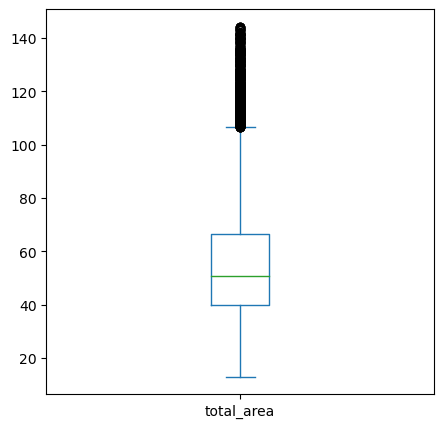

In [108]:
min_q = 0
max_q = 0.99
# 
(data.query('total_area > total_area.quantile(@min_q) and total_area < total_area.quantile(@max_q)')
 ['total_area'].plot(kind='box', figsize=(5,5)));

При отсечении верхнего 1% данных полоса данных выше межквартильного размаха стала однородной, без выделяющихся экземпляров. Полное удаление выбросов - при 5% отсечении сверху.

Посмотрим распределение других полей для большой площади (1% верхних данных)

In [109]:
x_list = ['last_price','city_centers_nearest','locality_name','total_area']
panni = 10              # количество корзин
qmx =  1                # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
                        # условие отбора в базовых полях
condition = '@cond_clmn > @cond_clmn.quantile(0.99)'
simple = False          # False - используем условие отбора в базовых полях
top = 2                 # количество Топ корзин разбиения
                        # список базовых полей
b_list = ['total_area'] 
b_list_use = True       # использовать / нет список базовых полей
                        # список расчетных полей
c_list = x_list
c_list_use = True       # использовать / нет список расчетных полей
cond_count_use = True   # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк
#-------------------------------------------------------------------
fract_table_outliers = condition_depend(panni,qmx,qmn,condition,simple, # таблица с интервалами (корзинами) распределений
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,cond_count_use)
cutoff = 0.0
cond_conc_outliers = condition_concentrate(cutoff,simple,top,
                                            fract_table_outliers,  # не заывать ставить правильное имя
                                            df,b_list,b_list_use)

print('fract_table_outliers: таблица с интервалами (корзинами) распределений')
display(fract_table_outliers)

fract_table_outliers: таблица с интервалами (корзинами) распределений


,"(total_area, last_price_int)","(total_area, last_price_cnt)","(total_area, total_area_int)","(total_area, total_area_cnt)","(total_area, city_centers_nearest_int)","(total_area, city_centers_nearest_cnt)","(total_area, locality_name_int)","(total_area, locality_name_cnt)"
0,"(3199999.0, 4878999.1]",0.013043,"(143.8, 161.42]",0.473913,"(422.0, 5844.4]",0.638009,Санкт-Петербург,0.882096
1,"(4878999.1, 6557999.2]",0.004348,"(161.42, 179.04]",0.221739,"(5844.4, 11266.8]",0.117647,Пушкин,0.021834
2,"(6557999.2, 8236999.3]",0.013043,"(179.04, 196.66]",0.134783,"(11266.8, 16689.2]",0.108597,Выборг,0.013100
3,"(8236999.3, 9915999.4]",0.034783,"(196.66, 214.28]",0.091304,"(16689.2, 22111.6]",0.045249,Сестрорецк,0.008734
4,"(9915999.4, 11594999.5]",0.047826,"(214.28, 231.9]",0.030435,"(22111.6, 27534.0]",0.022624,деревня Новое Девяткино,0.008734
5,"(11594999.5, 13273999.6]",0.156522,"(231.9, 249.52]",0.021739,"(27534.0, 32956.4]",0.031674,поселок Стрельна,0.008734
6,"(13273999.6, 14952999.7]",0.182609,"(249.52, 267.14]",0.017391,"(32956.4, 38378.8]",0.018100,Павловск,0.008734
7,"(14952999.7, 16631999.8]",0.213043,"(267.14, 284.76]",0.000000,"(38378.8, 43801.2]",0.009050,поселок Александровская,0.004367
8,"(16631999.8, 18310999.9]",0.195652,"(284.76, 302.38]",0.004348,"(43801.2, 49223.6]",0.000000,Петергоф,0.004367
9,"(18310999.9, 19990000.0]",0.139130,"(302.38, 320.0]",0.004348,"(49223.6, 54646.0]",0.009050,Гатчина,0.004367


Видим, что большие квартиры как и в случае с ценой, являясь выбросами в данных, в то же время- корректны.

Тем не менее удалим эти данные

In [110]:
data = data.query('total_area < total_area.quantile(0.99)')
print('Исходный датафрейм в итоге уменьшен на: ',(data.shape[0]-old_data_count)/old_data_count)

Исходный датафрейм в итоге уменьшен на:  -0.04105658466601966


### Для полей floor_col froors_total

проведем сравнение. Очевидно, этажность дома не должна быть больше этажа квартиры. Также посмотрим на объекты на 60 этаже

In [111]:
data.query('floor_col > floors_total')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor_col,is_apartment,...,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,first_day_exposition_date


In [112]:
data.query('floors_total > floors_total.quantile(0.99)')[flat_list+x_list].sort_values(by='floors_total',
                                                                        ascending=False).head(10)

,balcony,rooms,floor_col,floors_total,ceiling_height,kitchen_area,living_area,total_area,last_price,city_centers_nearest,locality_name,total_area
2253,0.0,2,4,60.0,2.8800,7.4,27.4,45.5,3800000.0,49488.0,Кронштадт,45.5
16731,0.0,1,18,52.0,2.6500,14.0,10.5,40.0,3978000.0,12978.0,Санкт-Петербург,40.0
397,1.0,2,28,36.0,2.7355,18.7,21.4,54.0,5990000.0,20444.0,Санкт-Петербург,54.0
11079,2.0,2,29,36.0,2.7000,12.0,40.0,75.0,9200000.0,20444.0,Санкт-Петербург,75.0
5807,5.0,2,13,36.0,2.7000,12.0,41.0,80.0,8150000.0,20444.0,Санкт-Петербург,80.0
4855,0.0,1,4,35.0,2.8000,13.0,22.0,50.0,5500000.0,20339.0,Санкт-Петербург,50.0
18617,1.0,2,3,35.0,2.7355,23.0,27.0,68.5,7350000.0,20339.0,Санкт-Петербург,68.5
7236,2.0,1,12,35.0,2.7355,11.0,15.0,42.0,4599000.0,20444.0,Санкт-Петербург,42.0
18218,2.0,3,33,35.0,2.7355,13.7,53.4,101.0,9900000.0,20450.0,Санкт-Петербург,101.0
21599,0.0,2,13,35.0,2.7355,19.0,27.0,51.0,6200000.0,20444.0,Санкт-Петербург,51.0


"«Князь Александр Невский», построенный холдингом «РосСтройИнвест», на сегодняшний день является самым высоким жилым домом Санкт-Петербурга. Его высота составляет 126 м. Здание состоит из 37 этажей, два из которых подземные."

52 и 60 этажей- некорректное значение. Заменим их на floor_col

In [113]:
idx = data.query('floors_total > 37').index
data.loc[idx,'floors_total'] = data.loc[idx,'floor_col']

### Поля kitchen_area living_area должны быть меньше total_area

In [114]:
x_list = ['last_price','city_centers_nearest','locality_name']
data.query('kitchen_area > total_area')[flat_list+x_list].sort_values(by='total_area')

,balcony,rooms,floor_col,floors_total,ceiling_height,kitchen_area,living_area,total_area,last_price,city_centers_nearest,locality_name
19904,0.0,1,2,5.0,2.5500,27.355,10.000,12.00,2400000.0,964.0,Санкт-Петербург
19546,0.0,1,2,5.0,3.4000,27.355,27.355,13.00,1850000.0,5483.0,Санкт-Петербург
17961,0.0,1,1,9.0,2.6000,27.355,27.355,13.00,1400000.0,15945.0,Санкт-Петербург
19807,0.0,1,3,5.0,2.7355,27.355,10.000,13.00,3800000.0,1242.0,Санкт-Петербург
19558,0.0,1,1,5.0,2.7355,27.355,27.355,13.20,1686000.0,4165.0,Санкт-Петербург
...,...,...,...,...,...,...,...,...,...,...,...
22246,1.0,0,15,16.0,2.7000,27.355,23.300,27.30,3100000.0,9551.0,Санкт-Петербург
9208,0.0,1,6,17.0,2.7000,27.355,19.200,27.30,3145000.0,9014.0,Санкт-Петербург
7818,2.0,0,9,20.0,2.7355,27.355,27.355,27.30,3300000.0,13853.0,Санкт-Петербург
11157,0.0,0,5,8.0,2.8000,27.355,20.000,27.30,2900000.0,13729.0,Санкт-Петербург


Похоже, что данное расхождение - результат неправильного заполнения. Исправим это. Вычислим медиану доли кухни в общей площади (для корректных значений в интервале 12-28 м.кв. общей площади) и умножим эту медиану на общую площадь

In [115]:
cond = 'total_area >12 and total_area < 28 and (total_area - living_area)>0'
kitch_med = ((data.query(cond)['total_area']-data.query(cond)['living_area'])/data.query(cond)['total_area']).median()
idx = data.query('kitchen_area > total_area').index
data.loc[idx,'kitchen_area']=kitch_med*data.loc[idx,'total_area']

Сделаем то же самое для living_area

In [116]:
x_list = ['last_price','city_centers_nearest','locality_name']
data.query('living_area > total_area')[flat_list+x_list].sort_values(by='total_area')

,balcony,rooms,floor_col,floors_total,ceiling_height,kitchen_area,living_area,total_area,last_price,city_centers_nearest,locality_name
19546,0.0,1,2,5.0,3.4000,4.136364,27.355,13.00,1850000.0,5483.0,Санкт-Петербург
17961,0.0,1,1,9.0,2.6000,4.136364,27.355,13.00,1400000.0,15945.0,Санкт-Петербург
19558,0.0,1,1,5.0,2.7355,4.200000,27.355,13.20,1686000.0,4165.0,Санкт-Петербург
16949,0.0,1,1,9.0,2.7000,4.772727,27.355,15.00,1550000.0,16376.0,Санкт-Петербург
12040,0.0,1,1,5.0,2.5000,4.772727,27.355,15.00,1900000.0,NaN,Сосновый Бор
22356,0.0,1,1,23.0,2.7700,5.472727,27.355,17.20,2050000.0,13513.0,Санкт-Петербург
20714,0.0,1,4,4.0,2.7355,5.727273,27.355,18.00,1200000.0,NaN,Кировск
12881,0.0,1,5,5.0,2.7355,5.886364,27.355,18.50,1500000.0,NaN,Сосновый Бор
8454,0.0,0,2,6.0,3.0000,6.045455,27.355,19.00,2250000.0,7316.0,Санкт-Петербург
16991,2.0,1,18,22.0,2.7355,6.363636,27.355,20.00,1750000.0,21888.0,поселок Мурино


In [117]:
cond = 'total_area >=13 and total_area < 28 and (total_area - kitchen_area)>0'
liv_med = ((data.query(cond)['total_area']-data.query(cond)['kitchen_area'])/data.query(cond)['total_area']).median()
idx = data.query('living_area > total_area').index
data.loc[idx,'living_area']=kitch_med*data.loc[idx,'living_area']

Посмотрим выбросы в поле balcony. Отберем объекты в которых количество балконов больше количества комнат на 2 и больше, и площадь меньше 100.

In [118]:
data.query('(balcony - rooms)>1 and total_area  < 100')[flat_list+x_list].sort_values(by='balcony',ascending=False)

,balcony,rooms,floor_col,floors_total,ceiling_height,kitchen_area,living_area,total_area,last_price,city_centers_nearest,locality_name
41,5.0,3,8,14.0,2.7355,12.000000,59.00,74.0,7900000.0,12612.0,Санкт-Петербург
15136,5.0,1,5,10.0,2.6000,8.800000,25.90,46.6,4580000.0,11781.0,Санкт-Петербург
14964,5.0,3,5,25.0,2.8000,11.300000,55.20,87.1,10900000.0,15501.0,Санкт-Петербург
14947,5.0,2,5,16.0,2.5500,6.000000,24.50,41.0,3600000.0,6565.0,Санкт-Петербург
14939,5.0,3,2,5.0,2.5000,9.000000,41.00,66.3,1800000.0,NaN,поселок Глажево
...,...,...,...,...,...,...,...,...,...,...,...
9861,2.0,0,17,22.0,2.7355,7.954545,25.00,25.0,2350000.0,21888.0,поселок Мурино
4971,2.0,0,17,20.0,2.7355,27.355000,19.03,29.3,4300000.0,12554.0,Санкт-Петербург
5290,2.0,0,23,24.0,2.7355,7.636364,17.60,24.0,4090000.0,13417.0,Санкт-Петербург
16144,2.0,0,7,21.0,2.7355,7.095455,18.00,22.3,2500000.0,NaN,деревня Кудрово


Уменьшим количество балконов в такой выборке до количества комнат.

In [119]:
idx=data.query('(balcony - rooms)>1 and total_area  < 100').index
data.loc[idx,'balcony']=data.loc[idx,'rooms']

Посмотрим на объекты с 4 и 5 балконами на первых этажах

In [120]:
data.query('balcony >= 4 and floor_col == 1')[flat_list+x_list].sort_values(by='balcony',ascending=False)

,balcony,rooms,floor_col,floors_total,ceiling_height,kitchen_area,living_area,total_area,last_price,city_centers_nearest,locality_name
2624,5.0,4,1,9.0,2.6000,9.80,54.50,77.80,5850000.0,17073.0,Санкт-Петербург
8728,5.0,3,1,4.0,2.9000,25.00,45.00,121.00,7800000.0,NaN,Всеволожск
9986,5.0,3,1,4.0,3.0000,24.50,57.40,125.00,7600000.0,35051.0,Сестрорецк
16959,5.0,4,1,10.0,2.5500,21.90,60.10,107.20,6150000.0,34231.0,Колпино
19046,5.0,4,1,9.0,2.6500,8.90,57.30,81.10,5700000.0,12086.0,Санкт-Петербург
22505,5.0,3,1,3.0,3.1300,15.20,56.80,100.60,12000000.0,33674.0,Петергоф
753,4.0,3,1,4.0,2.7000,18.50,43.50,81.80,4500000.0,NaN,Сертолово
10806,4.0,3,1,5.0,2.7355,9.00,50.00,69.90,3300000.0,NaN,Шлиссельбург
14745,4.0,3,1,2.0,2.8000,7.70,44.60,67.00,6300000.0,10895.0,Санкт-Петербург
17094,4.0,3,1,4.0,2.7000,18.50,43.50,81.80,4581000.0,NaN,Сертолово


Исправим значения в этих строках на 0

In [121]:
idx = data.query('balcony >= 4 and floor_col == 1')[flat_list+x_list].sort_values(by='balcony',ascending=False).index
data.loc[idx,'balcony']=0

Еще раз выведем диаграмму размаха

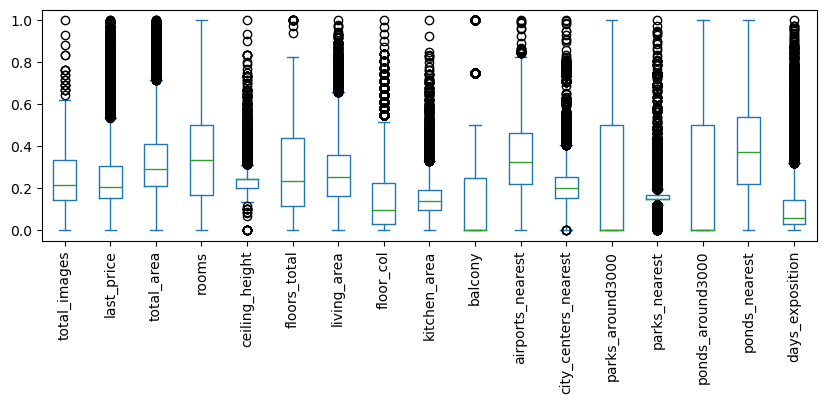

In [122]:
data_norm_filtred = data_norm(data)
quan = 1
data_norm_filtred = data_norm_filtred[
    ~data_norm_filtred[data_norm_filtred < data_norm_filtred.quantile(quan)].isna()]
data_norm_filtred = data_norm(data_norm_filtred)
data_norm_filtred.plot(kind='box', figsize=(10,3),rot=90);

Посмотрим, возможно ли оценить корректность значений полей расстояний. Выведем еще раз распределения значений по терр полям

In [123]:
# обновим таблицу с распределениям значений по всем полям
panni = 20              # количество корзин
qmx =  1                # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
condition = ''          # условие отбора в базовых полях
simple = True           # False - используем условие отбора в базовых полях
top = 5                 # количество Топ корзин разбиения
b_list = ['']           # список базовых полей
b_list_use = False      # использовать / нет список базовых полей
c_list = ['']           # список расчетных полей
c_list_use = False      # использовать / нет список расчетных полей
cond_count_use = False  # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк
#-------------------------------------------------------------------
fract_table = condition_depend(panni,qmx,qmn,condition,simple,
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,cond_count_use)
cutoff = 0.0
cond_conc = condition_concentrate(cutoff,simple,top,fract_table,df,b_list,b_list_use).sort_values(by='nunique')
#cond_conc

In [124]:
# соберем топ корзины вместе
top_panni = pd.DataFrame(index=range(5)) # датафрейм, в который поместим отобранную информацию по Топ корзинам
for clm in ['ponds_around3000', 'parks_around3000','parks_nearest','ponds_nearest']:
    sf = pd.DataFrame((fract_table.nlargest(5,[('simple',clm+'_cnt')])
            [[('simple',clm+'_int'),('simple',clm+'_cnt')]].reset_index(drop= True)))
    top_panni=pd.concat((top_panni,sf),
                     axis = 1)
display(top_panni)

top_panni = pd.DataFrame(index=range(5))
for clm in ['city_centers_nearest','airports_nearest','locality_name']:
    sf = pd.DataFrame((fract_table.nlargest(5,[('simple',clm+'_cnt')])
            [[('simple',clm+'_int'),('simple',clm+'_cnt')]].reset_index(drop= True)))
    top_panni=pd.concat((top_panni,sf),
                     axis = 1)
display(top_panni)
print('Максимальное / минимальное количество прудов до 3 км',data['ponds_around3000'].max(),
      '/',data['ponds_around3000'].min())
print('Максимальное / минимальное количество парков до 3 км',
      data['parks_around3000'].max(),'/',data['parks_around3000'].min())
print('Максимальное / минимальное расстояние до ближайшего парка',
      data['parks_nearest'].max(),'/',data['parks_nearest'].min())
print('Максимальное / минимальное расстояние до ближайшего пруда',
      data['ponds_nearest'].max(),'/',data['ponds_nearest'].min())
print('Максимальное / минимальное расстояние до центра',
      data['city_centers_nearest'].max(),'/',data['city_centers_nearest'].min())
print('Максимальное / минимальное расстояние до аэропорта',
      data['airports_nearest'].max(),'/',data['airports_nearest'].min())

,"(simple, ponds_around3000_int)","(simple, ponds_around3000_cnt)","(simple, parks_around3000_int)","(simple, parks_around3000_cnt)","(simple, parks_nearest_int)","(simple, parks_nearest_cnt)","(simple, ponds_nearest_int)","(simple, ponds_nearest_cnt)"
0,"(-1.0, 0.0]",0.493241,"(-1.0, 0.0]",0.583119,"(319.0, 478.5]",0.599486,"(2850.6, 3000.0]",0.529103
1,"(0.0, 1.0]",0.306334,"(0.0, 1.0]",0.301810,"(638.0, 797.5]",0.135795,"(310.8, 460.2]",0.087476
2,"(1.0, 2.0]",0.129650,"(1.0, 2.0]",0.086638,"(478.5, 638.0]",0.101329,"(460.2, 609.6]",0.082896
3,"(2.0, 3.0]",0.070774,"(2.0, 3.0]",0.028433,"(159.5, 319.0]",0.083007,"(609.6, 759.0]",0.075411
4,NaN,NaN,NaN,NaN,"(0.0, 159.5]",0.041057,"(161.4, 310.8]",0.067702


,"(simple, city_centers_nearest_int)","(simple, city_centers_nearest_cnt)","(simple, airports_nearest_int)","(simple, airports_nearest_cnt)","(simple, locality_name_int)","(simple, locality_name_cnt)"
0,"(13359.2, 16647.25]",0.244945,"(12729.5, 16973.0]",0.124008,Санкт-Петербург,0.652881
1,"(10071.15, 13359.2]",0.243828,"(21216.5, 25460.0]",0.122612,поселок Мурино,0.025987
2,"(3495.05, 6783.1]",0.106524,"(16973.0, 21216.5]",0.120824,деревня Кудрово,0.020789
3,"(6783.1, 10071.15]",0.098313,"(33947.0, 38190.5]",0.102894,поселок Шушары,0.019380
4,"(16647.25, 19935.3]",0.088370,"(29703.5, 33947.0]",0.093844,Всеволожск,0.017442


Максимальное / минимальное количество прудов до 3 км 3.0 / 0.0
Максимальное / минимальное количество парков до 3 км 3.0 / 0.0
Максимальное / минимальное расстояние до ближайшего парка 3190.0 / 1.0
Максимальное / минимальное расстояние до ближайшего пруда 3000.0 / 13.0
Максимальное / минимальное расстояние до центра 65968.0 / 208.0
Максимальное / минимальное расстояние до аэропорта 84869.0 / 0.0


Считаю, что данные имеют корректные распределения. На данном этапе отбрасывать строки не требуется. При необходимости применим фильтрацию.

Конечно, возможно более глубоко проанализировать связь в полях city_centers_nearest, airports_nearest, locality_name на предмет возможных некорректных значений в city_centers_nearest, airports_nearest. Но это выходит за рамки исследования. При то, что данные корректно можно оценить, не делая сложный алгоритм сравнения, а применив доп.информацию по координатам, что в реальном живом проекте было бы сделать менее трудозатратно.

### days_exposition

Посмотрим на возможные некорректные значения поля days_exposition. Очевидно, что значение days_exposition должно быть меньше max(first_day_exposition_date) - first_day_exposition_date. Проверим это условие.

In [125]:
data[(data['first_day_exposition_date'].max()-data['first_day_exposition_date']).dt.days<0]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor_col,is_apartment,...,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,first_day_exposition_date


Данные в поле - корректные.

На этом обработка некорректных значений и выросов завершена. Также завершен блок предобработки данных.

Переходим к заданиям и исследовательской части проекта.

Выделяющиеся значения в верхней части данных удалены

In [126]:
print_string = ('{:,.2%}'.format((data.shape[0]-old_data_count)/old_data_count))
print('Исходный датафрейм в итоге уменьшен на: ',print_string)

Исходный датафрейм в итоге уменьшен на:  -4.11%


## Посчитайте и добавьте в таблицу новые столбцы

Добавьте в таблицу новые столбцы со следующими параметрами:

    цена одного квадратного метра;
    день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
    месяц публикации объявления;
    год публикации объявления;
    тип этажа квартиры (значения — «‎первый», «последний», «другой»);
    расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).

In [127]:
# цена одного квадратного метра
data['one_meter_price'] = data['last_price']/data['total_area']

In [128]:
# день недели публикации объявления (0 — понедельник, 1 — вторник и так далее)
data['day_of_week'] = data['first_day_exposition_date']. dt.weekday

In [129]:
# месяц публикации объявления
data['month_of_date'] = data['first_day_exposition_date']. dt.month

In [130]:
# год публикации объявления
data['year_of_date'] = data['first_day_exposition_date']. dt.year

In [131]:
# тип этажа квартиры (значения — «первый», «последний», «другой»)
idx = data.query('floor_col == 1').index
data.loc[idx,'floor_type']='первый'
idx = data.query('(floors_total - floor_col) == 0').index
data.loc[idx,'floor_type']='последний'
idx = data.query('floor_type.isna()').index
data.loc[idx,'floor_type']='другой'

In [132]:
# расстояние до центра города в километрах (переведите из м в км и округлите до целых значений)
data['city_centers_nearest_km'] = (data['city_centers_nearest']/1000).round()

## Проведите исследовательский анализ данных

### Изучите следующие параметры объектов
    общая площадь;
    жилая площадь;
    площадь кухни;
    цена объекта;
    количество комнат;
    высота потолков;
    этаж квартиры;
    тип этажа квартиры («первый», «последний», «другой»);
    общее количество этажей в доме;
    расстояние до центра города в метрах;
    расстояние до ближайшего аэропорта;
    расстояние до ближайшего парка;
    день и месяц публикации объявления

In [133]:
r_price_list = ['last_price']
r_flat_list = ['total_area','living_area','kitchen_area','rooms','ceiling_height']
r_home_list = ['floor_col','floor_type','floors_total']
r_terr_list = ['city_centers_nearest','airports_nearest','parks_nearest']
r_daymonth_list = ['day_of_week','month_of_date']
r_date_list = ['first_day_exposition_date']

Построим таблицу с разбивкой всех значений дата сета на 20 корзин

In [134]:
panni = 20              # количество корзин
qmx =  1                # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
condition = ''          # условие отбора в базовых полях
simple = True           # False - используем условие отбора в базовых полях
top = 5                 # количество Топ корзин разбиения
b_list = ['']           # список базовых полей
b_list_use = False       # использовать / нет список базовых полей
c_list = ['']           # список расчетных полей
c_list_use = False      # использовать / нет список расчетных полей
cond_count_use = False  # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк
#-------------------------------------------------------------------
fract_table = condition_depend(panni,qmx,qmn,condition,simple, # таблица с интервалами (корзинами) распределений
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,cond_count_use)
cutoff = 0.0
cond_conc = condition_concentrate(cutoff,simple,top,
                                  fract_table,
                                  df,b_list,b_list_use)

#### last_price

Посмотрим распределения значений в полях цены r_price_list

In [135]:
top_panni = pd.DataFrame(index=range(3))
for clm in r_price_list:
    sf = pd.DataFrame((fract_table.nlargest(5,[('simple',clm+'_cnt')])
            [[('simple',clm+'_int'),('simple',clm+'_cnt')]].reset_index(drop= True)))
    top_panni=pd.concat((top_panni,sf),
                     axis = 1)
display(top_panni)
print_string = ('{:,.0f}'.format(data['last_price'].max())+
      ' / '+'{:,.0f}'.format(data['last_price'].min()))
print_string=print_string.replace(',','\'')
print('Максимальная / минимальная цена в объявлениях',print_string,'руб.')

,"(simple, last_price_int)","(simple, last_price_cnt)"
0,"(3365349.15, 4343799.2]",0.214468
1,"(4343799.2, 5322249.25]",0.172754
2,"(2386899.1, 3365349.15]",0.155065
3,"(5322249.25, 6300699.3]",0.110710
4,"(6300699.3, 7279149.35]",0.069172


Максимальная / минимальная цена в объявлениях 19'999'000 / 430'000 руб.


Построим для last_price таблицу с распредениями

fract_table_price: таблица с интервалами (корзинами) распределений


,last_price_int,last_price_cnt
0,"(429999.0, 1408449.05]",0.025785
1,"(1408449.05, 2386899.1]",0.066444
2,"(2386899.1, 3365349.15]",0.155065
3,"(3365349.15, 4343799.2]",0.214468
4,"(4343799.2, 5322249.25]",0.172754
5,"(5322249.25, 6300699.3]",0.110710
6,"(6300699.3, 7279149.35]",0.069172
7,"(7279149.35, 8257599.4]",0.050383
8,"(8257599.4, 9236049.45]",0.034938
9,"(9236049.45, 10214499.5]",0.024597


cond_conc_price: таблица с суммами топ корзин


,nunique,not_nan_count,nan_count,nan_ratio,data_type,conc_20_1,conc_20_2,conc_20_3,conc_20_4,conc_20_5
last_price,2562.0,22726.0,0.0,0.0,float64,0.214468,0.387222,0.542286,0.652997,0.722168


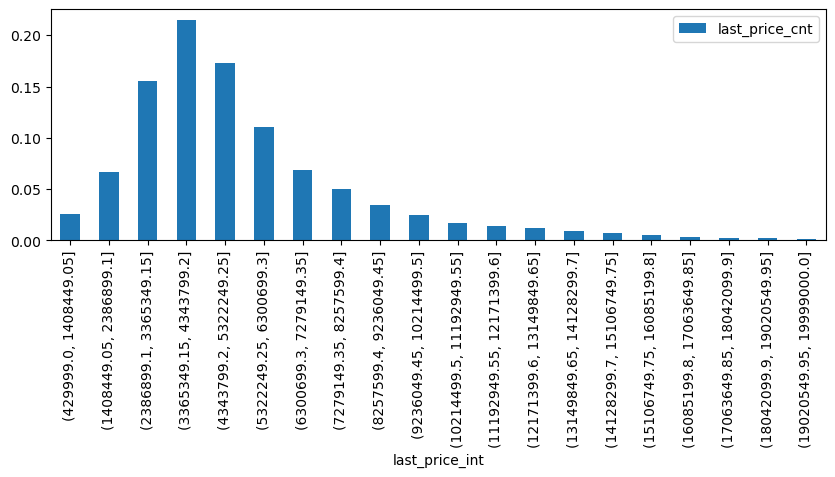

In [137]:
panni = 20              # количество корзин
qmx =  1             # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
condition = ''          # условие отбора в базовых полях
simple = True           # False - используем условие отбора в базовых полях
top = 5                 # количество Топ корзин разбиения
b_list = ['last_price']           # список базовых полей
b_list_use = True       # использовать / нет список базовых полей
c_list = ['']           # список расчетных полей
c_list_use = False      # использовать / нет список расчетных полей
cond_count_use = False  # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк
#-------------------------------------------------------------------
fract_table_price = condition_depend(panni,qmx,qmn,condition,simple, # таблица с интервалами (корзинами) распределений
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,cond_count_use)
cutoff = 0.0
cond_conc_price = condition_concentrate(cutoff,simple,top,fract_table_price,df,b_list,b_list_use)
print('fract_table_price: таблица с интервалами (корзинами) распределений')
fract_table_price.rename(columns={('last_price', 'last_price_int'):'last_price_int',
                                  ('last_price', 'last_price_cnt'):'last_price_cnt'}, inplace = True)
display(fract_table_price.head(10))

print('cond_conc_price: таблица с суммами топ корзин')
display(cond_conc_price) # таблица с суммами топ корзин

fract_table_price.plot(y='last_price_cnt',kind='bar', # гистограмма по таблице корзин
                       x='last_price_int',rot=90,figsize=(10,3));

Распределение значений цены после отсечения верхних выбросов имеет нормальный вид. Самый тяжелый интервал - от 3,3 до 4,3 млн. руб. содержит 21.4% объявлений. Топ 5 корзин (от 2,4 до 6,3 млн.руб.) составляют 72.2% всех значений.

#### r_flat_list

Посмотрим распределение значений для r_flat_list = ['total_area','living_area','kitchen_area','rooms','ceiling_height']

In [138]:
top_panni = pd.DataFrame(index=range(5))
for clm in r_flat_list:
    sf = pd.DataFrame((fract_table.nlargest(5,[('simple',clm+'_cnt')])
            [[('simple',clm+'_int'),('simple',clm+'_cnt')]].reset_index(drop= True)))
    top_panni=pd.concat((top_panni,sf),
                     axis = 1)
print('Таблица топ 5 из 20 корзин значений полей total_area, living_area, kitchen_area, rooms, ceiling_height')
display(top_panni)
df, df_style = summary_table()
print('Таблица статистических метрик')
display(df.loc[r_flat_list].style.format(df_style))
print('Концентрация значений в топ 5 корзин')
cond_conc.loc[r_flat_list]

Таблица топ 5 из 20 корзин значений полей total_area, living_area, kitchen_area, rooms, ceiling_height


,"(simple, total_area_int)","(simple, total_area_cnt)","(simple, living_area_int)","(simple, living_area_cnt)","(simple, kitchen_area_int)","(simple, kitchen_area_cnt)","(simple, rooms_int)","(simple, rooms_cnt)","(simple, ceiling_height_int)","(simple, ceiling_height_cnt)"
0,"(37.64, 44.3]",0.162061,"(24.5, 30.375]",0.232729,"(6.67, 9.855]",0.337279,"(0.0, 1.0]",0.353252,"(2.4, 2.75]",0.838115
1,"(30.98, 37.64]",0.159157,"(12.75, 18.625]",0.232509,"(9.855, 13.04]",0.253718,"(1.0, 2.0]",0.345683,"(2.75, 3.1]",0.113834
2,"(44.3, 50.96]",0.130819,"(30.375, 36.25]",0.128971,"(3.485, 6.67]",0.183578,"(2.0, 3.0]",0.243554,"(3.1, 3.45]",0.033662
3,"(50.96, 57.62]",0.114318,"(36.25, 42.125]",0.093857,"(25.78, 28.965]",0.086509,"(3.0, 4.0]",0.041098,"(3.45, 3.8]",0.009197
4,"(57.62, 64.28]",0.108642,"(18.625, 24.5]",0.093769,"(13.04, 16.225]",0.082153,"(-1.0, 0.0]",0.008580,"(3.8, 4.15]",0.002244


Таблица статистических метрик


,col_null_count,col_type,count,mean,std,min,25%,50%,75%,max,mean_median
total_area,0,float64,22726,55.44,21.32,12.0,39.7,50.7,66.4,144.2,9.35%
living_area,0,float64,22726,31.36,14.13,2.0,19.0,28.6,39.8,118.5,9.67%
kitchen_area,0,float64,22726,11.42,6.44,1.3,7.1,9.5,12.5,64.0,20.21%
rooms,0,int64,22726,1.98,0.94,0.0,1.0,2.0,3.0,7.0,-1.00%
ceiling_height,0,float64,22726,2.72,0.20,2.0,2.6,2.7,2.7,8.0,-0.69%


Концентрация значений в топ 5 корзин


,nunique,not_nan_count,nan_count,nan_ratio,data_type,conc_20_1,conc_20_2,conc_20_3,conc_20_4,conc_20_5
total_area,1793.0,22726.0,0.0,0.0,float64,0.162061,0.321218,0.452037,0.566356,0.674998
living_area,1476.0,22726.0,0.0,0.0,float64,0.232729,0.465238,0.594209,0.688067,0.781836
kitchen_area,968.0,22726.0,0.0,0.0,float64,0.337279,0.590997,0.774575,0.861084,0.943237
rooms,8.0,22726.0,0.0,0.0,int64,0.353252,0.698935,0.942489,0.983587,0.992168
ceiling_height,152.0,22726.0,0.0,0.0,float64,0.838115,0.951949,0.985611,0.994808,0.997052


Построим гистограммы для данного блока полей

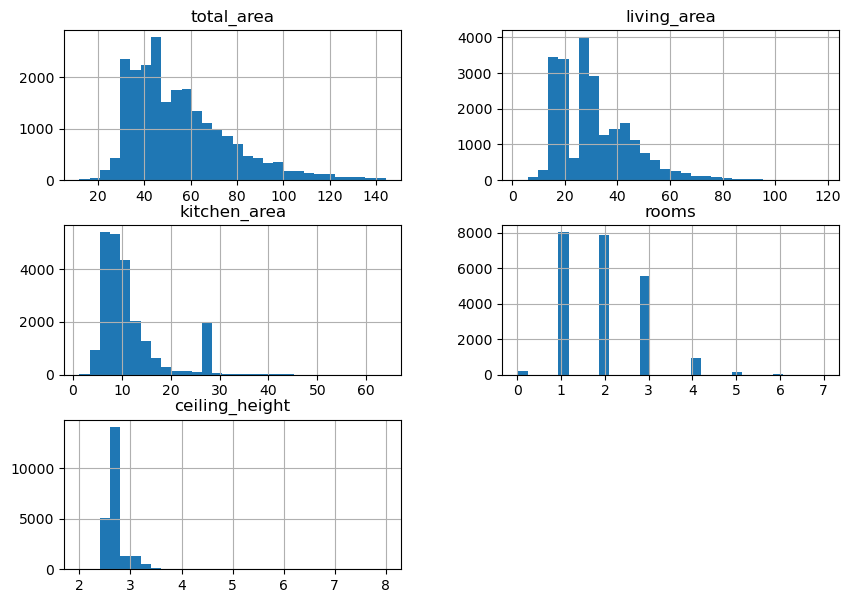

In [139]:
data[r_flat_list].hist(bins=30,figsize=(10,7));

Видим следующие распределения значений:

    67,5% объектов - с общей площадью от 31 до 64.4 м.кв.
    78%   - с жилой площадью от 12 до 42 м.кв.
    77.5% - с площадью кухни от 3,5 до 13 м.кв.
    35,3% от общего количества составляют объявления по "однушкам", 34% - по "двушкам", 24% приходится на трехкомнатные, 4.1% - на 4-хкомнатные.
    84% потолков - от 2.4 до 2.75 м.

#### r_home_list

Посмотрим распределения значений (топ 15 из 20 корзин) для r_home_list = ['floor_col','floor_type','floors_total']

In [140]:
top_panni = pd.DataFrame(index=range(5))
for clm in r_home_list:
    sf = pd.DataFrame((fract_table.nlargest(15,[('simple',clm+'_cnt')])
            [[('simple',clm+'_int'),('simple',clm+'_cnt')]].reset_index(drop= True)))
    top_panni=pd.concat((top_panni,sf),
                     axis = 1)
print('Таблица топ 5 из 20 корзин значений полей floor_col,floor_type,floors_total')
display(top_panni)
df, df_style = summary_table()
print('Таблица статистических метрик')
df.loc[r_home_list].style.format(df_style)

Таблица топ 5 из 20 корзин значений полей floor_col,floor_type,floors_total


,"(simple, floor_col_int)","(simple, floor_col_cnt)","(simple, floor_type_int)","(simple, floor_type_cnt)","(simple, floors_total_int)","(simple, floors_total_cnt)"
0,"(1.65, 3.3]",0.270791,другой,0.733169,"(3.6, 5.4]",0.295917
1,"(4.95, 6.6]",0.163601,последний,0.142304,"(7.2, 9.0]",0.177418
2,"(0.0, 1.65]",0.125759,первый,0.124527,"(14.4, 16.2]",0.074232
3,"(3.3, 4.95]",0.116167,NaN,NaN,"(23.4, 25.2]",0.067104
4,"(6.6, 8.25]",0.096893,NaN,NaN,"(10.8, 12.6]",0.067016
5,"(9.9, 11.55]",0.051659,NaN,NaN,"(16.2, 18.0]",0.057775
6,"(8.25, 9.9]",0.045147,NaN,NaN,"(5.4, 7.2]",0.056147
7,"(11.55, 13.2]",0.038722,NaN,NaN,"(9.0, 10.8]",0.049899
8,"(14.85, 16.5]",0.027986,NaN,NaN,"(1.8, 3.6]",0.043870
9,"(16.5, 18.15]",0.017337,NaN,NaN,"(12.6, 14.4]",0.033662


Таблица статистических метрик


,col_null_count,col_type,count,mean,std,min,25%,50%,75%,max,mean_median
floor_col,0,int64,22726,5.91,4.91,1.0,2.0,4.0,8.0,33.0,47.66%
floor_type,0,object,nan,nan,nan,nan,nan,nan,nan,nan,nan%
floors_total,0,float64,22726,10.77,6.62,1.0,5.0,9.0,16.0,36.0,19.63%


    29.5% объявлений составляют 5 этажки
    17,7% - девятиэтажки
    4.4% - малоэтажные дома (до 3-х этажей включительно)

    54.9% объектов находятся на этажах со 2-го по 6-й
    12.5% объектов - на первых этажах.
    14,2% объектов - на последних этажах.
    73,3% объектов - на других этажах

Построим гистограммы для данного блока полей

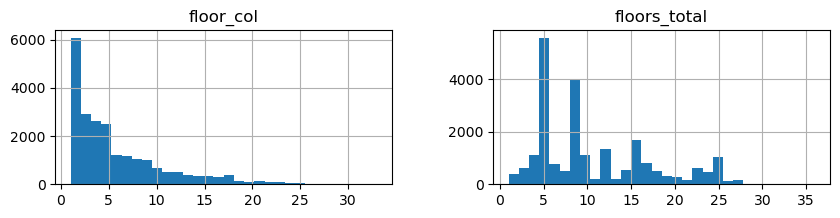

In [141]:
data[r_home_list].hist(bins=30,figsize=(10,2));

#### r_terr_list

Посмотрим распределение Топ 10 из 20 корзин значений для r_terr_list = ['city_centers_nearest','airports_nearest','parks_nearest']

In [142]:
top_panni = pd.DataFrame(index=range(5))
for clm in r_terr_list:
    sf = pd.DataFrame((fract_table.nlargest(10,[('simple',clm+'_cnt')])
            [[('simple',clm+'_int'),('simple',clm+'_cnt')]].reset_index(drop= True)))
    top_panni=pd.concat((top_panni,sf),
                     axis = 1)
print('Таблица топ 5 из 20 корзин значений полей city_centers_nearest,airports_nearest,parks_nearest')
display(top_panni)
df, df_style = summary_table()
print('Таблица статистических метрик')
df.loc[r_terr_list].style.format(df_style)

Таблица топ 5 из 20 корзин значений полей city_centers_nearest,airports_nearest,parks_nearest


,"(simple, city_centers_nearest_int)","(simple, city_centers_nearest_cnt)","(simple, airports_nearest_int)","(simple, airports_nearest_cnt)","(simple, parks_nearest_int)","(simple, parks_nearest_cnt)"
0,"(13359.2, 16647.25]",0.244945,"(12729.5, 16973.0]",0.124008,"(319.0, 478.5]",0.599486
1,"(10071.15, 13359.2]",0.243828,"(21216.5, 25460.0]",0.122612,"(638.0, 797.5]",0.135795
2,"(3495.05, 6783.1]",0.106524,"(16973.0, 21216.5]",0.120824,"(478.5, 638.0]",0.101329
3,"(6783.1, 10071.15]",0.098313,"(33947.0, 38190.5]",0.102894,"(159.5, 319.0]",0.083007
4,"(16647.25, 19935.3]",0.088370,"(29703.5, 33947.0]",0.093844,"(0.0, 159.5]",0.041057
5,"(19935.3, 23223.35]",0.062060,"(25460.0, 29703.5]",0.093509,"(797.5, 957.0]",0.017149
6,"(29799.45, 33087.5]",0.038376,"(50921.0, 55164.5]",0.072171,"(957.0, 1116.5]",0.005977
7,"(207.0, 3495.05]",0.038264,"(8486.0, 12729.5]",0.070998,"(1116.5, 1276.0]",0.004413
8,"(26511.4, 29799.45]",0.021618,"(42434.0, 46677.5]",0.063512,"(1435.5, 1595.0]",0.002011
9,"(33087.5, 36375.55]",0.020780,"(38190.5, 42434.0]",0.062507,"(1276.0, 1435.5]",0.001955


Таблица статистических метрик


,col_null_count,col_type,count,mean,std,min,25%,50%,75%,max,mean_median
city_centers_nearest,4824,float64,17902,14851.60,8523.39,208.0,10278.5,13551.0,16921.0,65968.0,9.60%
airports_nearest,4824,float64,17902,29668.60,13268.75,0.0,18585.0,27583.0,39187.0,84869.0,7.56%
parks_nearest,4824,float64,17902,489.00,228.86,1.0,456.0,460.0,515.0,3190.0,6.30%


Построим гистограммы для данного блока полей

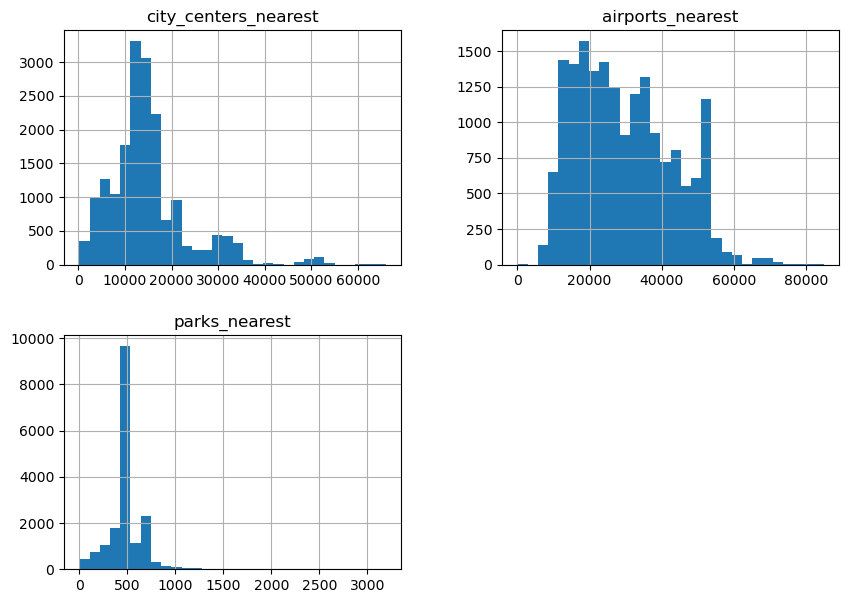

In [143]:
data[r_terr_list].hist(bins=30,figsize=(10,7));

    50% объектов находятся на расстояниии до центра - на расстоянии от 10 до 16.6 км.
    Данные в поле airports_nearest распределены достаточно равномерно
    83,5% объектов имеют ближайший парк на расстоянии от 319 до 797 м.

#### r_daymonth_list

Посмотрим распределение значений для полей r_daymonth_list = ['day_of_week','month_of_date']

In [144]:
top_panni = pd.DataFrame(index=range(5))
for clm in r_daymonth_list:
    sf = pd.DataFrame((fract_table.nlargest(12,[('simple',clm+'_cnt')])
            [[('simple',clm+'_int'),('simple',clm+'_cnt')]].reset_index(drop= True)))
    top_panni=pd.concat((top_panni,sf),
                     axis = 1)
print('Таблица топ 5 из 20 корзин значений полей day_of_week,month_of_date')
display(top_panni)
df, df_style = summary_table()
print('Таблица статистических метрик')
df.loc[r_daymonth_list].style.format(df_style)

Таблица топ 5 из 20 корзин значений полей day_of_week,month_of_date


,"(simple, day_of_week_int)","(simple, day_of_week_cnt)","(simple, month_of_date_int)","(simple, month_of_date_cnt)"
0,"(2.0, 3.0]",0.179442,"(1.0, 2.0]",0.110886
1,"(0.0, 1.0]",0.177330,"(2.0, 3.0]",0.109566
2,"(3.0, 4.0]",0.169674,"(3.0, 4.0]",0.101030
3,"(1.0, 2.0]",0.167121,"(10.0, 11.0]",0.099886
4,"(-1.0, 0.0]",0.152293,"(9.0, 10.0]",0.090381
5,"(4.0, 5.0]",0.082065,"(8.0, 9.0]",0.084001
6,"(5.0, 6.0]",0.072076,"(5.0, 6.0]",0.074012
7,NaN,NaN,"(7.0, 8.0]",0.073836
8,NaN,NaN,"(6.0, 7.0]",0.071020
9,NaN,NaN,"(11.0, 12.0]",0.069084


Таблица статистических метрик


,col_null_count,col_type,count,mean,std,min,25%,50%,75%,max,mean_median
day_of_week,0,int64,22726,2.57,1.79,0.0,1.0,3.0,4.0,6.0,-14.29%
month_of_date,0,int64,22726,6.40,3.49,1.0,3.0,6.0,10.0,12.0,6.74%


Построим гистограммы для данного блока полей

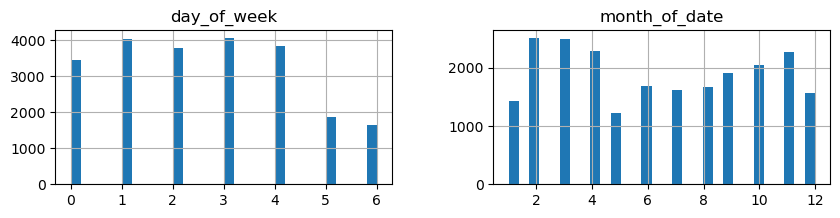

In [146]:
data[r_daymonth_list].hist(bins=30,figsize=(10,2));


    Меньше всего объявлений подается в выходные всего 15,2%
    Топ дни: четверг 17,9%, вторник 17.7%
    В данных наблюдается сезонность: пики- (февраль, март, апрель) и (сентябрь, окрябрь, ноябрь). Лето и зима - спад



Построим гистограмму для категории этажей

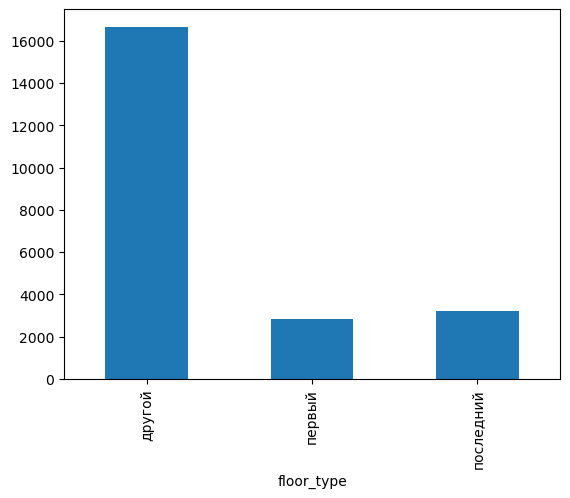

In [147]:
data.groupby('floor_type')['floor_type'].count().plot(kind = 'bar');

### Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней было размещено каждое объявление


    Постройте гистограмму.
    Посчитайте среднее и медиану.
    В ячейке типа markdown опишите, сколько времени обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?


In [148]:
r_expo_list = ['days_exposition']
top_panni = pd.DataFrame(index=range(5))
for clm in r_expo_list:
    sf = pd.DataFrame((fract_table.nlargest(20,[('simple',clm+'_cnt')])
            [[('simple',clm+'_int'),('simple',clm+'_cnt')]].reset_index(drop= True)))
    top_panni=pd.concat((top_panni,sf),
                     axis = 1)
print('Таблица топ 10 из 20 корзин значений полей day_of_week,month_of_date')
display(top_panni)
df, df_style = summary_table()
print('Таблица статистических метрик')
df.loc[r_expo_list].style.format(df_style)

Таблица топ 10 из 20 корзин значений полей day_of_week,month_of_date


,"(simple, days_exposition_int)","(simple, days_exposition_cnt)"
0,"(0.0, 79.0]",0.449702
1,"(79.0, 158.0]",0.204424
2,"(158.0, 237.0]",0.108726
3,"(237.0, 316.0]",0.063428
4,"(316.0, 395.0]",0.047924
5,"(395.0, 474.0]",0.035148
6,"(474.0, 553.0]",0.023432
7,"(553.0, 632.0]",0.017624
8,"(632.0, 711.0]",0.011716
9,"(711.0, 790.0]",0.009494


Таблица статистических метрик


,col_null_count,col_type,count,mean,std,min,25%,50%,75%,max,mean_median
days_exposition,2924,float64,19802,176.88,215.75,1.0,44.0,93.0,225.0,1580.0,90.19%


array([[<AxesSubplot:title={'center':'days_exposition'}>]], dtype=object)

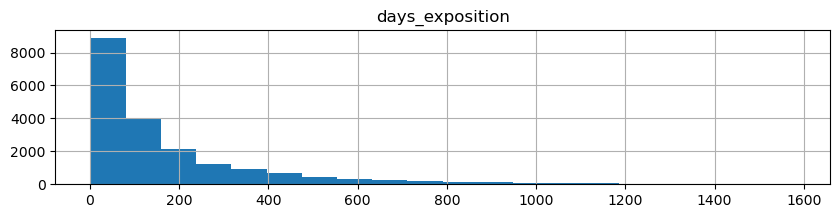

In [149]:
data[r_expo_list].hist(bins=20,figsize=(10,2))

Распределение имеет "Пуасоновскую" форму.

    45% объектов продаются за срок от 0 до 79 дней
    20,1% за срок от 80 до 158 дней
    Далее идет заметный спад количества размера корзин. Все, что "висит" дольше 158 дней составляет 30,6%

Т.о. быстрые продажи - до 79 дней. Все, что продается более года можно считать долгой продажей


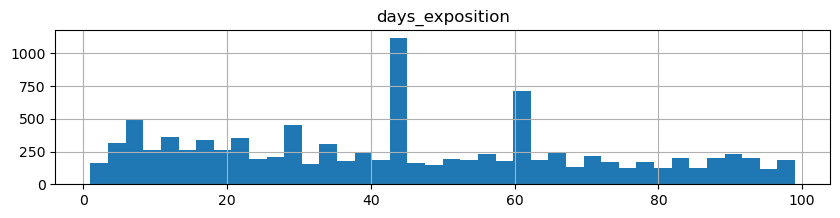

In [150]:
data.query('days_exposition < 100')[r_expo_list].hist(bins=40,figsize=(10,2));

В диапазоне до 100 дней можно выделить два пика - это 43-45 дней и 60-62 дня.

### Какие факторы больше всего влияют на общую (полную) стоимость объекта?

зучите, зависит ли цена от: общей площади;

    жилой площади;
    площади кухни;
    количества комнат;
    этажа, на котором расположена квартира (первый, последний, другой);
    даты размещения (день недели, месяц, год).

In [151]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22726 entries, 0 to 23698
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   total_images               22726 non-null  int64         
 1   last_price                 22726 non-null  float64       
 2   total_area                 22726 non-null  float64       
 3   first_day_exposition       22726 non-null  object        
 4   rooms                      22726 non-null  int64         
 5   ceiling_height             22726 non-null  float64       
 6   floors_total               22726 non-null  float64       
 7   living_area                22726 non-null  float64       
 8   floor_col                  22726 non-null  int64         
 9   is_apartment               22726 non-null  bool          
 10  studio                     22726 non-null  bool          
 11  open_plan                  22726 non-null  bool          
 12  kitc

Добавим столбец с цифровым обозначением типа этажа. Построим матрицу корреляции. Построим попарные диаграммы для данных полей

#### flat_list

In [152]:
def floor_type_digit(flo):
    if flo == 'первый':
        return 1
    elif flo == 'другой':
        return 2
    return 3
data['floor_type_digit']=data['floor_type'].apply(floor_type_digit)

In [153]:
pr_list = ['last_price']
pr_flat_list = ['living_area','rooms','floor_type_digit']
pr_date_list = ['day_of_week','month_of_date','year_of_date']

data[pr_list+pr_flat_list+pr_date_list].corr()

,last_price,living_area,rooms,floor_type_digit,day_of_week,month_of_date,year_of_date
last_price,1.000000,0.602728,0.470357,0.044287,-0.015788,0.008311,-0.021181
living_area,0.602728,1.000000,0.847815,0.018971,-0.006466,0.002353,-0.062187
rooms,0.470357,0.847815,1.000000,-0.003002,-0.001250,-0.000450,-0.043350
floor_type_digit,0.044287,0.018971,-0.003002,1.000000,0.006097,0.009149,0.009523
day_of_week,-0.015788,-0.006466,-0.001250,0.006097,1.000000,0.012562,-0.003437
month_of_date,0.008311,0.002353,-0.000450,0.009149,0.012562,1.000000,-0.269046
year_of_date,-0.021181,-0.062187,-0.043350,0.009523,-0.003437,-0.269046,1.000000


На основании данных корреляционной матрицы можно сделать вывод, что цена:

    заметно и положительно зависит от размера жилой площади (коэффициент: 0.54) и количества комнат (0.36)
    слабо положительно зависит от типа этажа, чем выше этаж, тем ввыше (но незначительно) цена
    слабо положительно зависит от дня недели и месяца
    слабо отрицательно зависит от года

построим диаграмммы

Для поля day_of_week медиана по last_price не информативна:

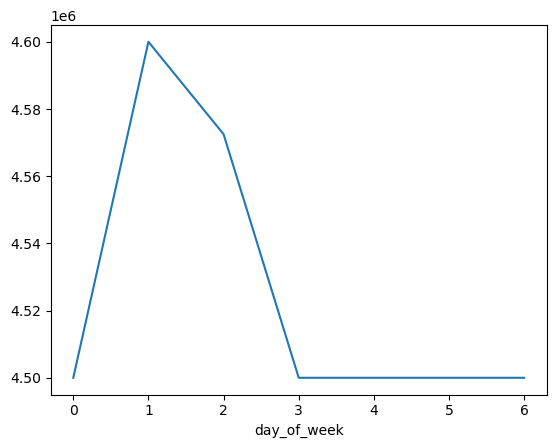

In [155]:
data.groupby('day_of_week')['last_price'].median().plot();

Используем среднее

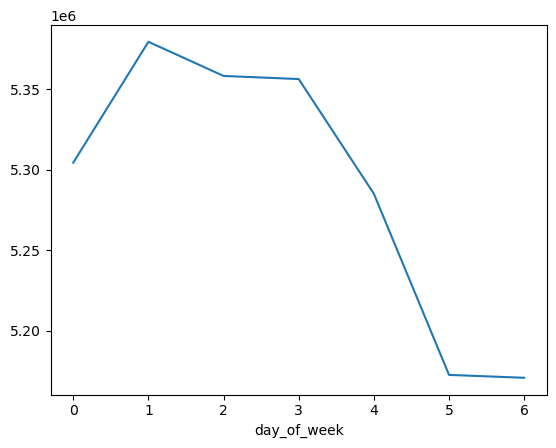

In [156]:
data.groupby('day_of_week')['last_price'].mean().plot();

Видим обратную зависимость цены от дня недели на интервале от вторника по субботу

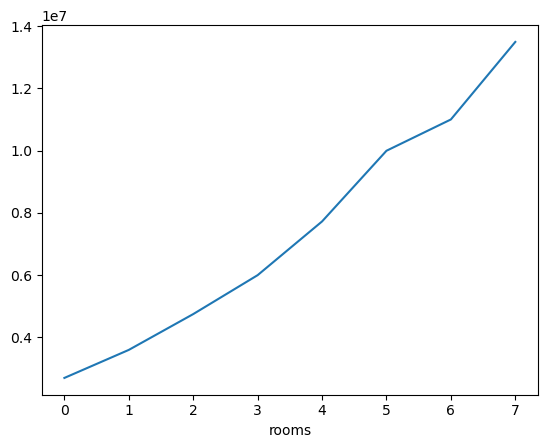

In [157]:
data.groupby('rooms')['last_price'].median().plot();

Цена напрямую зависит от данных поля комнат

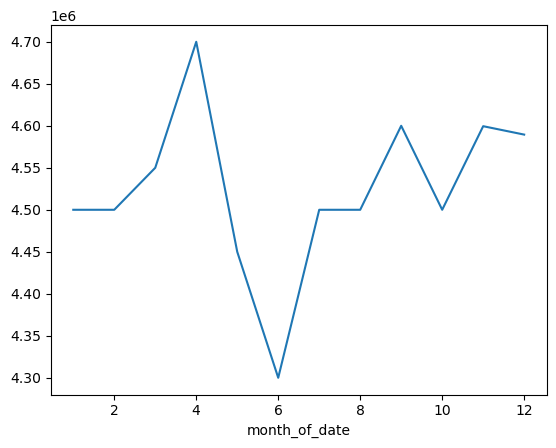

In [158]:
data.groupby('month_of_date')['last_price'].median().plot();

Зависимости центы от месяца не наблюдается.

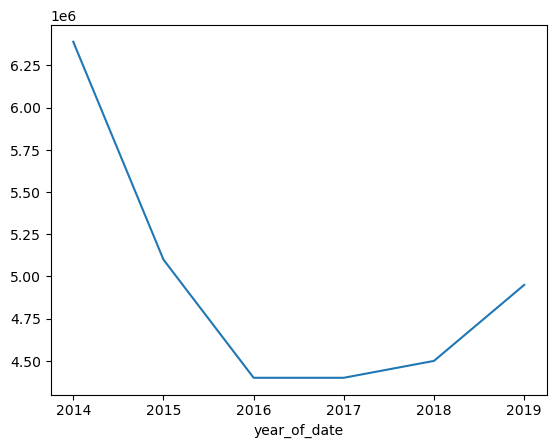

In [159]:
data.groupby('year_of_date')['last_price'].median().plot();

С 2014 по 2016 г медианная цена снижалась. Начиная с 2017 г цена растет

#### посмотрим диаграммы для полей дат


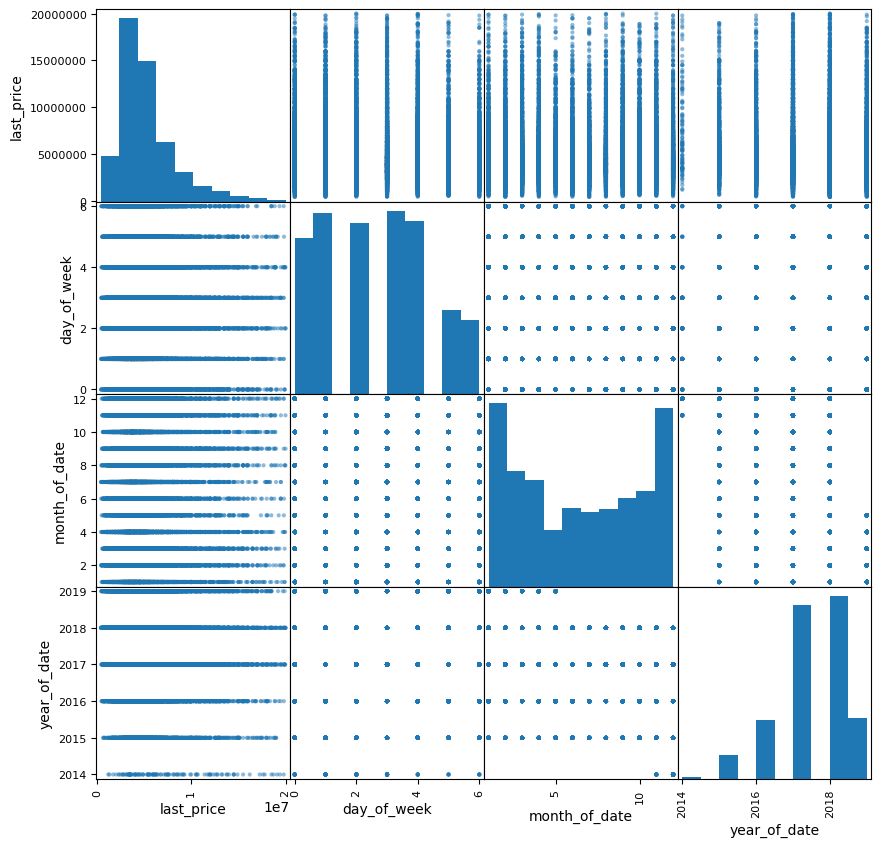

In [160]:
pd.plotting.scatter_matrix(data[pr_list+pr_date_list],figsize=(10,10));

Значения полей дат не так заметно влияют на цену. Но можно отметить некоторый пик для весенних месяцев. Т.е. весной, теоретически квартиры продаются дороже.

#### Средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце locality_name.

In [161]:
top10 = data.groupby('locality_name')['last_price'].count().nlargest(10).index.tolist()
data.query('locality_name in @top10').groupby('locality_name')['one_meter_price'].mean().sort_values()

locality_name
Выборг                58180.714024
Всеволожск            67259.384320
Гатчина               68797.702047
Колпино               75333.295801
поселок Шушары        78677.364217
поселок Мурино        86087.512050
поселок Парголово     90332.263023
деревня Кудрово       95324.930544
Пушкин               101934.435000
Санкт-Петербург      108839.579440
Name: one_meter_price, dtype: float64

Квадратный метр в СПБ самый дорогой, в Выборге - самый дешевый из Топ 10 по количеству объявлений

#### Цена километра

Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города.

In [162]:
#Посмотрим стат метрики по полю расстояния для СПБ

agg_func_math = {'city_centers_nearest': ['min','max','mean', 'median']}
data[data['locality_name']=='Санкт-Петербург'].groupby(['locality_name']).agg(agg_func_math).round(2)

city_centers_nearest                            
                                 min      max      mean   median
locality_name                                                   
Санкт-Петербург                208.0  29493.0  11933.55  12458.0

Посчитаем стоимость километра

In [163]:
data['one_km_price'] = 1000*data['last_price']/data['city_centers_nearest']

Посмотрим гистграмму распределения значений цены за километр

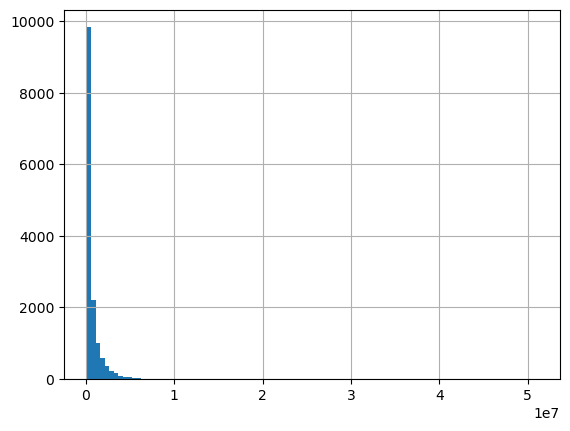

In [164]:
data[data['locality_name']=='Санкт-Петербург']['one_km_price'].hist(bins=100);

Понятно, что в самом центре все дорого. Но гистограмма не информативна. Используем написанные ранее функции и посмотрим распределение значений поля one_km_price для СПБ

In [165]:
spb = 'Санкт-Петербург'
panni = 30              # количество корзин
qmx =  1             # верхний квантиль (данные берутся ниже значения: для 1 - смотрим все данные)
qmn =  0                # нижний квантиль (данные берутся выше значения: для 0 - смотрим все данные)
condition = '@cond_clmn == @spb'          # условие отбора в базовых полях
simple = False           # False - используем условие отбора в базовых полях
top = 5                 # количество Топ корзин разбиения
b_list = ['locality_name']           # список базовых полей
b_list_use = True       # использовать / нет список базовых полей
c_list = ['one_km_price']           # список расчетных полей
c_list_use = True      # использовать / нет список расчетных полей
cond_count_use = True  # True - доля в корзинах считается по отношению к количеству отфильтрованных строк
                        # False- доля в корзинах считается по отношению к общему количеству строк
#-------------------------------------------------------------------
fract_table_km_price = condition_depend(panni,qmx,qmn,condition,simple, # таблица с интервалами (корзинами) распределений
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,cond_count_use)
cutoff = 0.0
cond_conc_km_price = condition_concentrate(cutoff,simple,top,
                                           fract_table_km_price,
                                           df,b_list,b_list_use)
print('fract_table_km_price: таблица с интервалами (корзинами) распределений')
display(fract_table_km_price.head(10))

print('cond_conc_price: таблица с суммами топ корзин')
#display(cond_conc_price) # таблица с суммами топ корзин

#fract_table_km_price.plot(y='last_price_cnt',kind='bar', # гистограмма по таблице корзин
#                       x='last_price_int',rot=90,figsize=(10,3))

fract_table_km_price: таблица с интервалами (корзинами) распределений


,"(locality_name, one_km_price_int)","(locality_name, one_km_price_cnt)"
0,"(82022.987, 1783164.857]",0.896647
1,"(1783164.857, 3484306.726]",0.072320
2,"(3484306.726, 5185448.596]",0.015989
3,"(5185448.596, 6886590.465]",0.005869
4,"(6886590.465, 8587732.335]",0.002564
5,"(8587732.335, 10288874.204]",0.001417
6,"(10288874.204, 11990016.073]",0.001889
7,"(11990016.073, 13691157.943]",0.001079
8,"(13691157.943, 15392299.812]",0.000540
9,"(15392299.812, 17093441.682]",0.000202


cond_conc_price: таблица с суммами топ корзин


Видим, что цена километра сосредоточена в интервале (82022.987, 1783164.857] посмотрим распределние в этом интервале

In [166]:
condition = '@cond_clmn == @spb and one_km_price < 1783164.857'          # условие отбора в базовых полях
#-------------------------------------------------------------------
fract_table_km_price = condition_depend(panni,qmx,qmn,condition,simple, # таблица с интервалами (корзинами) распределений
                     data,
                     b_list,b_list_use,
                     c_list,c_list_use,cond_count_use)
cutoff = 0.0
cond_conc_km_price = condition_concentrate(cutoff,simple,top,
                                           fract_table_km_price,
                                           df,b_list,b_list_use)
print('fract_table_km_price: таблица с интервалами (корзинами) распределений')
display(fract_table_km_price)

fract_table_km_price: таблица с интервалами (корзинами) распределений


,"(locality_name, one_km_price_int)","(locality_name, one_km_price_cnt)"
0,"(82022.987, 138673.032]",0.008201
1,"(138673.032, 195323.077]",0.038146
2,"(195323.077, 251973.122]",0.097434
3,"(251973.122, 308623.167]",0.147242
4,"(308623.167, 365273.211]",0.144383
5,"(365273.211, 421923.256]",0.110601
6,"(421923.256, 478573.301]",0.084644
7,"(478573.301, 535223.346]",0.065383
8,"(535223.346, 591873.391]",0.043037
9,"(591873.391, 648523.435]",0.034610


Теперь построим гистгарамму с учетом фильтра по цене за километр (попадание цены в интервал до 989000 р/км)

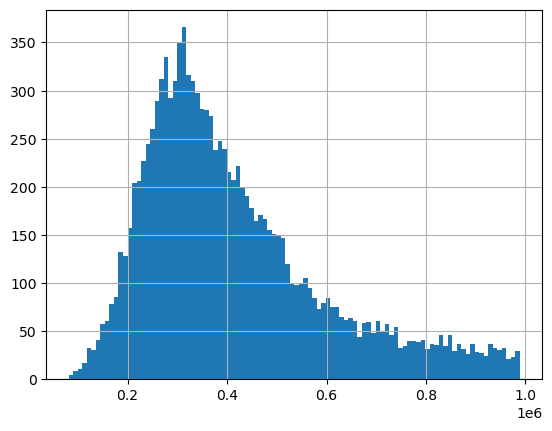

In [167]:
data[(data['locality_name']=='Санкт-Петербург') &
     (data['one_km_price'] <=989000)]['one_km_price'].hist(bins=100);

Форма распределения цены в данном интервале близка к нормальной. Теперь посмотрим зависимость цены километра от самих километров

In [168]:
idx = data[data['locality_name']=='Санкт-Петербург'].index
km_list = ['one_km_price','city_centers_nearest']
data[km_list].corr()

,one_km_price,city_centers_nearest
one_km_price,1.000000,-0.407119
city_centers_nearest,-0.407119,1.000000


Видим отрицательную незначительную зависимость

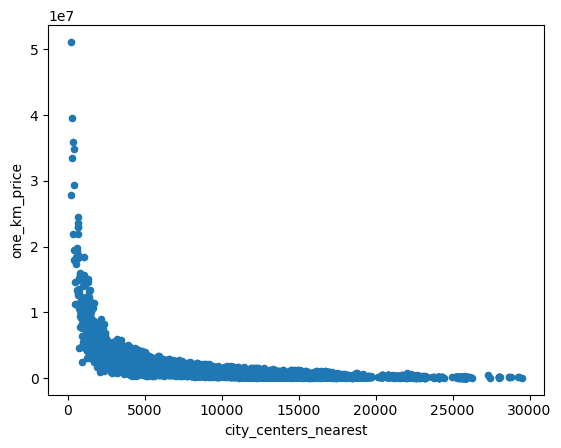

In [170]:
# посмотрим диаграммы рассеяния для всего интервала цен километров
# pd.plotting.scatter_matrix(data[km_list],figsize=(10,10))
data[data['locality_name']=='Санкт-Петербург'].plot.scatter (x = 'city_centers_nearest', y = 'one_km_price');

Посмотрим диаграммы в интервале цены километра до 1900000 р/км

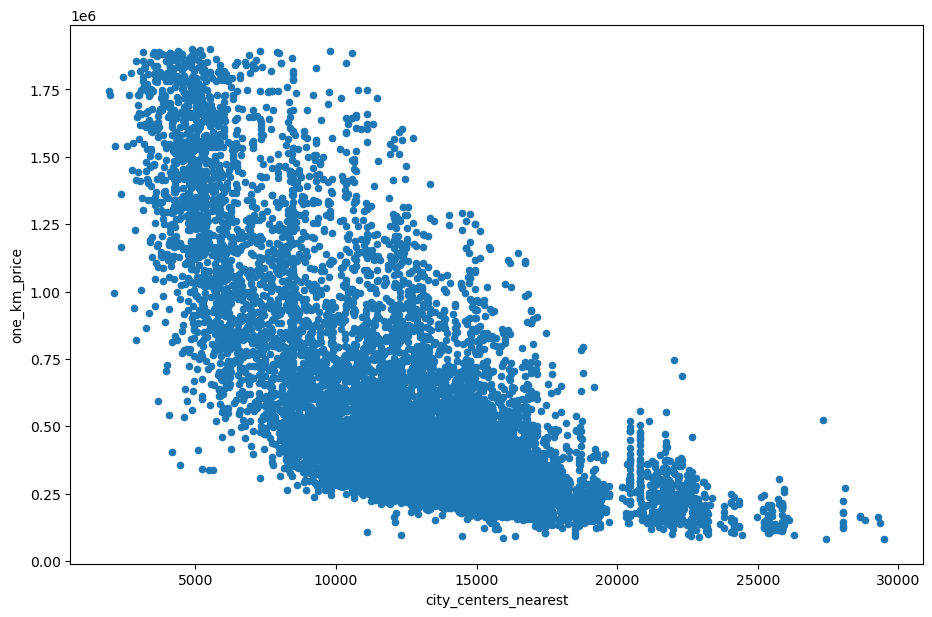

In [171]:
data[(data['locality_name']=='Санкт-Петербург')
    & (data['one_km_price']<1900000)].plot.scatter (x = 'city_centers_nearest', y = 'one_km_price', figsize=(11,7));

На данном графике можно отметить явно выраженную обратную зависимость стоимости одного километра, зависимость проявляется на интервале от 2,5 до 25 км. Нижняя граница точек описывается гиперболой.

# Общий вывод

В территориальных полях удалось сузить сегмент пропусков до 20,5% от общего количества строк. Данная группа строк не определяется через другие поля и может быть обработана только с привлечением дополнительной информации

В полях цен и площадей имеется незначительное количество выбросов в данных. При этом значения не являются некорректными

    
Сводные данные по распределениям значений полей:
    
    Объекты с ценой от 2,4 до 6,3 млн.руб. составляют 72,2% всех значений
    
    67,5% объектов - с общей площадью от 31 до 64.4 м.кв.
    78%   - с жилой площадью от 12 до 42 м.кв.
    77.5% - с площадью кухни от 3,5 до 13 м.кв.
    35,3% от общего количества составляют объявления по "однушкам", 34% - по "двушкам", 24% приходится на трехкомнатные, 4.1% - на 4-хкомнатные.
    84% потолков - от 2.4 до 2.75 м.
    
    29.5% объявлений составляют 5 этажки
    17,7% - девятиэтажки
    4.4% - малоэтажные дома (до 3-х этажей включительно)

    54.9% объектов находятся на этажах со 2-го по 6-й
    12.5% объектов - на первых этажах.
    14,2% объектов - на последних этажах.
    73,3% объектов - на других этажах

    50% объектов находятся до центра - на расстоянии от 10 до 16.6 км.
    83,5% объектов имеют ближайший парк на расстоянии от 319 до 797 м. 

    Меньше всего объявлений подается в выходные 15,2%
    Топ дни: четверг, вторник
    В данных наблюдается сезонность: пики- (февраль, март, апрель) и (сентябрь, окрябрь, ноябрь). Лето и зима - спад
    
    38.3% объектов продаются за срок от 0 до 79 дней
    31,1% за срок от 80 до 158 дней
    Все, что "висит" дольше 158 дней составляет 30,6%

Выводы по обнаруженным зависимостям данных.
    
    Цена заметно и положительно зависит от размера жилой площади (коэффициент: 0.54) и количества комнат (0.36)
    
    Имеем обратную зависимость цены от дня недели на интервале от вторника по субботу
    Зависимости цены от месяца не наблюдается.
    С 2014 по 2016 г медианная цена снижалась. Начиная с 2017 г цена растет
    
    Можно отметить для локации Санкт-Петербурга явно выраженную обратную зависимость стоимости одного километра от расстояния до центра города, зависимость проявляется на интервале от 2,5 до 25 км. Нижняя граница точек описывается гиперболой
